## Preprocessing Functions

In [ ]:
!pip install powerlaw
!pip install arch
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [ ]:
"""
acf
This code from  ICascha/QuantGANs-replication
"""

import numpy as np
from sklearn.preprocessing import StandardScaler


def rolling_window(x, k, sparse=True):
    """compute rolling windows from timeseries

    Args:
        x ([2d array]): x contains the time series in the shape (timestep, sample).
        k ([int]): number of windows
        sparse (bool): Cut off the final windows containing NA. Defaults to True.

    Returns:
        [3d array]: array of rolling windows in the shape (window, timestep, sample).
    """
    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]

    if not sparse:
        return out

    return out[:, :-(k-1)]

def acf(x, k, le=False):

    """
    Computes autocorrelation for every lag from 1 to k inclusive
    """

    arr = rolling_window(x, k, sparse=False)
    a = (arr[0] - np.nanmean(arr[0], axis=0))
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

def cross_acf(x, y, k, le=False):

    arr = rolling_window(y, k, sparse=False)
    a = (x - x.mean(axis=0))

    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

In [ ]:
"""
gaussianize
Utility code from Greg Ver Steeg.
Transform data so that it is approximately normally distributed
"""

from typing import Text, List, Union

import numpy as np
from scipy import special
from scipy.stats import kurtosis, norm, rankdata, boxcox
from scipy import optimize  # TODO: Explore efficacy of other opt. methods
import sklearn
from matplotlib import pylab as plt
from scipy import stats
import warnings
import os

np.seterr(all='warn')


# Tolerance for == 0.0 tolerance.
_EPS = 1e-6


def _update_x(x: Union[np.ndarray, List]) -> np.ndarray:
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    elif len(x.shape) != 2:
        raise ValueError("Data should be a 1-d list of samples to transform or a 2d array with samples as rows.")
    return x


class Gaussianize(sklearn.base.TransformerMixin):
    """
    Gaussianize data using various methods.

    Conventions
    ----------
    This class is a wrapper that follows sklearn naming/style (e.g. fit(X) to train).
    In this code, x is the input, y is the output. But in the functions outside the class, I follow
    Georg's convention that Y is the input and X is the output (Gaussianized) data.

    Parameters
    ----------

    strategy : str, default='lambert'. Possibilities are 'lambert'[1], 'brute'[2] and 'boxcox'[3].

    tol : float, default = 1e-4

    max_iter : int, default = 100
        Maximum number of iterations to search for correct parameters of Lambert transform.

    Attributes
    ----------
    coefs_ : list of tuples
        For each variable, we have transformation parameters.
        For Lambert, e.g., a tuple consisting of (mu, sigma, delta), corresponding to the parameters of the
        appropriate Lambert transform. Eq. 6 and 8 in the paper below.

    References
    ----------
    [1] Georg M Goerg. The Lambert Way to Gaussianize heavy tailed data with
                        the inverse of Tukey's h transformation as a special case
        Author generously provides code in R: https://cran.r-project.org/web/packages/LambertW/
    [2] Valero Laparra, Gustavo Camps-Valls, and Jesus Malo. Iterative Gaussianization: From ICA to Random Rotations
    [3] Box cox transformation and references: https://en.wikipedia.org/wiki/Power_transform
    """

    def __init__(self, strategy: Text = 'lambert',
                 tol: float = 1e-5,
                 max_iter: int = 100,
                 verbose: bool = False):
        self.tol = tol
        self.max_iter = max_iter
        self.strategy = strategy
        self.coefs_ = []  # Store tau for each transformed variable
        self.verbose = verbose

    def fit(self, x: np.ndarray, y=None):
        """Fit a Gaussianizing transformation to each variable/column in x."""
        # Initialize coefficients again with an empty list.  Otherwise
        # calling .fit() repeatedly will augment previous .coefs_ list.
        self.coefs_ = []
        x = _update_x(x)
        if self.verbose:
            print("Gaussianizing with strategy='%s'" % self.strategy)

        if self.strategy == "lambert":
            _get_coef = lambda vec: igmm(vec, self.tol, max_iter=self.max_iter)
        elif self.strategy == "brute":
            _get_coef = lambda vec: None   # TODO: In principle, we could store parameters to do a quasi-invert
        elif self.strategy == "boxcox":
            _get_coef = lambda vec: boxcox(vec)[1]
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

        for x_i in x.T:
            self.coefs_.append(_get_coef(x_i))

        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        """Transform new data using a previously learned Gaussianization model."""
        x = _update_x(x)
        if x.shape[1] != len(self.coefs_):
            raise ValueError("%d variables in test data, but %d variables were in training data." % (x.shape[1], len(self.coefs_)))

        if self.strategy == 'lambert':
            return np.array([w_t(x_i, tau_i) for x_i, tau_i in zip(x.T, self.coefs_)]).T
        elif self.strategy == 'brute':
            return np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        elif self.strategy == 'boxcox':
            return np.array([boxcox(x_i, lmbda=lmbda_i) for x_i, lmbda_i in zip(x.T, self.coefs_)]).T
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

    def inverse_transform(self, y: np.ndarray) -> np.ndarray:
        """Recover original data from Gaussianized data."""
        if self.strategy == 'lambert':
            return np.array([inverse(y_i, tau_i) for y_i, tau_i in zip(y.T, self.coefs_)]).T
        elif self.strategy == 'boxcox':
            return np.array([(1. + lmbda_i * y_i) ** (1./lmbda_i) for y_i, lmbda_i in zip(y.T, self.coefs_)]).T
        else:
            raise NotImplementedError("Inversion not supported for gaussianization transform '%s'" % self.strategy)

    def qqplot(self, x: np.ndarray, prefix: Text = 'qq', output_dir: Text = "/tmp/"):
        """Show qq plots compared to normal before and after the transform."""
        x = _update_x(x)
        y = self.transform(x)
        n_dim = y.shape[1]
        for i in range(n_dim):
            stats.probplot(x[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_before.png' % i))
            plt.clf()
            stats.probplot(y[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_after.png' % i))
            plt.clf()


def w_d(z, delta):
    # Eq. 9
    if delta < _EPS:
        return z
    return np.sign(z) * np.sqrt(np.real(special.lambertw(delta * z ** 2)) / delta)


def w_t(y, tau):
    # Eq. 8
    return tau[0] + tau[1] * w_d((y - tau[0]) / tau[1], tau[2])


def inverse(x, tau):
    # Eq. 6
    u = (x - tau[0]) / tau[1]
    return tau[0] + tau[1] * (u * np.exp(u * u * (tau[2] * 0.5)))


def igmm(y: np.ndarray, tol: float = 1e-6, max_iter: int = 100):
    # Infer mu, sigma, delta using IGMM in Alg.2, Appendix C
    if np.std(y) < _EPS:
        return np.mean(y), np.std(y).clip(_EPS), 0
    delta0 = delta_init(y)
    tau1 = (np.median(y), np.std(y) * (1. - 2. * delta0) ** 0.75, delta0)
    for k in range(max_iter):
        tau0 = tau1
        z = (y - tau1[0]) / tau1[1]
        delta1 = delta_gmm(z)
        x = tau0[0] + tau1[1] * w_d(z, delta1)
        mu1, sigma1 = np.mean(x), np.std(x)
        tau1 = (mu1, sigma1, delta1)

        if np.linalg.norm(np.array(tau1) - np.array(tau0)) < tol:
            break
        else:
            if k == max_iter - 1:
                warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)
    return tau1


def delta_gmm(z):
    # Alg. 1, Appendix C
    delta0 = delta_init(z)

    def func(q):
        u = w_d(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        else:
            k = kurtosis(u, fisher=True, bias=False)**2
            if not np.isfinite(k) or k > 1e10:
                return 1e10
            else:
                return k

    res = optimize.fmin(func, np.log(delta0), disp=0)
    return np.around(np.exp(res[-1]), 6)


def delta_init(z):
    gamma = kurtosis(z, fisher=False, bias=False)
    with np.errstate(all='ignore'):
        delta0 = np.clip(1. / 66 * (np.sqrt(66 * gamma - 162.) - 6.), 0.01, 0.48)
    if not np.isfinite(delta0):
        delta0 = 0.01
    return delta0


# if __name__ == '__main__':\

#     import sys
#     sys.argv = [sys.argv[0]]  # clear any extra arguments

#     # Command line interface
#     # Sample commands:
#     # python gaussianize.py test_data.csv
#     import csv
#     import sys, os
#     import traceback
#     from optparse import OptionParser, OptionGroup

#     parser = OptionParser(usage="usage: %prog [options] data_file.csv \n"
#                                 "It is assumed that the first row and first column of the data CSV file are labels.\n"
#                                 "Use options to indicate otherwise.")
#     group = OptionGroup(parser, "Input Data Format Options")
#     group.add_option("-c", "--no_column_names",
#                      action="store_true", dest="nc", default=False,
#                      help="We assume the top row is variable names for each column. "
#                           "This flag says that data starts on the first row and gives a "
#                           "default numbering scheme to the variables (1,2,3...).")
#     group.add_option("-r", "--no_row_names",
#                      action="store_true", dest="nr", default=False,
#                      help="We assume the first column is a label or index for each sample. "
#                           "This flag says that data starts on the first column.")
#     group.add_option("-d", "--delimiter",
#                      action="store", dest="delimiter", type="string", default=",",
#                      help="Separator between entries in the data, default is ','.")
#     parser.add_option_group(group)

#     group = OptionGroup(parser, "Transform Options")
#     group.add_option("-s", "--strategy",
#                      action="store", dest="strategy", type="string", default="lambert",
#                      help="Strategy.")
#     parser.add_option_group(group)

#     group = OptionGroup(parser, "Output Options")
#     group.add_option("-o", "--output",
#                      action="store", dest="output", type="string", default="gaussian_output.csv",
#                      help="Where to store gaussianized data.")
#     group.add_option("-q", "--qqplots",
#                      action="store_true", dest="q", default=False,
#                      help="Produce qq plots for each variable before and after transform.")
#     parser.add_option_group(group)

#     (options, args) = parser.parse_args()
#     if not len(args) == 1:
#         warnings.warn("Run with '-h' option for usage help.")
#         sys.exit()

#     #Load data from csv file
#     filename = args[0]
#     with open(filename, 'rU') as csvfile:
#         reader = csv.reader(csvfile, delimiter=" ")  #options.delimiter)
#         if options.nc:
#             variable_names = None
#         else:
#             variable_names = reader.next()[(1 - options.nr):]
#         sample_names = []
#         data = []
#         for row in reader:
#             if options.nr:
#                 sample_names = None
#             else:
#                 sample_names.append(row[0])
#             data.append(row[(1 - options.nr):])

#     print(len(data), data[0])
#     try:
#         for i in range(len(data)):
#             data[i] = map(float, data[i])
#         X = np.array(data, dtype=float)  # Data matrix in numpy format
#     except:
#         raise ValueError("Incorrect data format.\nCheck that you've correctly specified options "
#                          "such as continuous or not, \nand if there is a header row or column.\n"
#                          "Run 'python gaussianize.py -h' option for help with options.")
#         traceback.print_exc(file=sys.stdout)
#         sys.exit()

#     ks = []
#     for xi in X.T:
#         ks.append(kurtosis(xi))
#     print(np.mean(np.array(ks) > 1))
#     from matplotlib import pylab
#     pylab.hist(ks, bins=30)
#     pylab.xlabel('excess kurtosis')
#     pylab.savefig('excess_kurtoses_all.png')
#     pylab.clf()
#     pylab.hist([k for k in ks if k < 2], bins=30)
#     pylab.xlabel('excess kurtosis')
#     pylab.savefig('excess_kurtoses_near_zero.png')
#     print(np.argmax(ks))
#     pdict = {}
#     for k in np.argsort(- np.array(ks))[:50]:
#         pylab.clf()
#         p = np.argmax(X[:, k])
#         pdict[p] = pdict.get(p, 0) + 1
#         pylab.hist(X[:, k], bins=30)
#         pylab.xlabel(variable_names[k])
#         pylab.ylabel('Histogram of patients')
#         pylab.savefig('high_kurtosis/'+variable_names[k] + '.png')
#     print(pdict)  # 203, 140 appear three times.
#     sys.exit()
#     out = Gaussianize(strategy=options.strategy)
#     y = out.fit_transform(X)
#     with open(options.output, 'w') as csvfile:
#         writer = csv.writer(csvfile, delimiter=options.delimiter)
#         if not options.nc:
#             writer.writerow([""] * (1 - options.nr) + variable_names)
#         for i, row in enumerate(y):
#             if not options.nr:
#                 writer.writerow([sample_names[i]] + list(row))
#             else:
#                 writer.writerow(row)

#     if options.q:
#         print('Making qq plots')
#         prefix = options.output.split('.')[0]
#         if not os.path.exists(prefix+'_q'):
#             os.makedirs(prefix+'_q')
#         out.qqplot(X, prefix=prefix + '_q/q')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
# Set the environment variable to disable TorchDynamo before importing torch
os.environ["TORCHDYNAMO_DISABLE"] = "1"
# import torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset

## Preprocessing

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


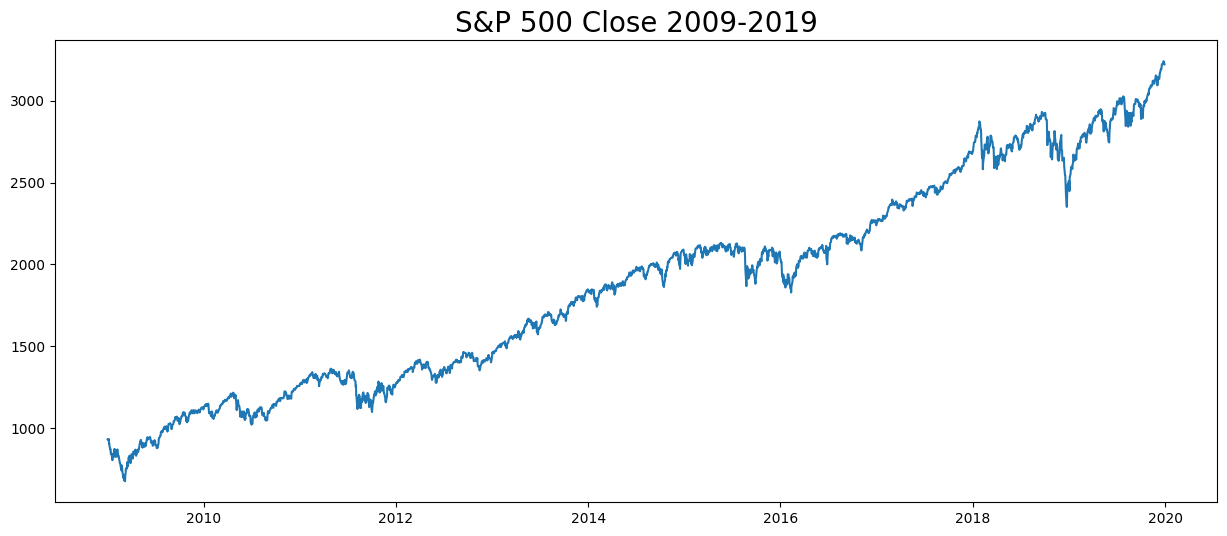

In [ ]:
data = yf.download("^GSPC", start="2009-01-01", end="2019-12-31")
df = data['Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

fig = plt.figure(figsize=(15,6))
plt.title(f'S&P 500 Close 2009-2019', fontsize=20)
plt.plot(data.index, data['Close'] )
plt.show()

In [ ]:
len(log_returns)

2766

In [ ]:
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()

# receptive field size
rfs = 127

# pre-processing pipeline
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))

## Torch Non causal TCN GAN (Architecture & Training)

In [ ]:
import os
# Disable TorchDynamo before importing torch modules
os.environ["TORCHDYNAMO_DISABLE"] = "1"

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import spectral_norm
import torch.autograd
from tqdm import tqdm

def receptive_field_size(dilations, block_size):
    return 1 + block_size * sum(dilations)

class TemporalBlock(nn.Module):
    """
    Input:
      prev_layer: Tensor of shape (B, C, H, W) where H = n_series, W = timesteps.
      skip_layer: Tensor of same shape for skip connection or None.

    Parameters:
      kernel_size (int): Kernel size along temporal axis.
      dilation (int): Dilation along temporal axis.
      fixed_filters (int): Number of filters for the fixed (main) convolution branch.
      moving_filters (int): Number of filters for the moving branch (if nonzero).
      n_series (int): Number of time series (will be used as kernel height).
      rfs (int): Receptive field size.
      block_size (int): Number of convolution layers within the block.
      use_batchNorm (bool): Whether to apply BatchNorm.
      cropping (int): Initial cropping value (will be incremented).
    Returns:
      A tuple (out, skip_out, cropping)
    """
    def __init__(self, kernel_size, dilation, input_filters, fixed_filters,
                 rfs, block_size, use_batchNorm, cropping):
        super(TemporalBlock, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.input_filters = input_filters
        self.fixed_filters = fixed_filters # Basically output filters
        self.rfs = rfs
        self.block_size = block_size
        self.use_batchNorm = use_batchNorm
        self.cropping = cropping  # initial cropping value


        # For each iteration in the block, we create a set of conv layers.
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.prelu_layers = nn.ModuleList()
        for i in range(block_size):
            # Create a list of conv layers (one for each series)
            convs_i = nn.ModuleList()

            # Note: in TF, the conv uses kernel size (n_series, kernel_size).
            # In PyTorch, input shape is (B, in_channels, H, W), so we set kernel_size=(n_series, kernel_size).
            # We assume the input channels for these convs is fixed_filters.
            if i == 0:
                conv = spectral_norm(nn.Conv1d(in_channels=input_filters,
                              out_channels=fixed_filters,
                              kernel_size=kernel_size,
                              dilation=dilation,
                              padding=0))  # no automatic padding
                init.xavier_uniform_(conv.weight)
                convs_i.append(conv)
            else:
                conv = spectral_norm(nn.Conv1d(in_channels=fixed_filters,
                              out_channels=fixed_filters,
                              kernel_size=kernel_size,
                              dilation=dilation,
                              padding=0))  # no automatic padding
                init.xavier_uniform_(conv.weight)
                convs_i.append(conv)
            self.conv_layers.append(convs_i)
            # BatchNorm (applied over channels, which is dim=1 in PyTorch)
            if use_batchNorm:
                bn = nn.BatchNorm1d(fixed_filters, eps=1e-5, momentum=0.9)
            else:
                bn = None
            self.bn_layers.append(bn)
            # PReLU; to share across spatial dimensions, we set num_parameters=1
            self.prelu_layers.append(nn.PReLU(num_parameters=1))

        # For the residual connection:
        # If skip_layer is None, apply a 1x1 convolution to prev_layer.
        self.res_conv = spectral_norm(nn.Conv1d(in_channels=input_filters,
                                out_channels=fixed_filters,
                                kernel_size=1))
        init.xavier_uniform_(self.res_conv.weight)

        # 1x1 conv for skip branch:
        self.skip_conv = spectral_norm(nn.Conv1d(in_channels=fixed_filters,
                                out_channels=fixed_filters,
                                kernel_size=1))
        init.xavier_uniform_(self.skip_conv.weight)

        # Final PReLU activation on outputs
        self.out_prelu = nn.PReLU(num_parameters=1)

    def forward(self, prev_layer, skip_layer=None, cropping_input=0):
        # Use the passed cropping input
        cropping = cropping_input
        # prev_layer: shape (B, C, H, W) with H == n_series.
        block = prev_layer  # identity mapping
        # print(block.shape)
        # Loop over each convolutional iteration
        for i in range(self.block_size):
            conv_outputs = []
            # For each series, apply the corresponding conv layer
            for conv in self.conv_layers[i]:
                # In TensorFlow code, they do: conv_out = Conv(...)(block)
                # print(block.shape)
                conv_out = conv(block)
                conv_outputs.append(conv_out)
            # If more than one conv output, concatenate along the axis corresponding to n_series.
            # In TF, Concatenate(axis=1) for channels_last input means concatenating along the height dimension.
            # In PyTorch (channels_first), the corresponding axis is 2.
            if len(conv_outputs) > 1:
                block = torch.cat(conv_outputs, dim=2)
            else:
                block = conv_outputs[0]

            if self.use_batchNorm and self.bn_layers[i] is not None:
                block = self.bn_layers[i](block)
            block = self.prelu_layers[i](block)

        # Compute drop_left = block_size * (kernel_size - 1) * dilation
        drop_left = self.block_size * (self.kernel_size - 1) * self.dilation
        new_cropping = cropping + drop_left

        # If skip_layer is None, apply a 1x1 conv to prev_layer
        if skip_layer is None:
            prev_layer = self.res_conv(prev_layer)
        # Crop prev_layer on width dimension: Cropping2D(cropping=((0,0), (drop_left, 0)))
        # In PyTorch, if W is the width dimension, then we crop by slicing off the first drop_left columns.
        prev_layer_cropped = prev_layer[:, :, drop_left:]
        # Add residual connection:
        out = prev_layer_cropped + block

        # Crop from left for skip path: Cropping2D(cropping=((0,0), (rfs-1-cropping, 0)))
        crop_left = self.rfs - 1 - new_cropping
        # print(new_cropping)
        skip_out = out[:, :, crop_left:]
        if skip_layer is not None:
            # print(skip_out.shape)
            skip_out = skip_layer + self.skip_conv(skip_out)
        else:
            # print(skip_out.shape)
            skip_out = self.skip_conv(skip_out)

        out = self.out_prelu(out)
        skip_out = self.out_prelu(skip_out)

        return out, skip_out, new_cropping

# Now we create the overall TCN module equivalent to make_TCN.

class TCN_Model(nn.Module):
    def __init__(self, dilations, input_filters, fixed_filters,use_batchNorm,
                 input_dim, block_size=2):
        """
        Args:
            dilations (list or tuple): Ordered dilations.
            fixed_filters (int): Fixed number of channels.
            use_batchNorm (bool): Whether to use BatchNorm.
            input_dim (tuple): (n_series, timesteps, n_features).
            block_size (int): Number of conv layers per temporal block.
        """
        super(TCN_Model, self).__init__()

        # Compute receptive field size.
        self.rfs = receptive_field_size(dilations, block_size)
        # For PyTorch, our input will be assumed to be (B, n_features, n_series, timesteps)
        # We start with an initial cropping value of 0.
        cropping = 0

        # The initial temporal block with kernel_size=1 and dilation=1
        # In Keras, input_layer = Input(shape=input_dim) with channels_last. In PyTorch,
        # we expect input of shape (B, n_features, n_series, timesteps).
        # For the initial block, we treat kernel_size=1, dilation=1.
        self.initial_block = TemporalBlock(
            kernel_size=1,
            dilation=1,
            input_filters=input_filters,
            fixed_filters=fixed_filters,
            rfs=self.rfs,
            block_size=block_size,
            use_batchNorm=use_batchNorm,
            cropping=cropping
        )
        # We will store subsequent temporal blocks in a ModuleList.
        self.temporal_blocks = nn.ModuleList()
        # For each dilation in dilations, add a temporal block with kernel_size=2.
        for dilation in dilations:
            self.temporal_blocks.append(
                TemporalBlock(
                    kernel_size=2,
                    dilation=dilation,
                    input_filters=fixed_filters,
                    fixed_filters=fixed_filters,
                    rfs=self.rfs,
                    block_size=block_size,
                    use_batchNorm=use_batchNorm,
                    cropping=cropping  # initial cropping; will be updated in forward
                )
            )
            # In a complete implementation, you might update cropping here based on each block's output.
            # For simplicity, we'll assume cropping is cumulatively managed inside each block.

        # Define the output layers, following the Keras code:
        # Apply a PReLU on skip_layer output from the last block.
        self.output_prelu1 = nn.PReLU(num_parameters=1)
        # 1x1 conv with spectral norm to produce (fixed_filters + moving_filters) channels.
        self.output_conv1 = spectral_norm(nn.Conv1d(
            in_channels=fixed_filters,
            out_channels=fixed_filters,
            kernel_size=1
        ))
        init.xavier_uniform_(self.output_conv1.weight)
        self.output_prelu2 = nn.PReLU(num_parameters=1)
        # 1x1 conv with spectral norm to produce 1 channel.
        self.output_conv2 = spectral_norm(nn.Conv1d(
            in_channels=fixed_filters,
            out_channels=1,
            kernel_size=1
        ))
        init.xavier_uniform_(self.output_conv2.weight)

    def forward(self, x):
        """
        x is expected to be of shape (B, n_features, n_series, timesteps)
        """
        cropping_value = 0
        out, skip, cropping_value = self.initial_block(x, None, cropping_input=cropping_value)
        # print(cropping_value)
        for block in self.temporal_blocks:
            out, skip, cropping_value = block(out, skip, cropping_input=cropping_value)
            # print(cropping_value)
        x_out = self.output_prelu1(skip)
        x_out = self.output_conv1(x_out)
        x_out = self.output_prelu2(x_out)
        x_out = self.output_conv2(x_out)
        return x_out





# Training Code
class GAN(nn.Module):
    def __init__(self, fixed_filters=64, d_lr=1e-4, g_lr=3e-5, device='cpu'):
        super().__init__()
        self.steps = 0
        self.device = device
        # Use 6 dilation levels
        dilations = [2**i for i in range(6)]

        self.generator = TCN_Model(
            input_dim=(None, 3),  # (n_series, seq_len, n_features),
            dilations=dilations,
            input_filters=3,
            fixed_filters=fixed_filters,
            use_batchNorm=True,
        ).to(device)

        self.discriminator = TCN_Model(
            input_dim=(127, 1),
            dilations=dilations,
            input_filters=1,
            fixed_filters=fixed_filters,
            use_batchNorm=False,
        ).to(device)

        # Use Adam optimizers
        self.opt_g = optim.Adam(self.generator.parameters(), eps=1e-8, lr=g_lr, betas=(.0, 0.9))
        self.opt_d = optim.Adam(self.discriminator.parameters(), eps=1e-8, lr=d_lr, betas=(.0, 0.9))

        # Define binary cross entropy loss with logits
        self.criterion = nn.BCEWithLogitsLoss()


    def train_step(self, real_data):
        # --- Discriminator update ---
        self.opt_d.zero_grad()
        # Forward pass through discriminator
        real_pred = self.discriminator(real_data)
        # Create target tensor of ones for real data
        real_target = torch.ones_like(real_pred)
        d_loss_real = self.criterion(real_pred, real_target)
        # print("real data", real_data.shape)

        # Generate fake data using noise
        # noise = torch.randn(real_data.size(0), 1, 253, 3).to(self.device)
        noise = torch.randn(real_data.size(0), 3, 253).to(self.device)
        # noise = noise.permute(0,1,3,2)
        # print("noise ", noise.shape)
        fake_data = self.generator(noise).detach()
        fake_pred = self.discriminator(fake_data.detach())
        # Create target tensor of zeros for fake data
        fake_target = torch.zeros_like(fake_pred)
        d_loss_fake = self.criterion(fake_pred, fake_target)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.opt_d.step()


        # --- Generator update (use a new forward pass) ---
        self.opt_g.zero_grad()
        # noise_gen = torch.randn(real_data.size(0), 1, 253, 3).to(self.device)
        noise_gen = torch.randn(real_data.size(0), 3, 253).to(self.device)
        # noise_gen = noise_gen.permute(0,1,3,2)
        fake_data_gen = self.generator(noise_gen).detach()
        # For generator update, we want fake data to be classified as real
        gen_target = torch.ones_like(self.discriminator(fake_data_gen))
        g_loss = self.criterion(self.discriminator(fake_data_gen), gen_target)
        g_loss.backward()
        self.opt_g.step()

        if (self.steps) % 100 == 0:
            y = self.generator(self.fixed_noise).detach().cpu().numpy().squeeze()
            scores = []
            scores.append(np.linalg.norm(self.acf_real - acf(y.T, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.abs_acf_real - acf(y.T**2, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.le_real - acf(y.T, 250, le=True).mean(axis=1, keepdims=True)))
            print("\nacf: {:.4f}, acf_abs: {:.4f}, le: {:.4f}".format(*scores))

        self.steps += 1

        return {
            'd_loss': d_loss.item(),
            'g_loss': g_loss.item()
        }

# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)



def initialize_weights(module):
    """Initialize weights like TensorFlow defaults."""
    if isinstance(module, nn.Conv1d):
        # Xavier/Glorot uniform initialization for Conv2D (like TF's glorot_uniform)
        init.xavier_uniform_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)  # Bias initialized to 0 (like TF)

    elif isinstance(module, nn.BatchNorm1d):
        # BatchNorm: gamma=1, beta=0 (like TF)
        init.ones_(module.weight)     # gamma (scale)
        init.zeros_(module.bias)      # beta (shift)
        # Note: PyTorch already initializes running_mean=0, running_var=1 (same as TF)

    elif isinstance(module, nn.Linear):
        # Linear layers also use Xavier/Glorot in TF by default
        init.xavier_uniform_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)

    elif isinstance(module, nn.PReLU):
        # PReLU: alpha=0.25 by default in TF, but PyTorch uses 0.25 by default too
        # Only needed if you want to enforce it explicitly
        init.constant_(module.weight, 0.25)

    # Note: SpectralNorm is applied as a wrapper, so we don't initialize it here.
    # Instead, ensure the base layer (Conv2D/Linear) is initialized correctly.


# Specify settings
file_name = 'SP500_daily'
generator_path = '/content/drive/MyDrive/Thesis/QuantGAN/'   # Replcae with your directory
nz = 3  # number of input features for the generator
batch_size = 64
n_batches = 1000
rfs = 127
d_lr = 1e-6
g_lr = 3e-5
# d_lr = 1e-4
# g_lr = 3e-5
device = torch.device("cpu")

gan = GAN(
    fixed_filters=100,
    d_lr=d_lr,
    g_lr=g_lr,
    device=device
)

gan.generator.apply(initialize_weights)
gan.discriminator.apply(initialize_weights)
gan.fixed_noise = torch.randn(128, 3, 3000 + rfs - 1)
gan.acf_real = acf(log_returns_preprocessed, 250)
gan.abs_acf_real = acf(log_returns_preprocessed**2, 250)
gan.le_real = acf(log_returns_preprocessed, 250, le=True)

def compute_window_weights(series_length, window_size):
    # First, compute how many windows each time step appears in.
    # For a series of length T, time step i (0-indexed) appears in:
    # count[i] = min(i+1, window_size, series_length - i)
    counts = np.array([min(i + 1, window_size, series_length - i) for i in range(series_length)])

    # Now compute a weight for each possible window starting index.
    # There are (series_length - window_size + 1) windows.
    window_weights = []
    for t in range(series_length - window_size + 1):
        # For window starting at t, get the counts for all time steps in that window
        window_counts = counts[t: t + window_size]
        # The idea is to favor windows where the average count is low
        # (i.e. under-sampled time steps get higher weight)
        weight = np.mean(1.0 / window_counts)
        window_weights.append(weight)
    window_weights = np.array(window_weights)
    # Normalize weights to sum to 1
    window_weights /= window_weights.sum()
    return window_weights

# Train
progress_bar = tqdm(range(n_batches))
for i in progress_bar:
    progress_bar.set_description(f"Batch {i}/{len(progress_bar)}")

    roll = rolling_window(log_returns_preprocessed, len(log_returns_preprocessed) - 127 + 1)
    window_weights = compute_window_weights(log_returns_preprocessed.shape[0], 127)
    idx = np.random.choice(roll.shape[0], 64)
    real_data = torch.from_numpy(roll[idx])
    real_data = real_data.permute(0,2,1)
    real_data = real_data.float()
    losses = gan.train_step(real_data)
    total_d_loss = losses['d_loss']
    total_g_loss = losses['g_loss']
    print(f'Batch {i+1} | D Loss: {total_d_loss:.4f} | G Loss: {total_g_loss:.4f}')



torch.save(gan.generator, f'{generator_path}torch_non_causal_tcn_{n_batches}.pth')    # Replcae with your directory

Batch 1/1000:   0%|          | 1/1000 [00:38<10:48:25, 38.94s/it]


acf: 0.3646, acf_abs: 1.3786, le: 0.6079
Batch 1 | D Loss: 1.3968 | G Loss: 0.7017


Batch 2/1000:   0%|          | 2/1000 [00:41<4:49:06, 17.38s/it]

Batch 2 | D Loss: 1.3890 | G Loss: 0.6989


Batch 3/1000:   0%|          | 3/1000 [00:43<2:57:07, 10.66s/it]

Batch 3 | D Loss: 1.3909 | G Loss: 0.6980


Batch 4/1000:   0%|          | 4/1000 [00:47<2:07:52,  7.70s/it]

Batch 4 | D Loss: 1.3919 | G Loss: 0.6981


Batch 5/1000:   0%|          | 5/1000 [00:49<1:35:05,  5.73s/it]

Batch 5 | D Loss: 1.3917 | G Loss: 0.6979


Batch 6/1000:   1%|          | 6/1000 [00:51<1:15:17,  4.55s/it]

Batch 6 | D Loss: 1.3911 | G Loss: 0.6975


Batch 7/1000:   1%|          | 7/1000 [00:53<1:02:44,  3.79s/it]

Batch 7 | D Loss: 1.3911 | G Loss: 0.6971


Batch 8/1000:   1%|          | 8/1000 [00:56<54:30,  3.30s/it]

Batch 8 | D Loss: 1.3901 | G Loss: 0.6975


Batch 9/1000:   1%|          | 9/1000 [00:58<52:40,  3.19s/it]

Batch 9 | D Loss: 1.3916 | G Loss: 0.6972


Batch 10/1000:   1%|          | 10/1000 [01:01<50:50,  3.08s/it]

Batch 10 | D Loss: 1.3881 | G Loss: 0.6973


Batch 11/1000:   1%|          | 11/1000 [01:04<46:34,  2.83s/it]

Batch 11 | D Loss: 1.3890 | G Loss: 0.6977


Batch 12/1000:   1%|          | 12/1000 [01:06<43:35,  2.65s/it]

Batch 12 | D Loss: 1.3917 | G Loss: 0.6971


Batch 13/1000:   1%|▏         | 13/1000 [01:08<41:36,  2.53s/it]

Batch 13 | D Loss: 1.3922 | G Loss: 0.6967


Batch 14/1000:   1%|▏         | 14/1000 [01:10<39:59,  2.43s/it]

Batch 14 | D Loss: 1.3901 | G Loss: 0.6974


Batch 15/1000:   2%|▏         | 15/1000 [01:14<44:00,  2.68s/it]

Batch 15 | D Loss: 1.3923 | G Loss: 0.6976


Batch 16/1000:   2%|▏         | 16/1000 [01:16<43:23,  2.65s/it]

Batch 16 | D Loss: 1.3922 | G Loss: 0.6972


Batch 17/1000:   2%|▏         | 17/1000 [01:18<41:17,  2.52s/it]

Batch 17 | D Loss: 1.3916 | G Loss: 0.6965


Batch 18/1000:   2%|▏         | 18/1000 [01:21<39:54,  2.44s/it]

Batch 18 | D Loss: 1.3896 | G Loss: 0.6971


Batch 19/1000:   2%|▏         | 19/1000 [01:23<38:55,  2.38s/it]

Batch 19 | D Loss: 1.3903 | G Loss: 0.6970


Batch 20/1000:   2%|▏         | 20/1000 [01:25<39:36,  2.42s/it]

Batch 20 | D Loss: 1.3924 | G Loss: 0.6965


Batch 21/1000:   2%|▏         | 21/1000 [01:29<43:41,  2.68s/it]

Batch 21 | D Loss: 1.3896 | G Loss: 0.6969


Batch 22/1000:   2%|▏         | 22/1000 [01:31<41:37,  2.55s/it]

Batch 22 | D Loss: 1.3914 | G Loss: 0.6974


Batch 23/1000:   2%|▏         | 23/1000 [01:33<40:06,  2.46s/it]

Batch 23 | D Loss: 1.3920 | G Loss: 0.6967


Batch 24/1000:   2%|▏         | 24/1000 [01:35<38:58,  2.40s/it]

Batch 24 | D Loss: 1.3904 | G Loss: 0.6970


Batch 25/1000:   2%|▎         | 25/1000 [01:38<38:21,  2.36s/it]

Batch 25 | D Loss: 1.3922 | G Loss: 0.6963


Batch 26/1000:   3%|▎         | 26/1000 [01:40<40:42,  2.51s/it]

Batch 26 | D Loss: 1.3908 | G Loss: 0.6966


Batch 27/1000:   3%|▎         | 27/1000 [01:43<43:04,  2.66s/it]

Batch 27 | D Loss: 1.3922 | G Loss: 0.6966


Batch 28/1000:   3%|▎         | 28/1000 [01:46<41:06,  2.54s/it]

Batch 28 | D Loss: 1.3923 | G Loss: 0.6967


Batch 29/1000:   3%|▎         | 29/1000 [01:48<39:41,  2.45s/it]

Batch 29 | D Loss: 1.3922 | G Loss: 0.6965


Batch 30/1000:   3%|▎         | 30/1000 [01:50<38:39,  2.39s/it]

Batch 30 | D Loss: 1.3894 | G Loss: 0.6982


Batch 31/1000:   3%|▎         | 31/1000 [01:52<37:39,  2.33s/it]

Batch 31 | D Loss: 1.3920 | G Loss: 0.6969


Batch 32/1000:   3%|▎         | 32/1000 [01:56<41:42,  2.58s/it]

Batch 32 | D Loss: 1.3908 | G Loss: 0.6968


Batch 33/1000:   3%|▎         | 33/1000 [01:58<42:01,  2.61s/it]

Batch 33 | D Loss: 1.3921 | G Loss: 0.6970


Batch 34/1000:   3%|▎         | 34/1000 [02:01<42:36,  2.65s/it]

Batch 34 | D Loss: 1.3916 | G Loss: 0.6970


Batch 35/1000:   4%|▎         | 35/1000 [02:03<40:39,  2.53s/it]

Batch 35 | D Loss: 1.3916 | G Loss: 0.6966


Batch 36/1000:   4%|▎         | 36/1000 [02:05<39:06,  2.43s/it]

Batch 36 | D Loss: 1.3909 | G Loss: 0.6962


Batch 37/1000:   4%|▎         | 37/1000 [02:08<40:06,  2.50s/it]

Batch 37 | D Loss: 1.3924 | G Loss: 0.6964


Batch 38/1000:   4%|▍         | 38/1000 [02:11<43:32,  2.72s/it]

Batch 38 | D Loss: 1.3915 | G Loss: 0.6961


Batch 39/1000:   4%|▍         | 39/1000 [02:14<41:20,  2.58s/it]

Batch 39 | D Loss: 1.3909 | G Loss: 0.6972


Batch 40/1000:   4%|▍         | 40/1000 [02:16<39:39,  2.48s/it]

Batch 40 | D Loss: 1.3921 | G Loss: 0.6958


Batch 41/1000:   4%|▍         | 41/1000 [02:18<38:20,  2.40s/it]

Batch 41 | D Loss: 1.3916 | G Loss: 0.6961


Batch 42/1000:   4%|▍         | 42/1000 [02:20<37:22,  2.34s/it]

Batch 42 | D Loss: 1.3904 | G Loss: 0.6973


Batch 43/1000:   4%|▍         | 43/1000 [02:23<39:49,  2.50s/it]

Batch 43 | D Loss: 1.3890 | G Loss: 0.6967


Batch 44/1000:   4%|▍         | 44/1000 [02:26<41:59,  2.64s/it]

Batch 44 | D Loss: 1.3898 | G Loss: 0.6962


Batch 45/1000:   4%|▍         | 45/1000 [02:28<40:01,  2.51s/it]

Batch 45 | D Loss: 1.3887 | G Loss: 0.6966


Batch 46/1000:   5%|▍         | 46/1000 [02:31<38:51,  2.44s/it]

Batch 46 | D Loss: 1.3910 | G Loss: 0.6966


Batch 47/1000:   5%|▍         | 47/1000 [02:33<37:48,  2.38s/it]

Batch 47 | D Loss: 1.3910 | G Loss: 0.6964


Batch 48/1000:   5%|▍         | 48/1000 [02:35<37:05,  2.34s/it]

Batch 48 | D Loss: 1.3904 | G Loss: 0.6964


Batch 49/1000:   5%|▍         | 49/1000 [02:38<41:22,  2.61s/it]

Batch 49 | D Loss: 1.3909 | G Loss: 0.6967


Batch 50/1000:   5%|▌         | 50/1000 [02:41<41:40,  2.63s/it]

Batch 50 | D Loss: 1.3917 | G Loss: 0.6972


Batch 51/1000:   5%|▌         | 51/1000 [02:43<39:44,  2.51s/it]

Batch 51 | D Loss: 1.3928 | G Loss: 0.6966


Batch 52/1000:   5%|▌         | 52/1000 [02:45<38:14,  2.42s/it]

Batch 52 | D Loss: 1.3910 | G Loss: 0.6968


Batch 53/1000:   5%|▌         | 53/1000 [02:48<37:19,  2.37s/it]

Batch 53 | D Loss: 1.3889 | G Loss: 0.6974


Batch 54/1000:   5%|▌         | 54/1000 [02:50<37:20,  2.37s/it]

Batch 54 | D Loss: 1.3902 | G Loss: 0.6964


Batch 55/1000:   6%|▌         | 55/1000 [02:53<41:33,  2.64s/it]

Batch 55 | D Loss: 1.3924 | G Loss: 0.6968


Batch 56/1000:   6%|▌         | 56/1000 [02:56<40:24,  2.57s/it]

Batch 56 | D Loss: 1.3898 | G Loss: 0.6964


Batch 57/1000:   6%|▌         | 57/1000 [02:58<38:53,  2.47s/it]

Batch 57 | D Loss: 1.3923 | G Loss: 0.6965


Batch 58/1000:   6%|▌         | 58/1000 [03:00<37:42,  2.40s/it]

Batch 58 | D Loss: 1.3929 | G Loss: 0.6966


Batch 59/1000:   6%|▌         | 59/1000 [03:02<36:55,  2.35s/it]

Batch 59 | D Loss: 1.3900 | G Loss: 0.6962


Batch 60/1000:   6%|▌         | 60/1000 [03:05<38:30,  2.46s/it]

Batch 60 | D Loss: 1.3906 | G Loss: 0.6973


Batch 61/1000:   6%|▌         | 61/1000 [03:08<41:58,  2.68s/it]

Batch 61 | D Loss: 1.3900 | G Loss: 0.6965


Batch 62/1000:   6%|▌         | 62/1000 [03:11<39:46,  2.54s/it]

Batch 62 | D Loss: 1.3898 | G Loss: 0.6957


Batch 63/1000:   6%|▋         | 63/1000 [03:13<38:14,  2.45s/it]

Batch 63 | D Loss: 1.3906 | G Loss: 0.6963


Batch 64/1000:   6%|▋         | 64/1000 [03:15<37:04,  2.38s/it]

Batch 64 | D Loss: 1.3907 | G Loss: 0.6962


Batch 65/1000:   6%|▋         | 65/1000 [03:17<36:19,  2.33s/it]

Batch 65 | D Loss: 1.3914 | G Loss: 0.6968


Batch 66/1000:   7%|▋         | 66/1000 [03:20<39:04,  2.51s/it]

Batch 66 | D Loss: 1.3908 | G Loss: 0.6964


Batch 67/1000:   7%|▋         | 67/1000 [03:23<40:58,  2.64s/it]

Batch 67 | D Loss: 1.3910 | G Loss: 0.6960


Batch 68/1000:   7%|▋         | 68/1000 [03:25<39:11,  2.52s/it]

Batch 68 | D Loss: 1.3902 | G Loss: 0.6966


Batch 69/1000:   7%|▋         | 69/1000 [03:28<38:03,  2.45s/it]

Batch 69 | D Loss: 1.3911 | G Loss: 0.6962


Batch 70/1000:   7%|▋         | 70/1000 [03:30<37:00,  2.39s/it]

Batch 70 | D Loss: 1.3912 | G Loss: 0.6963


Batch 71/1000:   7%|▋         | 71/1000 [03:32<36:21,  2.35s/it]

Batch 71 | D Loss: 1.3903 | G Loss: 0.6971


Batch 72/1000:   7%|▋         | 72/1000 [03:35<40:31,  2.62s/it]

Batch 72 | D Loss: 1.3913 | G Loss: 0.6963


Batch 73/1000:   7%|▋         | 73/1000 [03:38<40:32,  2.62s/it]

Batch 73 | D Loss: 1.3917 | G Loss: 0.6957


Batch 74/1000:   7%|▋         | 74/1000 [03:40<38:37,  2.50s/it]

Batch 74 | D Loss: 1.3900 | G Loss: 0.6961


Batch 75/1000:   8%|▊         | 75/1000 [03:42<37:16,  2.42s/it]

Batch 75 | D Loss: 1.3898 | G Loss: 0.6976


Batch 76/1000:   8%|▊         | 76/1000 [03:45<36:23,  2.36s/it]

Batch 76 | D Loss: 1.3906 | G Loss: 0.6970


Batch 77/1000:   8%|▊         | 77/1000 [03:47<36:59,  2.40s/it]

Batch 77 | D Loss: 1.3896 | G Loss: 0.6964


Batch 78/1000:   8%|▊         | 78/1000 [03:50<40:56,  2.66s/it]

Batch 78 | D Loss: 1.3903 | G Loss: 0.6956


Batch 79/1000:   8%|▊         | 79/1000 [03:53<39:06,  2.55s/it]

Batch 79 | D Loss: 1.3908 | G Loss: 0.6956


Batch 80/1000:   8%|▊         | 80/1000 [03:55<37:33,  2.45s/it]

Batch 80 | D Loss: 1.3909 | G Loss: 0.6967


Batch 81/1000:   8%|▊         | 81/1000 [03:57<36:33,  2.39s/it]

Batch 81 | D Loss: 1.3905 | G Loss: 0.6964


Batch 82/1000:   8%|▊         | 82/1000 [03:59<35:45,  2.34s/it]

Batch 82 | D Loss: 1.3887 | G Loss: 0.6962


Batch 83/1000:   8%|▊         | 83/1000 [04:02<37:27,  2.45s/it]

Batch 83 | D Loss: 1.3894 | G Loss: 0.6965


Batch 84/1000:   8%|▊         | 84/1000 [04:05<40:26,  2.65s/it]

Batch 84 | D Loss: 1.3915 | G Loss: 0.6953


Batch 85/1000:   8%|▊         | 85/1000 [04:08<38:35,  2.53s/it]

Batch 85 | D Loss: 1.3904 | G Loss: 0.6960


Batch 86/1000:   9%|▊         | 86/1000 [04:10<37:14,  2.44s/it]

Batch 86 | D Loss: 1.3907 | G Loss: 0.6965


Batch 87/1000:   9%|▊         | 87/1000 [04:12<36:13,  2.38s/it]

Batch 87 | D Loss: 1.3905 | G Loss: 0.6964


Batch 88/1000:   9%|▉         | 88/1000 [04:14<35:35,  2.34s/it]

Batch 88 | D Loss: 1.3883 | G Loss: 0.6965


Batch 89/1000:   9%|▉         | 89/1000 [04:17<38:45,  2.55s/it]

Batch 89 | D Loss: 1.3909 | G Loss: 0.6958


Batch 90/1000:   9%|▉         | 90/1000 [04:20<39:52,  2.63s/it]

Batch 90 | D Loss: 1.3884 | G Loss: 0.6958


Batch 91/1000:   9%|▉         | 91/1000 [04:22<38:08,  2.52s/it]

Batch 91 | D Loss: 1.3906 | G Loss: 0.6960


Batch 92/1000:   9%|▉         | 92/1000 [04:25<36:54,  2.44s/it]

Batch 92 | D Loss: 1.3899 | G Loss: 0.6953


Batch 93/1000:   9%|▉         | 93/1000 [04:27<36:04,  2.39s/it]

Batch 93 | D Loss: 1.3900 | G Loss: 0.6959


Batch 94/1000:   9%|▉         | 94/1000 [04:29<35:44,  2.37s/it]

Batch 94 | D Loss: 1.3914 | G Loss: 0.6954


Batch 95/1000:  10%|▉         | 95/1000 [04:32<39:49,  2.64s/it]

Batch 95 | D Loss: 1.3894 | G Loss: 0.6951


Batch 96/1000:  10%|▉         | 96/1000 [04:35<38:58,  2.59s/it]

Batch 96 | D Loss: 1.3916 | G Loss: 0.6959


Batch 97/1000:  10%|▉         | 97/1000 [04:37<37:31,  2.49s/it]

Batch 97 | D Loss: 1.3887 | G Loss: 0.6966


Batch 98/1000:  10%|▉         | 98/1000 [04:40<36:36,  2.44s/it]

Batch 98 | D Loss: 1.3905 | G Loss: 0.6963


Batch 99/1000:  10%|▉         | 99/1000 [04:42<35:43,  2.38s/it]

Batch 99 | D Loss: 1.3900 | G Loss: 0.6962


Batch 100/1000:  10%|█         | 100/1000 [04:44<37:05,  2.47s/it]

Batch 100 | D Loss: 1.3912 | G Loss: 0.6956


Batch 101/1000:  10%|█         | 101/1000 [05:20<3:05:30, 12.38s/it]


acf: 0.3641, acf_abs: 1.3785, le: 0.5971
Batch 101 | D Loss: 1.3892 | G Loss: 0.6957


Batch 102/1000:  10%|█         | 102/1000 [05:22<2:19:47,  9.34s/it]

Batch 102 | D Loss: 1.3889 | G Loss: 0.6961


Batch 103/1000:  10%|█         | 103/1000 [05:24<1:47:53,  7.22s/it]

Batch 103 | D Loss: 1.3905 | G Loss: 0.6957


Batch 104/1000:  10%|█         | 104/1000 [05:28<1:29:07,  5.97s/it]

Batch 104 | D Loss: 1.3869 | G Loss: 0.6956


Batch 105/1000:  10%|█         | 105/1000 [05:30<1:14:57,  5.03s/it]

Batch 105 | D Loss: 1.3882 | G Loss: 0.6952


Batch 106/1000:  11%|█         | 106/1000 [05:33<1:02:22,  4.19s/it]

Batch 106 | D Loss: 1.3893 | G Loss: 0.6961


Batch 107/1000:  11%|█         | 107/1000 [05:35<53:33,  3.60s/it]

Batch 107 | D Loss: 1.3889 | G Loss: 0.6959


Batch 108/1000:  11%|█         | 108/1000 [05:37<47:31,  3.20s/it]

Batch 108 | D Loss: 1.3887 | G Loss: 0.6967


Batch 109/1000:  11%|█         | 109/1000 [05:39<43:46,  2.95s/it]

Batch 109 | D Loss: 1.3895 | G Loss: 0.6959


Batch 110/1000:  11%|█         | 110/1000 [05:43<45:24,  3.06s/it]

Batch 110 | D Loss: 1.3887 | G Loss: 0.6961


Batch 111/1000:  11%|█         | 111/1000 [05:45<42:36,  2.88s/it]

Batch 111 | D Loss: 1.3887 | G Loss: 0.6955


Batch 112/1000:  11%|█         | 112/1000 [05:47<39:50,  2.69s/it]

Batch 112 | D Loss: 1.3908 | G Loss: 0.6961


Batch 113/1000:  11%|█▏        | 113/1000 [05:50<37:44,  2.55s/it]

Batch 113 | D Loss: 1.3897 | G Loss: 0.6956


Batch 114/1000:  11%|█▏        | 114/1000 [05:52<36:19,  2.46s/it]

Batch 114 | D Loss: 1.3902 | G Loss: 0.6955


Batch 115/1000:  12%|█▏        | 115/1000 [05:55<36:57,  2.51s/it]

Batch 115 | D Loss: 1.3907 | G Loss: 0.6957


Batch 116/1000:  12%|█▏        | 116/1000 [05:58<40:08,  2.72s/it]

Batch 116 | D Loss: 1.3887 | G Loss: 0.6956


Batch 117/1000:  12%|█▏        | 117/1000 [06:00<37:49,  2.57s/it]

Batch 117 | D Loss: 1.3888 | G Loss: 0.6952


Batch 118/1000:  12%|█▏        | 118/1000 [06:02<36:07,  2.46s/it]

Batch 118 | D Loss: 1.3887 | G Loss: 0.6956


Batch 119/1000:  12%|█▏        | 119/1000 [06:04<35:06,  2.39s/it]

Batch 119 | D Loss: 1.3891 | G Loss: 0.6960


Batch 120/1000:  12%|█▏        | 120/1000 [06:07<34:23,  2.35s/it]

Batch 120 | D Loss: 1.3888 | G Loss: 0.6953


Batch 121/1000:  12%|█▏        | 121/1000 [06:09<36:29,  2.49s/it]

Batch 121 | D Loss: 1.3913 | G Loss: 0.6960


Batch 122/1000:  12%|█▏        | 122/1000 [06:12<38:34,  2.64s/it]

Batch 122 | D Loss: 1.3884 | G Loss: 0.6952


Batch 123/1000:  12%|█▏        | 123/1000 [06:15<36:47,  2.52s/it]

Batch 123 | D Loss: 1.3884 | G Loss: 0.6955


Batch 124/1000:  12%|█▏        | 124/1000 [06:17<35:38,  2.44s/it]

Batch 124 | D Loss: 1.3885 | G Loss: 0.6960


Batch 125/1000:  12%|█▎        | 125/1000 [06:19<34:47,  2.39s/it]

Batch 125 | D Loss: 1.3885 | G Loss: 0.6963


Batch 126/1000:  13%|█▎        | 126/1000 [06:21<34:10,  2.35s/it]

Batch 126 | D Loss: 1.3895 | G Loss: 0.6953


Batch 127/1000:  13%|█▎        | 127/1000 [06:25<37:53,  2.60s/it]

Batch 127 | D Loss: 1.3893 | G Loss: 0.6951


Batch 128/1000:  13%|█▎        | 128/1000 [06:27<38:10,  2.63s/it]

Batch 128 | D Loss: 1.3884 | G Loss: 0.6957


Batch 129/1000:  13%|█▎        | 129/1000 [06:30<36:36,  2.52s/it]

Batch 129 | D Loss: 1.3896 | G Loss: 0.6957


Batch 130/1000:  13%|█▎        | 130/1000 [06:32<35:24,  2.44s/it]

Batch 130 | D Loss: 1.3868 | G Loss: 0.6956


Batch 131/1000:  13%|█▎        | 131/1000 [06:34<34:36,  2.39s/it]

Batch 131 | D Loss: 1.3872 | G Loss: 0.6958


Batch 132/1000:  13%|█▎        | 132/1000 [06:37<35:17,  2.44s/it]

Batch 132 | D Loss: 1.3889 | G Loss: 0.6953


Batch 133/1000:  13%|█▎        | 133/1000 [06:40<39:10,  2.71s/it]

Batch 133 | D Loss: 1.3886 | G Loss: 0.6956


Batch 134/1000:  13%|█▎        | 134/1000 [06:42<37:28,  2.60s/it]

Batch 134 | D Loss: 1.3876 | G Loss: 0.6955


Batch 135/1000:  14%|█▎        | 135/1000 [06:45<35:52,  2.49s/it]

Batch 135 | D Loss: 1.3885 | G Loss: 0.6955


Batch 136/1000:  14%|█▎        | 136/1000 [06:47<34:43,  2.41s/it]

Batch 136 | D Loss: 1.3886 | G Loss: 0.6956


Batch 137/1000:  14%|█▎        | 137/1000 [06:49<33:58,  2.36s/it]

Batch 137 | D Loss: 1.3879 | G Loss: 0.6949


Batch 138/1000:  14%|█▍        | 138/1000 [06:52<35:42,  2.49s/it]

Batch 138 | D Loss: 1.3900 | G Loss: 0.6957


Batch 139/1000:  14%|█▍        | 139/1000 [06:55<38:16,  2.67s/it]

Batch 139 | D Loss: 1.3887 | G Loss: 0.6957


Batch 140/1000:  14%|█▍        | 140/1000 [06:57<36:19,  2.53s/it]

Batch 140 | D Loss: 1.3891 | G Loss: 0.6957


Batch 141/1000:  14%|█▍        | 141/1000 [06:59<35:07,  2.45s/it]

Batch 141 | D Loss: 1.3894 | G Loss: 0.6953


Batch 142/1000:  14%|█▍        | 142/1000 [07:02<34:08,  2.39s/it]

Batch 142 | D Loss: 1.3866 | G Loss: 0.6956


Batch 143/1000:  14%|█▍        | 143/1000 [07:04<33:28,  2.34s/it]

Batch 143 | D Loss: 1.3876 | G Loss: 0.6951


Batch 144/1000:  14%|█▍        | 144/1000 [07:07<37:08,  2.60s/it]

Batch 144 | D Loss: 1.3885 | G Loss: 0.6955


Batch 145/1000:  14%|█▍        | 145/1000 [07:10<37:49,  2.65s/it]

Batch 145 | D Loss: 1.3895 | G Loss: 0.6954


Batch 146/1000:  15%|█▍        | 146/1000 [07:12<36:13,  2.54s/it]

Batch 146 | D Loss: 1.3892 | G Loss: 0.6952


Batch 147/1000:  15%|█▍        | 147/1000 [07:14<34:56,  2.46s/it]

Batch 147 | D Loss: 1.3883 | G Loss: 0.6951


Batch 148/1000:  15%|█▍        | 148/1000 [07:17<33:53,  2.39s/it]

Batch 148 | D Loss: 1.3906 | G Loss: 0.6956


Batch 149/1000:  15%|█▍        | 149/1000 [07:19<33:48,  2.38s/it]

Batch 149 | D Loss: 1.3870 | G Loss: 0.6947


Batch 150/1000:  15%|█▌        | 150/1000 [07:22<37:35,  2.65s/it]

Batch 150 | D Loss: 1.3887 | G Loss: 0.6954


Batch 151/1000:  15%|█▌        | 151/1000 [07:25<36:17,  2.56s/it]

Batch 151 | D Loss: 1.3885 | G Loss: 0.6950


Batch 152/1000:  15%|█▌        | 152/1000 [07:27<34:55,  2.47s/it]

Batch 152 | D Loss: 1.3876 | G Loss: 0.6960


Batch 153/1000:  15%|█▌        | 153/1000 [07:29<34:03,  2.41s/it]

Batch 153 | D Loss: 1.3886 | G Loss: 0.6948


Batch 154/1000:  15%|█▌        | 154/1000 [07:31<33:14,  2.36s/it]

Batch 154 | D Loss: 1.3890 | G Loss: 0.6952


Batch 155/1000:  16%|█▌        | 155/1000 [07:34<34:33,  2.45s/it]

Batch 155 | D Loss: 1.3885 | G Loss: 0.6956


Batch 156/1000:  16%|█▌        | 156/1000 [07:37<37:24,  2.66s/it]

Batch 156 | D Loss: 1.3895 | G Loss: 0.6952


Batch 157/1000:  16%|█▌        | 157/1000 [07:40<35:36,  2.53s/it]

Batch 157 | D Loss: 1.3873 | G Loss: 0.6948


Batch 158/1000:  16%|█▌        | 158/1000 [07:42<34:24,  2.45s/it]

Batch 158 | D Loss: 1.3879 | G Loss: 0.6949


Batch 159/1000:  16%|█▌        | 159/1000 [07:44<33:27,  2.39s/it]

Batch 159 | D Loss: 1.3893 | G Loss: 0.6946


Batch 160/1000:  16%|█▌        | 160/1000 [07:46<32:43,  2.34s/it]

Batch 160 | D Loss: 1.3895 | G Loss: 0.6960


Batch 161/1000:  16%|█▌        | 161/1000 [07:49<35:19,  2.53s/it]

Batch 161 | D Loss: 1.3878 | G Loss: 0.6952


Batch 162/1000:  16%|█▌        | 162/1000 [07:52<36:26,  2.61s/it]

Batch 162 | D Loss: 1.3880 | G Loss: 0.6949


Batch 163/1000:  16%|█▋        | 163/1000 [07:54<34:46,  2.49s/it]

Batch 163 | D Loss: 1.3885 | G Loss: 0.6951


Batch 164/1000:  16%|█▋        | 164/1000 [07:56<33:42,  2.42s/it]

Batch 164 | D Loss: 1.3878 | G Loss: 0.6951


Batch 165/1000:  16%|█▋        | 165/1000 [07:59<32:53,  2.36s/it]

Batch 165 | D Loss: 1.3879 | G Loss: 0.6951


Batch 166/1000:  17%|█▋        | 166/1000 [08:01<32:16,  2.32s/it]

Batch 166 | D Loss: 1.3892 | G Loss: 0.6952


Batch 167/1000:  17%|█▋        | 167/1000 [08:04<35:56,  2.59s/it]

Batch 167 | D Loss: 1.3870 | G Loss: 0.6956


Batch 168/1000:  17%|█▋        | 168/1000 [08:07<35:51,  2.59s/it]

Batch 168 | D Loss: 1.3878 | G Loss: 0.6952


Batch 169/1000:  17%|█▋        | 169/1000 [08:09<34:22,  2.48s/it]

Batch 169 | D Loss: 1.3881 | G Loss: 0.6954


Batch 170/1000:  17%|█▋        | 170/1000 [08:11<33:21,  2.41s/it]

Batch 170 | D Loss: 1.3879 | G Loss: 0.6952


Batch 171/1000:  17%|█▋        | 171/1000 [08:13<32:34,  2.36s/it]

Batch 171 | D Loss: 1.3885 | G Loss: 0.6958


Batch 172/1000:  17%|█▋        | 172/1000 [08:16<32:52,  2.38s/it]

Batch 172 | D Loss: 1.3880 | G Loss: 0.6956


Batch 173/1000:  17%|█▋        | 173/1000 [08:19<36:41,  2.66s/it]

Batch 173 | D Loss: 1.3884 | G Loss: 0.6948


Batch 174/1000:  17%|█▋        | 174/1000 [08:22<35:12,  2.56s/it]

Batch 174 | D Loss: 1.3885 | G Loss: 0.6945


Batch 175/1000:  18%|█▊        | 175/1000 [08:24<33:50,  2.46s/it]

Batch 175 | D Loss: 1.3886 | G Loss: 0.6949


Batch 176/1000:  18%|█▊        | 176/1000 [08:26<32:48,  2.39s/it]

Batch 176 | D Loss: 1.3886 | G Loss: 0.6950


Batch 177/1000:  18%|█▊        | 177/1000 [08:28<32:11,  2.35s/it]

Batch 177 | D Loss: 1.3881 | G Loss: 0.6950


Batch 178/1000:  18%|█▊        | 178/1000 [08:31<33:48,  2.47s/it]

Batch 178 | D Loss: 1.3885 | G Loss: 0.6948


Batch 179/1000:  18%|█▊        | 179/1000 [08:34<36:18,  2.65s/it]

Batch 179 | D Loss: 1.3886 | G Loss: 0.6949


Batch 180/1000:  18%|█▊        | 180/1000 [08:36<34:35,  2.53s/it]

Batch 180 | D Loss: 1.3866 | G Loss: 0.6948


Batch 181/1000:  18%|█▊        | 181/1000 [08:39<33:18,  2.44s/it]

Batch 181 | D Loss: 1.3874 | G Loss: 0.6946


Batch 182/1000:  18%|█▊        | 182/1000 [08:41<32:31,  2.39s/it]

Batch 182 | D Loss: 1.3886 | G Loss: 0.6950


Batch 183/1000:  18%|█▊        | 183/1000 [08:43<31:56,  2.35s/it]

Batch 183 | D Loss: 1.3878 | G Loss: 0.6948


Batch 184/1000:  18%|█▊        | 184/1000 [08:46<34:51,  2.56s/it]

Batch 184 | D Loss: 1.3887 | G Loss: 0.6947


Batch 185/1000:  18%|█▊        | 185/1000 [08:49<35:29,  2.61s/it]

Batch 185 | D Loss: 1.3878 | G Loss: 0.6954


Batch 186/1000:  19%|█▊        | 186/1000 [08:51<33:49,  2.49s/it]

Batch 186 | D Loss: 1.3880 | G Loss: 0.6950


Batch 187/1000:  19%|█▊        | 187/1000 [08:53<32:38,  2.41s/it]

Batch 187 | D Loss: 1.3880 | G Loss: 0.6950


Batch 188/1000:  19%|█▉        | 188/1000 [08:56<31:55,  2.36s/it]

Batch 188 | D Loss: 1.3879 | G Loss: 0.6944


Batch 189/1000:  19%|█▉        | 189/1000 [08:58<31:23,  2.32s/it]

Batch 189 | D Loss: 1.3892 | G Loss: 0.6950


Batch 190/1000:  19%|█▉        | 190/1000 [09:01<35:21,  2.62s/it]

Batch 190 | D Loss: 1.3877 | G Loss: 0.6950


Batch 191/1000:  19%|█▉        | 191/1000 [09:04<34:53,  2.59s/it]

Batch 191 | D Loss: 1.3890 | G Loss: 0.6950


Batch 192/1000:  19%|█▉        | 192/1000 [09:06<33:33,  2.49s/it]

Batch 192 | D Loss: 1.3869 | G Loss: 0.6943


Batch 193/1000:  19%|█▉        | 193/1000 [09:08<32:29,  2.42s/it]

Batch 193 | D Loss: 1.3881 | G Loss: 0.6950


Batch 194/1000:  19%|█▉        | 194/1000 [09:10<31:45,  2.36s/it]

Batch 194 | D Loss: 1.3860 | G Loss: 0.6947


Batch 195/1000:  20%|█▉        | 195/1000 [09:13<32:35,  2.43s/it]

Batch 195 | D Loss: 1.3877 | G Loss: 0.6947


Batch 196/1000:  20%|█▉        | 196/1000 [09:16<35:49,  2.67s/it]

Batch 196 | D Loss: 1.3869 | G Loss: 0.6940


Batch 197/1000:  20%|█▉        | 197/1000 [09:18<33:58,  2.54s/it]

Batch 197 | D Loss: 1.3866 | G Loss: 0.6940


Batch 198/1000:  20%|█▉        | 198/1000 [09:21<32:42,  2.45s/it]

Batch 198 | D Loss: 1.3881 | G Loss: 0.6943


Batch 199/1000:  20%|█▉        | 199/1000 [09:23<31:56,  2.39s/it]

Batch 199 | D Loss: 1.3874 | G Loss: 0.6945


Batch 200/1000:  20%|██        | 200/1000 [09:25<31:18,  2.35s/it]

Batch 200 | D Loss: 1.3872 | G Loss: 0.6944


Batch 201/1000:  20%|██        | 201/1000 [10:01<2:44:18, 12.34s/it]


acf: 0.3641, acf_abs: 1.3785, le: 0.5970
Batch 201 | D Loss: 1.3871 | G Loss: 0.6953


Batch 202/1000:  20%|██        | 202/1000 [10:03<2:03:54,  9.32s/it]

Batch 202 | D Loss: 1.3890 | G Loss: 0.6944


Batch 203/1000:  20%|██        | 203/1000 [10:05<1:35:25,  7.18s/it]

Batch 203 | D Loss: 1.3879 | G Loss: 0.6940


Batch 204/1000:  20%|██        | 204/1000 [10:07<1:15:38,  5.70s/it]

Batch 204 | D Loss: 1.3868 | G Loss: 0.6949


Batch 205/1000:  20%|██        | 205/1000 [10:11<1:05:25,  4.94s/it]

Batch 205 | D Loss: 1.3883 | G Loss: 0.6945


Batch 206/1000:  21%|██        | 206/1000 [10:13<56:24,  4.26s/it]

Batch 206 | D Loss: 1.3876 | G Loss: 0.6946


Batch 207/1000:  21%|██        | 207/1000 [10:16<48:17,  3.65s/it]

Batch 207 | D Loss: 1.3884 | G Loss: 0.6943


Batch 208/1000:  21%|██        | 208/1000 [10:18<42:32,  3.22s/it]

Batch 208 | D Loss: 1.3869 | G Loss: 0.6948


Batch 209/1000:  21%|██        | 209/1000 [10:20<38:31,  2.92s/it]

Batch 209 | D Loss: 1.3870 | G Loss: 0.6944


Batch 210/1000:  21%|██        | 210/1000 [10:22<36:05,  2.74s/it]

Batch 210 | D Loss: 1.3874 | G Loss: 0.6947


Batch 211/1000:  21%|██        | 211/1000 [10:26<38:13,  2.91s/it]

Batch 211 | D Loss: 1.3871 | G Loss: 0.6946


Batch 212/1000:  21%|██        | 212/1000 [10:28<36:28,  2.78s/it]

Batch 212 | D Loss: 1.3871 | G Loss: 0.6948


Batch 213/1000:  21%|██▏       | 213/1000 [10:30<34:24,  2.62s/it]

Batch 213 | D Loss: 1.3876 | G Loss: 0.6944


Batch 214/1000:  21%|██▏       | 214/1000 [10:33<32:59,  2.52s/it]

Batch 214 | D Loss: 1.3883 | G Loss: 0.6948


Batch 215/1000:  22%|██▏       | 215/1000 [10:35<31:58,  2.44s/it]

Batch 215 | D Loss: 1.3875 | G Loss: 0.6942


Batch 216/1000:  22%|██▏       | 216/1000 [10:38<32:37,  2.50s/it]

Batch 216 | D Loss: 1.3863 | G Loss: 0.6948


Batch 217/1000:  22%|██▏       | 217/1000 [10:41<35:30,  2.72s/it]

Batch 217 | D Loss: 1.3888 | G Loss: 0.6946


Batch 218/1000:  22%|██▏       | 218/1000 [10:43<33:27,  2.57s/it]

Batch 218 | D Loss: 1.3886 | G Loss: 0.6939


Batch 219/1000:  22%|██▏       | 219/1000 [10:45<32:04,  2.46s/it]

Batch 219 | D Loss: 1.3875 | G Loss: 0.6944


Batch 220/1000:  22%|██▏       | 220/1000 [10:47<31:12,  2.40s/it]

Batch 220 | D Loss: 1.3867 | G Loss: 0.6947


Batch 221/1000:  22%|██▏       | 221/1000 [10:50<30:29,  2.35s/it]

Batch 221 | D Loss: 1.3861 | G Loss: 0.6949


Batch 222/1000:  22%|██▏       | 222/1000 [10:52<32:19,  2.49s/it]

Batch 222 | D Loss: 1.3878 | G Loss: 0.6939


Batch 223/1000:  22%|██▏       | 223/1000 [10:55<34:03,  2.63s/it]

Batch 223 | D Loss: 1.3862 | G Loss: 0.6941


Batch 224/1000:  22%|██▏       | 224/1000 [10:58<32:24,  2.51s/it]

Batch 224 | D Loss: 1.3855 | G Loss: 0.6940


Batch 225/1000:  22%|██▎       | 225/1000 [11:00<31:33,  2.44s/it]

Batch 225 | D Loss: 1.3872 | G Loss: 0.6943


Batch 226/1000:  23%|██▎       | 226/1000 [11:02<30:47,  2.39s/it]

Batch 226 | D Loss: 1.3872 | G Loss: 0.6943


Batch 227/1000:  23%|██▎       | 227/1000 [11:04<30:11,  2.34s/it]

Batch 227 | D Loss: 1.3870 | G Loss: 0.6943


Batch 228/1000:  23%|██▎       | 228/1000 [11:08<33:35,  2.61s/it]

Batch 228 | D Loss: 1.3863 | G Loss: 0.6942


Batch 229/1000:  23%|██▎       | 229/1000 [11:10<33:42,  2.62s/it]

Batch 229 | D Loss: 1.3865 | G Loss: 0.6949


Batch 230/1000:  23%|██▎       | 230/1000 [11:13<32:16,  2.51s/it]

Batch 230 | D Loss: 1.3866 | G Loss: 0.6940


Batch 231/1000:  23%|██▎       | 231/1000 [11:15<31:06,  2.43s/it]

Batch 231 | D Loss: 1.3858 | G Loss: 0.6947


Batch 232/1000:  23%|██▎       | 232/1000 [11:17<30:20,  2.37s/it]

Batch 232 | D Loss: 1.3874 | G Loss: 0.6942


Batch 233/1000:  23%|██▎       | 233/1000 [11:20<30:40,  2.40s/it]

Batch 233 | D Loss: 1.3861 | G Loss: 0.6942


Batch 234/1000:  23%|██▎       | 234/1000 [11:23<34:05,  2.67s/it]

Batch 234 | D Loss: 1.3866 | G Loss: 0.6941


Batch 235/1000:  24%|██▎       | 235/1000 [11:25<32:39,  2.56s/it]

Batch 235 | D Loss: 1.3871 | G Loss: 0.6947


Batch 236/1000:  24%|██▎       | 236/1000 [11:27<31:21,  2.46s/it]

Batch 236 | D Loss: 1.3879 | G Loss: 0.6949


Batch 237/1000:  24%|██▎       | 237/1000 [11:30<30:32,  2.40s/it]

Batch 237 | D Loss: 1.3876 | G Loss: 0.6944


Batch 238/1000:  24%|██▍       | 238/1000 [11:32<29:54,  2.36s/it]

Batch 238 | D Loss: 1.3859 | G Loss: 0.6942


Batch 239/1000:  24%|██▍       | 239/1000 [11:35<31:25,  2.48s/it]

Batch 239 | D Loss: 1.3866 | G Loss: 0.6939


Batch 240/1000:  24%|██▍       | 240/1000 [11:38<33:49,  2.67s/it]

Batch 240 | D Loss: 1.3868 | G Loss: 0.6941


Batch 241/1000:  24%|██▍       | 241/1000 [11:40<32:06,  2.54s/it]

Batch 241 | D Loss: 1.3859 | G Loss: 0.6939


Batch 242/1000:  24%|██▍       | 242/1000 [11:42<31:03,  2.46s/it]

Batch 242 | D Loss: 1.3863 | G Loss: 0.6946


Batch 243/1000:  24%|██▍       | 243/1000 [11:44<30:07,  2.39s/it]

Batch 243 | D Loss: 1.3879 | G Loss: 0.6942


Batch 244/1000:  24%|██▍       | 244/1000 [11:47<29:30,  2.34s/it]

Batch 244 | D Loss: 1.3877 | G Loss: 0.6940


Batch 245/1000:  24%|██▍       | 245/1000 [11:50<32:06,  2.55s/it]

Batch 245 | D Loss: 1.3872 | G Loss: 0.6940


Batch 246/1000:  25%|██▍       | 246/1000 [11:53<32:51,  2.62s/it]

Batch 246 | D Loss: 1.3863 | G Loss: 0.6940


Batch 247/1000:  25%|██▍       | 247/1000 [11:55<31:20,  2.50s/it]

Batch 247 | D Loss: 1.3865 | G Loss: 0.6937


Batch 248/1000:  25%|██▍       | 248/1000 [11:57<30:09,  2.41s/it]

Batch 248 | D Loss: 1.3867 | G Loss: 0.6938


Batch 249/1000:  25%|██▍       | 249/1000 [11:59<29:24,  2.35s/it]

Batch 249 | D Loss: 1.3859 | G Loss: 0.6939


Batch 250/1000:  25%|██▌       | 250/1000 [12:01<29:00,  2.32s/it]

Batch 250 | D Loss: 1.3873 | G Loss: 0.6938


Batch 251/1000:  25%|██▌       | 251/1000 [12:05<32:40,  2.62s/it]

Batch 251 | D Loss: 1.3864 | G Loss: 0.6938


Batch 252/1000:  25%|██▌       | 252/1000 [12:07<32:23,  2.60s/it]

Batch 252 | D Loss: 1.3860 | G Loss: 0.6942


Batch 253/1000:  25%|██▌       | 253/1000 [12:10<31:01,  2.49s/it]

Batch 253 | D Loss: 1.3865 | G Loss: 0.6940


Batch 254/1000:  25%|██▌       | 254/1000 [12:12<30:09,  2.43s/it]

Batch 254 | D Loss: 1.3864 | G Loss: 0.6940


Batch 255/1000:  26%|██▌       | 255/1000 [12:14<29:34,  2.38s/it]

Batch 255 | D Loss: 1.3860 | G Loss: 0.6944


Batch 256/1000:  26%|██▌       | 256/1000 [12:17<30:16,  2.44s/it]

Batch 256 | D Loss: 1.3859 | G Loss: 0.6936


Batch 257/1000:  26%|██▌       | 257/1000 [12:20<33:07,  2.68s/it]

Batch 257 | D Loss: 1.3869 | G Loss: 0.6931


Batch 258/1000:  26%|██▌       | 258/1000 [12:22<31:33,  2.55s/it]

Batch 258 | D Loss: 1.3864 | G Loss: 0.6937


Batch 259/1000:  26%|██▌       | 259/1000 [12:24<30:25,  2.46s/it]

Batch 259 | D Loss: 1.3869 | G Loss: 0.6941


Batch 260/1000:  26%|██▌       | 260/1000 [12:27<29:30,  2.39s/it]

Batch 260 | D Loss: 1.3874 | G Loss: 0.6938


Batch 261/1000:  26%|██▌       | 261/1000 [12:29<28:56,  2.35s/it]

Batch 261 | D Loss: 1.3863 | G Loss: 0.6940


Batch 262/1000:  26%|██▌       | 262/1000 [12:32<30:53,  2.51s/it]

Batch 262 | D Loss: 1.3872 | G Loss: 0.6937


Batch 263/1000:  26%|██▋       | 263/1000 [12:35<32:29,  2.65s/it]

Batch 263 | D Loss: 1.3862 | G Loss: 0.6937


Batch 264/1000:  26%|██▋       | 264/1000 [12:37<31:03,  2.53s/it]

Batch 264 | D Loss: 1.3880 | G Loss: 0.6944


Batch 265/1000:  26%|██▋       | 265/1000 [12:39<30:00,  2.45s/it]

Batch 265 | D Loss: 1.3861 | G Loss: 0.6938


Batch 266/1000:  27%|██▋       | 266/1000 [12:41<29:09,  2.38s/it]

Batch 266 | D Loss: 1.3877 | G Loss: 0.6936


Batch 267/1000:  27%|██▋       | 267/1000 [12:44<28:43,  2.35s/it]

Batch 267 | D Loss: 1.3867 | G Loss: 0.6933


Batch 268/1000:  27%|██▋       | 268/1000 [12:47<32:02,  2.63s/it]

Batch 268 | D Loss: 1.3871 | G Loss: 0.6933


Batch 269/1000:  27%|██▋       | 269/1000 [12:50<31:54,  2.62s/it]

Batch 269 | D Loss: 1.3857 | G Loss: 0.6937


Batch 270/1000:  27%|██▋       | 270/1000 [12:52<30:30,  2.51s/it]

Batch 270 | D Loss: 1.3865 | G Loss: 0.6941


Batch 271/1000:  27%|██▋       | 271/1000 [12:54<29:34,  2.43s/it]

Batch 271 | D Loss: 1.3854 | G Loss: 0.6937


Batch 272/1000:  27%|██▋       | 272/1000 [12:56<28:51,  2.38s/it]

Batch 272 | D Loss: 1.3864 | G Loss: 0.6945


Batch 273/1000:  27%|██▋       | 273/1000 [12:59<29:30,  2.44s/it]

Batch 273 | D Loss: 1.3857 | G Loss: 0.6941


Batch 274/1000:  27%|██▋       | 274/1000 [13:02<32:33,  2.69s/it]

Batch 274 | D Loss: 1.3866 | G Loss: 0.6942


Batch 275/1000:  28%|██▊       | 275/1000 [13:04<30:48,  2.55s/it]

Batch 275 | D Loss: 1.3857 | G Loss: 0.6941


Batch 276/1000:  28%|██▊       | 276/1000 [13:07<29:33,  2.45s/it]

Batch 276 | D Loss: 1.3851 | G Loss: 0.6934


Batch 277/1000:  28%|██▊       | 277/1000 [13:09<28:45,  2.39s/it]

Batch 277 | D Loss: 1.3863 | G Loss: 0.6933


Batch 278/1000:  28%|██▊       | 278/1000 [13:11<28:11,  2.34s/it]

Batch 278 | D Loss: 1.3868 | G Loss: 0.6941


Batch 279/1000:  28%|██▊       | 279/1000 [13:14<29:52,  2.49s/it]

Batch 279 | D Loss: 1.3879 | G Loss: 0.6941


Batch 280/1000:  28%|██▊       | 280/1000 [13:17<31:47,  2.65s/it]

Batch 280 | D Loss: 1.3850 | G Loss: 0.6938


Batch 281/1000:  28%|██▊       | 281/1000 [13:19<30:21,  2.53s/it]

Batch 281 | D Loss: 1.3863 | G Loss: 0.6935


Batch 282/1000:  28%|██▊       | 282/1000 [13:21<29:13,  2.44s/it]

Batch 282 | D Loss: 1.3862 | G Loss: 0.6934


Batch 283/1000:  28%|██▊       | 283/1000 [13:24<28:25,  2.38s/it]

Batch 283 | D Loss: 1.3855 | G Loss: 0.6939


Batch 284/1000:  28%|██▊       | 284/1000 [13:26<28:00,  2.35s/it]

Batch 284 | D Loss: 1.3862 | G Loss: 0.6933


Batch 285/1000:  28%|██▊       | 285/1000 [13:29<30:41,  2.57s/it]

Batch 285 | D Loss: 1.3863 | G Loss: 0.6939


Batch 286/1000:  29%|██▊       | 286/1000 [13:32<31:06,  2.61s/it]

Batch 286 | D Loss: 1.3869 | G Loss: 0.6933


Batch 287/1000:  29%|██▊       | 287/1000 [13:34<29:40,  2.50s/it]

Batch 287 | D Loss: 1.3857 | G Loss: 0.6932


Batch 288/1000:  29%|██▉       | 288/1000 [13:36<28:49,  2.43s/it]

Batch 288 | D Loss: 1.3862 | G Loss: 0.6933


Batch 289/1000:  29%|██▉       | 289/1000 [13:39<28:09,  2.38s/it]

Batch 289 | D Loss: 1.3845 | G Loss: 0.6932


Batch 290/1000:  29%|██▉       | 290/1000 [13:41<27:48,  2.35s/it]

Batch 290 | D Loss: 1.3863 | G Loss: 0.6936


Batch 291/1000:  29%|██▉       | 291/1000 [13:44<31:16,  2.65s/it]

Batch 291 | D Loss: 1.3854 | G Loss: 0.6935


Batch 292/1000:  29%|██▉       | 292/1000 [13:47<30:37,  2.60s/it]

Batch 292 | D Loss: 1.3861 | G Loss: 0.6938


Batch 293/1000:  29%|██▉       | 293/1000 [13:49<29:18,  2.49s/it]

Batch 293 | D Loss: 1.3855 | G Loss: 0.6939


Batch 294/1000:  29%|██▉       | 294/1000 [13:51<28:22,  2.41s/it]

Batch 294 | D Loss: 1.3850 | G Loss: 0.6935


Batch 295/1000:  30%|██▉       | 295/1000 [13:53<27:41,  2.36s/it]

Batch 295 | D Loss: 1.3856 | G Loss: 0.6933


Batch 296/1000:  30%|██▉       | 296/1000 [13:56<28:30,  2.43s/it]

Batch 296 | D Loss: 1.3847 | G Loss: 0.6941


Batch 297/1000:  30%|██▉       | 297/1000 [13:59<31:20,  2.68s/it]

Batch 297 | D Loss: 1.3845 | G Loss: 0.6930


Batch 298/1000:  30%|██▉       | 298/1000 [14:01<29:49,  2.55s/it]

Batch 298 | D Loss: 1.3843 | G Loss: 0.6934


Batch 299/1000:  30%|██▉       | 299/1000 [14:04<28:42,  2.46s/it]

Batch 299 | D Loss: 1.3864 | G Loss: 0.6931


Batch 300/1000:  30%|███       | 300/1000 [14:06<27:55,  2.39s/it]

Batch 300 | D Loss: 1.3849 | G Loss: 0.6929


Batch 301/1000:  30%|███       | 301/1000 [14:42<2:25:48, 12.52s/it]


acf: 0.3641, acf_abs: 1.3785, le: 0.5970
Batch 301 | D Loss: 1.3850 | G Loss: 0.6929


Batch 302/1000:  30%|███       | 302/1000 [14:44<1:49:57,  9.45s/it]

Batch 302 | D Loss: 1.3867 | G Loss: 0.6940


Batch 303/1000:  30%|███       | 303/1000 [14:47<1:24:40,  7.29s/it]

Batch 303 | D Loss: 1.3845 | G Loss: 0.6930


Batch 304/1000:  30%|███       | 304/1000 [14:49<1:07:02,  5.78s/it]

Batch 304 | D Loss: 1.3853 | G Loss: 0.6932


Batch 305/1000:  30%|███       | 305/1000 [14:51<55:04,  4.75s/it]

Batch 305 | D Loss: 1.3845 | G Loss: 0.6935


Batch 306/1000:  31%|███       | 306/1000 [14:55<49:56,  4.32s/it]

Batch 306 | D Loss: 1.3854 | G Loss: 0.6938


Batch 307/1000:  31%|███       | 307/1000 [14:57<43:30,  3.77s/it]

Batch 307 | D Loss: 1.3853 | G Loss: 0.6928


Batch 308/1000:  31%|███       | 308/1000 [14:59<38:15,  3.32s/it]

Batch 308 | D Loss: 1.3871 | G Loss: 0.6928


Batch 309/1000:  31%|███       | 309/1000 [15:02<34:34,  3.00s/it]

Batch 309 | D Loss: 1.3854 | G Loss: 0.6935


Batch 310/1000:  31%|███       | 310/1000 [15:04<31:58,  2.78s/it]

Batch 310 | D Loss: 1.3855 | G Loss: 0.6933


Batch 311/1000:  31%|███       | 311/1000 [15:06<31:31,  2.75s/it]

Batch 311 | D Loss: 1.3859 | G Loss: 0.6937


Batch 312/1000:  31%|███       | 312/1000 [15:10<33:06,  2.89s/it]

Batch 312 | D Loss: 1.3865 | G Loss: 0.6936


Batch 313/1000:  31%|███▏      | 313/1000 [15:12<30:47,  2.69s/it]

Batch 313 | D Loss: 1.3858 | G Loss: 0.6933


Batch 314/1000:  31%|███▏      | 314/1000 [15:14<29:14,  2.56s/it]

Batch 314 | D Loss: 1.3852 | G Loss: 0.6932


Batch 315/1000:  32%|███▏      | 315/1000 [15:16<28:03,  2.46s/it]

Batch 315 | D Loss: 1.3856 | G Loss: 0.6933


Batch 316/1000:  32%|███▏      | 316/1000 [15:19<27:16,  2.39s/it]

Batch 316 | D Loss: 1.3850 | G Loss: 0.6933


Batch 317/1000:  32%|███▏      | 317/1000 [15:22<29:08,  2.56s/it]

Batch 317 | D Loss: 1.3853 | G Loss: 0.6933


Batch 318/1000:  32%|███▏      | 318/1000 [15:24<30:13,  2.66s/it]

Batch 318 | D Loss: 1.3843 | G Loss: 0.6930


Batch 319/1000:  32%|███▏      | 319/1000 [15:27<28:44,  2.53s/it]

Batch 319 | D Loss: 1.3845 | G Loss: 0.6931


Batch 320/1000:  32%|███▏      | 320/1000 [15:29<27:50,  2.46s/it]

Batch 320 | D Loss: 1.3849 | G Loss: 0.6936


Batch 321/1000:  32%|███▏      | 321/1000 [15:31<27:08,  2.40s/it]

Batch 321 | D Loss: 1.3856 | G Loss: 0.6929


Batch 322/1000:  32%|███▏      | 322/1000 [15:34<26:35,  2.35s/it]

Batch 322 | D Loss: 1.3859 | G Loss: 0.6933


Batch 323/1000:  32%|███▏      | 323/1000 [15:37<29:50,  2.64s/it]

Batch 323 | D Loss: 1.3858 | G Loss: 0.6932


Batch 324/1000:  32%|███▏      | 324/1000 [15:39<29:29,  2.62s/it]

Batch 324 | D Loss: 1.3852 | G Loss: 0.6932


Batch 325/1000:  32%|███▎      | 325/1000 [15:42<28:10,  2.50s/it]

Batch 325 | D Loss: 1.3838 | G Loss: 0.6930


Batch 326/1000:  33%|███▎      | 326/1000 [15:44<27:20,  2.43s/it]

Batch 326 | D Loss: 1.3850 | G Loss: 0.6931


Batch 327/1000:  33%|███▎      | 327/1000 [15:46<27:00,  2.41s/it]

Batch 327 | D Loss: 1.3836 | G Loss: 0.6929


Batch 328/1000:  33%|███▎      | 328/1000 [15:49<28:04,  2.51s/it]

Batch 328 | D Loss: 1.3859 | G Loss: 0.6928


Batch 329/1000:  33%|███▎      | 329/1000 [15:52<30:22,  2.72s/it]

Batch 329 | D Loss: 1.3858 | G Loss: 0.6933


Batch 330/1000:  33%|███▎      | 330/1000 [15:54<28:50,  2.58s/it]

Batch 330 | D Loss: 1.3857 | G Loss: 0.6936


Batch 331/1000:  33%|███▎      | 331/1000 [15:57<27:41,  2.48s/it]

Batch 331 | D Loss: 1.3845 | G Loss: 0.6929


Batch 332/1000:  33%|███▎      | 332/1000 [15:59<26:49,  2.41s/it]

Batch 332 | D Loss: 1.3856 | G Loss: 0.6932


Batch 333/1000:  33%|███▎      | 333/1000 [16:01<26:09,  2.35s/it]

Batch 333 | D Loss: 1.3844 | G Loss: 0.6929


Batch 334/1000:  33%|███▎      | 334/1000 [16:04<28:08,  2.54s/it]

Batch 334 | D Loss: 1.3836 | G Loss: 0.6931


Batch 335/1000:  34%|███▎      | 335/1000 [16:07<29:07,  2.63s/it]

Batch 335 | D Loss: 1.3852 | G Loss: 0.6934


Batch 336/1000:  34%|███▎      | 336/1000 [16:09<27:47,  2.51s/it]

Batch 336 | D Loss: 1.3840 | G Loss: 0.6933


Batch 337/1000:  34%|███▎      | 337/1000 [16:11<26:55,  2.44s/it]

Batch 337 | D Loss: 1.3847 | G Loss: 0.6934


Batch 338/1000:  34%|███▍      | 338/1000 [16:14<26:18,  2.38s/it]

Batch 338 | D Loss: 1.3834 | G Loss: 0.6929


Batch 339/1000:  34%|███▍      | 339/1000 [16:16<26:00,  2.36s/it]

Batch 339 | D Loss: 1.3843 | G Loss: 0.6934


Batch 340/1000:  34%|███▍      | 340/1000 [16:19<29:10,  2.65s/it]

Batch 340 | D Loss: 1.3858 | G Loss: 0.6929


Batch 341/1000:  34%|███▍      | 341/1000 [16:22<28:49,  2.62s/it]

Batch 341 | D Loss: 1.3842 | G Loss: 0.6935


Batch 342/1000:  34%|███▍      | 342/1000 [16:24<27:31,  2.51s/it]

Batch 342 | D Loss: 1.3835 | G Loss: 0.6927


Batch 343/1000:  34%|███▍      | 343/1000 [16:26<26:40,  2.44s/it]

Batch 343 | D Loss: 1.3836 | G Loss: 0.6927


Batch 344/1000:  34%|███▍      | 344/1000 [16:29<26:07,  2.39s/it]

Batch 344 | D Loss: 1.3836 | G Loss: 0.6933


Batch 345/1000:  34%|███▍      | 345/1000 [16:31<26:52,  2.46s/it]

Batch 345 | D Loss: 1.3846 | G Loss: 0.6932


Batch 346/1000:  35%|███▍      | 346/1000 [16:35<29:15,  2.68s/it]

Batch 346 | D Loss: 1.3853 | G Loss: 0.6932


Batch 347/1000:  35%|███▍      | 347/1000 [16:37<27:45,  2.55s/it]

Batch 347 | D Loss: 1.3842 | G Loss: 0.6930


Batch 348/1000:  35%|███▍      | 348/1000 [16:39<26:47,  2.47s/it]

Batch 348 | D Loss: 1.3848 | G Loss: 0.6936


Batch 349/1000:  35%|███▍      | 349/1000 [16:41<26:02,  2.40s/it]

Batch 349 | D Loss: 1.3838 | G Loss: 0.6930


Batch 350/1000:  35%|███▌      | 350/1000 [16:44<25:27,  2.35s/it]

Batch 350 | D Loss: 1.3837 | G Loss: 0.6925


Batch 351/1000:  35%|███▌      | 351/1000 [16:46<27:11,  2.51s/it]

Batch 351 | D Loss: 1.3845 | G Loss: 0.6928


Batch 352/1000:  35%|███▌      | 352/1000 [16:49<28:23,  2.63s/it]

Batch 352 | D Loss: 1.3835 | G Loss: 0.6924


Batch 353/1000:  35%|███▌      | 353/1000 [16:52<27:05,  2.51s/it]

Batch 353 | D Loss: 1.3847 | G Loss: 0.6927


Batch 354/1000:  35%|███▌      | 354/1000 [16:54<26:12,  2.43s/it]

Batch 354 | D Loss: 1.3831 | G Loss: 0.6931


Batch 355/1000:  36%|███▌      | 355/1000 [16:56<25:30,  2.37s/it]

Batch 355 | D Loss: 1.3846 | G Loss: 0.6930


Batch 356/1000:  36%|███▌      | 356/1000 [16:58<25:05,  2.34s/it]

Batch 356 | D Loss: 1.3851 | G Loss: 0.6922


Batch 357/1000:  36%|███▌      | 357/1000 [17:02<28:08,  2.63s/it]

Batch 357 | D Loss: 1.3841 | G Loss: 0.6928


Batch 358/1000:  36%|███▌      | 358/1000 [17:04<27:59,  2.62s/it]

Batch 358 | D Loss: 1.3837 | G Loss: 0.6930


Batch 359/1000:  36%|███▌      | 359/1000 [17:06<26:44,  2.50s/it]

Batch 359 | D Loss: 1.3855 | G Loss: 0.6931


Batch 360/1000:  36%|███▌      | 360/1000 [17:09<25:57,  2.43s/it]

Batch 360 | D Loss: 1.3834 | G Loss: 0.6921


Batch 361/1000:  36%|███▌      | 361/1000 [17:11<25:17,  2.38s/it]

Batch 361 | D Loss: 1.3840 | G Loss: 0.6926


Batch 362/1000:  36%|███▌      | 362/1000 [17:14<25:52,  2.43s/it]

Batch 362 | D Loss: 1.3841 | G Loss: 0.6928


Batch 363/1000:  36%|███▋      | 363/1000 [17:17<28:38,  2.70s/it]

Batch 363 | D Loss: 1.3840 | G Loss: 0.6928


Batch 364/1000:  36%|███▋      | 364/1000 [17:19<27:13,  2.57s/it]

Batch 364 | D Loss: 1.3851 | G Loss: 0.6931


Batch 365/1000:  36%|███▋      | 365/1000 [17:21<26:06,  2.47s/it]

Batch 365 | D Loss: 1.3842 | G Loss: 0.6933


Batch 366/1000:  37%|███▋      | 366/1000 [17:24<25:23,  2.40s/it]

Batch 366 | D Loss: 1.3846 | G Loss: 0.6930


Batch 367/1000:  37%|███▋      | 367/1000 [17:26<24:46,  2.35s/it]

Batch 367 | D Loss: 1.3839 | G Loss: 0.6922


Batch 368/1000:  37%|███▋      | 368/1000 [17:29<25:58,  2.47s/it]

Batch 368 | D Loss: 1.3845 | G Loss: 0.6932


Batch 369/1000:  37%|███▋      | 369/1000 [17:32<27:47,  2.64s/it]

Batch 369 | D Loss: 1.3845 | G Loss: 0.6927


Batch 370/1000:  37%|███▋      | 370/1000 [17:34<26:27,  2.52s/it]

Batch 370 | D Loss: 1.3847 | G Loss: 0.6932


Batch 371/1000:  37%|███▋      | 371/1000 [17:36<25:29,  2.43s/it]

Batch 371 | D Loss: 1.3837 | G Loss: 0.6926


Batch 372/1000:  37%|███▋      | 372/1000 [17:38<24:47,  2.37s/it]

Batch 372 | D Loss: 1.3842 | G Loss: 0.6923


Batch 373/1000:  37%|███▋      | 373/1000 [17:41<24:17,  2.32s/it]

Batch 373 | D Loss: 1.3829 | G Loss: 0.6927


Batch 374/1000:  37%|███▋      | 374/1000 [17:44<26:22,  2.53s/it]

Batch 374 | D Loss: 1.3833 | G Loss: 0.6926


Batch 375/1000:  38%|███▊      | 375/1000 [17:46<27:08,  2.61s/it]

Batch 375 | D Loss: 1.3849 | G Loss: 0.6929


Batch 376/1000:  38%|███▊      | 376/1000 [17:49<25:53,  2.49s/it]

Batch 376 | D Loss: 1.3836 | G Loss: 0.6926


Batch 377/1000:  38%|███▊      | 377/1000 [17:51<24:59,  2.41s/it]

Batch 377 | D Loss: 1.3831 | G Loss: 0.6924


Batch 378/1000:  38%|███▊      | 378/1000 [17:53<24:22,  2.35s/it]

Batch 378 | D Loss: 1.3829 | G Loss: 0.6928


Batch 379/1000:  38%|███▊      | 379/1000 [17:55<23:58,  2.32s/it]

Batch 379 | D Loss: 1.3850 | G Loss: 0.6926


Batch 380/1000:  38%|███▊      | 380/1000 [17:59<27:07,  2.62s/it]

Batch 380 | D Loss: 1.3830 | G Loss: 0.6931


Batch 381/1000:  38%|███▊      | 381/1000 [18:01<26:45,  2.59s/it]

Batch 381 | D Loss: 1.3842 | G Loss: 0.6925


Batch 382/1000:  38%|███▊      | 382/1000 [18:03<25:36,  2.49s/it]

Batch 382 | D Loss: 1.3839 | G Loss: 0.6920


Batch 383/1000:  38%|███▊      | 383/1000 [18:06<24:43,  2.40s/it]

Batch 383 | D Loss: 1.3844 | G Loss: 0.6926


Batch 384/1000:  38%|███▊      | 384/1000 [18:08<24:09,  2.35s/it]

Batch 384 | D Loss: 1.3846 | G Loss: 0.6926


Batch 385/1000:  38%|███▊      | 385/1000 [18:10<24:41,  2.41s/it]

Batch 385 | D Loss: 1.3835 | G Loss: 0.6925


Batch 386/1000:  39%|███▊      | 386/1000 [18:14<27:20,  2.67s/it]

Batch 386 | D Loss: 1.3835 | G Loss: 0.6924


Batch 387/1000:  39%|███▊      | 387/1000 [18:16<25:59,  2.54s/it]

Batch 387 | D Loss: 1.3825 | G Loss: 0.6927


Batch 388/1000:  39%|███▉      | 388/1000 [18:18<24:56,  2.44s/it]

Batch 388 | D Loss: 1.3833 | G Loss: 0.6923


Batch 389/1000:  39%|███▉      | 389/1000 [18:20<24:11,  2.38s/it]

Batch 389 | D Loss: 1.3835 | G Loss: 0.6929


Batch 390/1000:  39%|███▉      | 390/1000 [18:22<23:44,  2.34s/it]

Batch 390 | D Loss: 1.3819 | G Loss: 0.6929


Batch 391/1000:  39%|███▉      | 391/1000 [18:25<25:04,  2.47s/it]

Batch 391 | D Loss: 1.3846 | G Loss: 0.6927


Batch 392/1000:  39%|███▉      | 392/1000 [18:28<26:47,  2.64s/it]

Batch 392 | D Loss: 1.3842 | G Loss: 0.6924


Batch 393/1000:  39%|███▉      | 393/1000 [18:31<25:30,  2.52s/it]

Batch 393 | D Loss: 1.3849 | G Loss: 0.6929


Batch 394/1000:  39%|███▉      | 394/1000 [18:33<24:37,  2.44s/it]

Batch 394 | D Loss: 1.3848 | G Loss: 0.6922


Batch 395/1000:  40%|███▉      | 395/1000 [18:35<23:56,  2.37s/it]

Batch 395 | D Loss: 1.3834 | G Loss: 0.6923


Batch 396/1000:  40%|███▉      | 396/1000 [18:37<23:34,  2.34s/it]

Batch 396 | D Loss: 1.3830 | G Loss: 0.6927


Batch 397/1000:  40%|███▉      | 397/1000 [18:40<25:56,  2.58s/it]

Batch 397 | D Loss: 1.3847 | G Loss: 0.6927


Batch 398/1000:  40%|███▉      | 398/1000 [18:43<26:14,  2.62s/it]

Batch 398 | D Loss: 1.3840 | G Loss: 0.6925


Batch 399/1000:  40%|███▉      | 399/1000 [18:45<25:04,  2.50s/it]

Batch 399 | D Loss: 1.3824 | G Loss: 0.6918


Batch 400/1000:  40%|████      | 400/1000 [18:48<24:23,  2.44s/it]

Batch 400 | D Loss: 1.3838 | G Loss: 0.6923


Batch 401/1000:  40%|████      | 401/1000 [19:24<2:04:29, 12.47s/it]


acf: 0.3641, acf_abs: 1.3785, le: 0.5970
Batch 401 | D Loss: 1.3823 | G Loss: 0.6923


Batch 402/1000:  40%|████      | 402/1000 [19:26<1:33:56,  9.43s/it]

Batch 402 | D Loss: 1.3839 | G Loss: 0.6924


Batch 403/1000:  40%|████      | 403/1000 [19:28<1:12:15,  7.26s/it]

Batch 403 | D Loss: 1.3834 | G Loss: 0.6927


Batch 404/1000:  40%|████      | 404/1000 [19:30<57:13,  5.76s/it]

Batch 404 | D Loss: 1.3824 | G Loss: 0.6927


Batch 405/1000:  40%|████      | 405/1000 [19:33<46:38,  4.70s/it]

Batch 405 | D Loss: 1.3843 | G Loss: 0.6924


Batch 406/1000:  41%|████      | 406/1000 [19:35<40:44,  4.12s/it]

Batch 406 | D Loss: 1.3830 | G Loss: 0.6923


Batch 407/1000:  41%|████      | 407/1000 [19:38<37:39,  3.81s/it]

Batch 407 | D Loss: 1.3819 | G Loss: 0.6923


Batch 408/1000:  41%|████      | 408/1000 [19:41<32:59,  3.34s/it]

Batch 408 | D Loss: 1.3837 | G Loss: 0.6918


Batch 409/1000:  41%|████      | 409/1000 [19:43<29:39,  3.01s/it]

Batch 409 | D Loss: 1.3826 | G Loss: 0.6925


Batch 410/1000:  41%|████      | 410/1000 [19:45<27:26,  2.79s/it]

Batch 410 | D Loss: 1.3829 | G Loss: 0.6922


Batch 411/1000:  41%|████      | 411/1000 [19:47<25:48,  2.63s/it]

Batch 411 | D Loss: 1.3821 | G Loss: 0.6922


Batch 412/1000:  41%|████      | 412/1000 [19:51<27:13,  2.78s/it]

Batch 412 | D Loss: 1.3823 | G Loss: 0.6929


Batch 413/1000:  41%|████▏     | 413/1000 [19:53<26:59,  2.76s/it]

Batch 413 | D Loss: 1.3829 | G Loss: 0.6929


Batch 414/1000:  41%|████▏     | 414/1000 [19:55<25:23,  2.60s/it]

Batch 414 | D Loss: 1.3830 | G Loss: 0.6917


Batch 415/1000:  42%|████▏     | 415/1000 [19:58<24:16,  2.49s/it]

Batch 415 | D Loss: 1.3837 | G Loss: 0.6921


Batch 416/1000:  42%|████▏     | 416/1000 [20:00<23:26,  2.41s/it]

Batch 416 | D Loss: 1.3816 | G Loss: 0.6921


Batch 417/1000:  42%|████▏     | 417/1000 [20:02<22:59,  2.37s/it]

Batch 417 | D Loss: 1.3834 | G Loss: 0.6924


Batch 418/1000:  42%|████▏     | 418/1000 [20:05<25:37,  2.64s/it]

Batch 418 | D Loss: 1.3819 | G Loss: 0.6923


Batch 419/1000:  42%|████▏     | 419/1000 [20:08<25:07,  2.59s/it]

Batch 419 | D Loss: 1.3820 | G Loss: 0.6926


Batch 420/1000:  42%|████▏     | 420/1000 [20:10<24:02,  2.49s/it]

Batch 420 | D Loss: 1.3838 | G Loss: 0.6921


Batch 421/1000:  42%|████▏     | 421/1000 [20:12<23:16,  2.41s/it]

Batch 421 | D Loss: 1.3846 | G Loss: 0.6916


Batch 422/1000:  42%|████▏     | 422/1000 [20:15<22:48,  2.37s/it]

Batch 422 | D Loss: 1.3842 | G Loss: 0.6923


Batch 423/1000:  42%|████▏     | 423/1000 [20:17<23:28,  2.44s/it]

Batch 423 | D Loss: 1.3832 | G Loss: 0.6926


Batch 424/1000:  42%|████▏     | 424/1000 [20:21<25:43,  2.68s/it]

Batch 424 | D Loss: 1.3826 | G Loss: 0.6916


Batch 425/1000:  42%|████▎     | 425/1000 [20:23<24:29,  2.56s/it]

Batch 425 | D Loss: 1.3830 | G Loss: 0.6920


Batch 426/1000:  43%|████▎     | 426/1000 [20:25<23:37,  2.47s/it]

Batch 426 | D Loss: 1.3830 | G Loss: 0.6923


Batch 427/1000:  43%|████▎     | 427/1000 [20:27<22:54,  2.40s/it]

Batch 427 | D Loss: 1.3828 | G Loss: 0.6920


Batch 428/1000:  43%|████▎     | 428/1000 [20:30<22:27,  2.36s/it]

Batch 428 | D Loss: 1.3832 | G Loss: 0.6918


Batch 429/1000:  43%|████▎     | 429/1000 [20:33<24:04,  2.53s/it]

Batch 429 | D Loss: 1.3826 | G Loss: 0.6916


Batch 430/1000:  43%|████▎     | 430/1000 [20:35<25:08,  2.65s/it]

Batch 430 | D Loss: 1.3840 | G Loss: 0.6921


Batch 431/1000:  43%|████▎     | 431/1000 [20:38<23:58,  2.53s/it]

Batch 431 | D Loss: 1.3831 | G Loss: 0.6919


Batch 432/1000:  43%|████▎     | 432/1000 [20:40<23:07,  2.44s/it]

Batch 432 | D Loss: 1.3826 | G Loss: 0.6922


Batch 433/1000:  43%|████▎     | 433/1000 [20:42<22:33,  2.39s/it]

Batch 433 | D Loss: 1.3826 | G Loss: 0.6924


Batch 434/1000:  43%|████▎     | 434/1000 [20:44<22:11,  2.35s/it]

Batch 434 | D Loss: 1.3815 | G Loss: 0.6929


Batch 435/1000:  44%|████▎     | 435/1000 [20:48<24:47,  2.63s/it]

Batch 435 | D Loss: 1.3833 | G Loss: 0.6919


Batch 436/1000:  44%|████▎     | 436/1000 [20:50<24:32,  2.61s/it]

Batch 436 | D Loss: 1.3831 | G Loss: 0.6921


Batch 437/1000:  44%|████▎     | 437/1000 [20:53<23:24,  2.49s/it]

Batch 437 | D Loss: 1.3817 | G Loss: 0.6919


Batch 438/1000:  44%|████▍     | 438/1000 [20:55<22:45,  2.43s/it]

Batch 438 | D Loss: 1.3828 | G Loss: 0.6919


Batch 439/1000:  44%|████▍     | 439/1000 [20:57<22:09,  2.37s/it]

Batch 439 | D Loss: 1.3837 | G Loss: 0.6923


Batch 440/1000:  44%|████▍     | 440/1000 [21:00<22:37,  2.42s/it]

Batch 440 | D Loss: 1.3824 | G Loss: 0.6919


Batch 441/1000:  44%|████▍     | 441/1000 [21:03<24:56,  2.68s/it]

Batch 441 | D Loss: 1.3819 | G Loss: 0.6924


Batch 442/1000:  44%|████▍     | 442/1000 [21:05<23:41,  2.55s/it]

Batch 442 | D Loss: 1.3827 | G Loss: 0.6916


Batch 443/1000:  44%|████▍     | 443/1000 [21:07<22:49,  2.46s/it]

Batch 443 | D Loss: 1.3823 | G Loss: 0.6921


Batch 444/1000:  44%|████▍     | 444/1000 [21:10<22:12,  2.40s/it]

Batch 444 | D Loss: 1.3832 | G Loss: 0.6929


Batch 445/1000:  44%|████▍     | 445/1000 [21:12<21:40,  2.34s/it]

Batch 445 | D Loss: 1.3838 | G Loss: 0.6923


Batch 446/1000:  45%|████▍     | 446/1000 [21:15<22:49,  2.47s/it]

Batch 446 | D Loss: 1.3828 | G Loss: 0.6917


Batch 447/1000:  45%|████▍     | 447/1000 [21:18<24:23,  2.65s/it]

Batch 447 | D Loss: 1.3819 | G Loss: 0.6926


Batch 448/1000:  45%|████▍     | 448/1000 [21:20<23:12,  2.52s/it]

Batch 448 | D Loss: 1.3817 | G Loss: 0.6918


Batch 449/1000:  45%|████▍     | 449/1000 [21:22<22:25,  2.44s/it]

Batch 449 | D Loss: 1.3814 | G Loss: 0.6920


Batch 450/1000:  45%|████▌     | 450/1000 [21:24<21:53,  2.39s/it]

Batch 450 | D Loss: 1.3817 | G Loss: 0.6920


Batch 451/1000:  45%|████▌     | 451/1000 [21:27<21:25,  2.34s/it]

Batch 451 | D Loss: 1.3819 | G Loss: 0.6919


Batch 452/1000:  45%|████▌     | 452/1000 [21:30<23:25,  2.57s/it]

Batch 452 | D Loss: 1.3823 | G Loss: 0.6918


Batch 453/1000:  45%|████▌     | 453/1000 [21:32<23:51,  2.62s/it]

Batch 453 | D Loss: 1.3820 | G Loss: 0.6915


Batch 454/1000:  45%|████▌     | 454/1000 [21:35<22:48,  2.51s/it]

Batch 454 | D Loss: 1.3815 | G Loss: 0.6923


Batch 455/1000:  46%|████▌     | 455/1000 [21:37<22:03,  2.43s/it]

Batch 455 | D Loss: 1.3825 | G Loss: 0.6921


Batch 456/1000:  46%|████▌     | 456/1000 [21:39<21:34,  2.38s/it]

Batch 456 | D Loss: 1.3819 | G Loss: 0.6913


Batch 457/1000:  46%|████▌     | 457/1000 [21:42<21:25,  2.37s/it]

Batch 457 | D Loss: 1.3830 | G Loss: 0.6913


Batch 458/1000:  46%|████▌     | 458/1000 [21:45<23:51,  2.64s/it]

Batch 458 | D Loss: 1.3827 | G Loss: 0.6915


Batch 459/1000:  46%|████▌     | 459/1000 [21:47<23:22,  2.59s/it]

Batch 459 | D Loss: 1.3813 | G Loss: 0.6920


Batch 460/1000:  46%|████▌     | 460/1000 [21:50<22:22,  2.49s/it]

Batch 460 | D Loss: 1.3825 | G Loss: 0.6916


Batch 461/1000:  46%|████▌     | 461/1000 [21:52<21:38,  2.41s/it]

Batch 461 | D Loss: 1.3828 | G Loss: 0.6914


Batch 462/1000:  46%|████▌     | 462/1000 [21:54<21:07,  2.36s/it]

Batch 462 | D Loss: 1.3827 | G Loss: 0.6917


Batch 463/1000:  46%|████▋     | 463/1000 [21:57<21:54,  2.45s/it]

Batch 463 | D Loss: 1.3812 | G Loss: 0.6922


Batch 464/1000:  46%|████▋     | 464/1000 [22:00<24:01,  2.69s/it]

Batch 464 | D Loss: 1.3826 | G Loss: 0.6920


Batch 465/1000:  46%|████▋     | 465/1000 [22:02<22:44,  2.55s/it]

Batch 465 | D Loss: 1.3814 | G Loss: 0.6914


Batch 466/1000:  47%|████▋     | 466/1000 [22:04<21:48,  2.45s/it]

Batch 466 | D Loss: 1.3824 | G Loss: 0.6922


Batch 467/1000:  47%|████▋     | 467/1000 [22:07<21:09,  2.38s/it]

Batch 467 | D Loss: 1.3809 | G Loss: 0.6916


Batch 468/1000:  47%|████▋     | 468/1000 [22:09<20:48,  2.35s/it]

Batch 468 | D Loss: 1.3824 | G Loss: 0.6912


Batch 469/1000:  47%|████▋     | 469/1000 [22:12<22:13,  2.51s/it]

Batch 469 | D Loss: 1.3826 | G Loss: 0.6919


Batch 470/1000:  47%|████▋     | 470/1000 [22:15<23:13,  2.63s/it]

Batch 470 | D Loss: 1.3814 | G Loss: 0.6918


Batch 471/1000:  47%|████▋     | 471/1000 [22:17<22:08,  2.51s/it]

Batch 471 | D Loss: 1.3815 | G Loss: 0.6921


Batch 472/1000:  47%|████▋     | 472/1000 [22:19<21:32,  2.45s/it]

Batch 472 | D Loss: 1.3811 | G Loss: 0.6918


Batch 473/1000:  47%|████▋     | 473/1000 [22:21<20:56,  2.38s/it]

Batch 473 | D Loss: 1.3822 | G Loss: 0.6915


Batch 474/1000:  47%|████▋     | 474/1000 [22:24<20:34,  2.35s/it]

Batch 474 | D Loss: 1.3806 | G Loss: 0.6919


Batch 475/1000:  48%|████▊     | 475/1000 [22:27<23:05,  2.64s/it]

Batch 475 | D Loss: 1.3819 | G Loss: 0.6915


Batch 476/1000:  48%|████▊     | 476/1000 [22:30<22:44,  2.60s/it]

Batch 476 | D Loss: 1.3823 | G Loss: 0.6916


Batch 477/1000:  48%|████▊     | 477/1000 [22:32<21:45,  2.50s/it]

Batch 477 | D Loss: 1.3826 | G Loss: 0.6917


Batch 478/1000:  48%|████▊     | 478/1000 [22:34<21:03,  2.42s/it]

Batch 478 | D Loss: 1.3807 | G Loss: 0.6917


Batch 479/1000:  48%|████▊     | 479/1000 [22:36<20:34,  2.37s/it]

Batch 479 | D Loss: 1.3816 | G Loss: 0.6918


Batch 480/1000:  48%|████▊     | 480/1000 [22:39<20:59,  2.42s/it]

Batch 480 | D Loss: 1.3818 | G Loss: 0.6914


Batch 481/1000:  48%|████▊     | 481/1000 [22:42<23:17,  2.69s/it]

Batch 481 | D Loss: 1.3827 | G Loss: 0.6912


Batch 482/1000:  48%|████▊     | 482/1000 [22:44<22:08,  2.56s/it]

Batch 482 | D Loss: 1.3816 | G Loss: 0.6910


Batch 483/1000:  48%|████▊     | 483/1000 [22:47<21:11,  2.46s/it]

Batch 483 | D Loss: 1.3829 | G Loss: 0.6917


Batch 484/1000:  48%|████▊     | 484/1000 [22:49<20:38,  2.40s/it]

Batch 484 | D Loss: 1.3822 | G Loss: 0.6911


Batch 485/1000:  48%|████▊     | 485/1000 [22:51<20:09,  2.35s/it]

Batch 485 | D Loss: 1.3825 | G Loss: 0.6918


Batch 486/1000:  49%|████▊     | 486/1000 [22:54<21:22,  2.49s/it]

Batch 486 | D Loss: 1.3807 | G Loss: 0.6915


Batch 487/1000:  49%|████▊     | 487/1000 [22:57<22:32,  2.64s/it]

Batch 487 | D Loss: 1.3813 | G Loss: 0.6919


Batch 488/1000:  49%|████▉     | 488/1000 [22:59<21:32,  2.53s/it]

Batch 488 | D Loss: 1.3818 | G Loss: 0.6917


Batch 489/1000:  49%|████▉     | 489/1000 [23:01<20:54,  2.45s/it]

Batch 489 | D Loss: 1.3813 | G Loss: 0.6913


Batch 490/1000:  49%|████▉     | 490/1000 [23:04<20:23,  2.40s/it]

Batch 490 | D Loss: 1.3812 | G Loss: 0.6918


Batch 491/1000:  49%|████▉     | 491/1000 [23:06<20:00,  2.36s/it]

Batch 491 | D Loss: 1.3824 | G Loss: 0.6919


Batch 492/1000:  49%|████▉     | 492/1000 [23:09<22:16,  2.63s/it]

Batch 492 | D Loss: 1.3809 | G Loss: 0.6915


Batch 493/1000:  49%|████▉     | 493/1000 [23:12<22:10,  2.62s/it]

Batch 493 | D Loss: 1.3814 | G Loss: 0.6916


Batch 494/1000:  49%|████▉     | 494/1000 [23:14<21:09,  2.51s/it]

Batch 494 | D Loss: 1.3830 | G Loss: 0.6920


Batch 495/1000:  50%|████▉     | 495/1000 [23:16<20:25,  2.43s/it]

Batch 495 | D Loss: 1.3811 | G Loss: 0.6917


Batch 496/1000:  50%|████▉     | 496/1000 [23:19<20:02,  2.39s/it]

Batch 496 | D Loss: 1.3821 | G Loss: 0.6913


Batch 497/1000:  50%|████▉     | 497/1000 [23:21<20:20,  2.43s/it]

Batch 497 | D Loss: 1.3811 | G Loss: 0.6913


Batch 498/1000:  50%|████▉     | 498/1000 [23:24<22:26,  2.68s/it]

Batch 498 | D Loss: 1.3810 | G Loss: 0.6916


Batch 499/1000:  50%|████▉     | 499/1000 [23:27<21:37,  2.59s/it]

Batch 499 | D Loss: 1.3806 | G Loss: 0.6914


Batch 500/1000:  50%|█████     | 500/1000 [23:29<20:54,  2.51s/it]

Batch 500 | D Loss: 1.3805 | G Loss: 0.6917


Batch 501/1000:  50%|█████     | 501/1000 [24:04<1:42:43, 12.35s/it]


acf: 0.3641, acf_abs: 1.3785, le: 0.5970
Batch 501 | D Loss: 1.3820 | G Loss: 0.6910


Batch 502/1000:  50%|█████     | 502/1000 [24:07<1:19:01,  9.52s/it]

Batch 502 | D Loss: 1.3817 | G Loss: 0.6915


Batch 503/1000:  50%|█████     | 503/1000 [24:10<1:00:52,  7.35s/it]

Batch 503 | D Loss: 1.3810 | G Loss: 0.6913


Batch 504/1000:  50%|█████     | 504/1000 [24:12<48:08,  5.82s/it]

Batch 504 | D Loss: 1.3807 | G Loss: 0.6916


Batch 505/1000:  50%|█████     | 505/1000 [24:14<39:09,  4.75s/it]

Batch 505 | D Loss: 1.3816 | G Loss: 0.6909


Batch 506/1000:  51%|█████     | 506/1000 [24:16<32:51,  3.99s/it]

Batch 506 | D Loss: 1.3815 | G Loss: 0.6916


Batch 507/1000:  51%|█████     | 507/1000 [24:20<31:10,  3.79s/it]

Batch 507 | D Loss: 1.3815 | G Loss: 0.6920


Batch 508/1000:  51%|█████     | 508/1000 [24:22<28:02,  3.42s/it]

Batch 508 | D Loss: 1.3810 | G Loss: 0.6915


Batch 509/1000:  51%|█████     | 509/1000 [24:25<25:07,  3.07s/it]

Batch 509 | D Loss: 1.3819 | G Loss: 0.6917


Batch 510/1000:  51%|█████     | 510/1000 [24:27<23:09,  2.84s/it]

Batch 510 | D Loss: 1.3812 | G Loss: 0.6910


Batch 511/1000:  51%|█████     | 511/1000 [24:29<21:40,  2.66s/it]

Batch 511 | D Loss: 1.3804 | G Loss: 0.6910


Batch 512/1000:  51%|█████     | 512/1000 [24:32<21:36,  2.66s/it]

Batch 512 | D Loss: 1.3809 | G Loss: 0.6910


Batch 513/1000:  51%|█████▏    | 513/1000 [24:35<23:04,  2.84s/it]

Batch 513 | D Loss: 1.3812 | G Loss: 0.6915


Batch 514/1000:  51%|█████▏    | 514/1000 [24:37<21:33,  2.66s/it]

Batch 514 | D Loss: 1.3815 | G Loss: 0.6912


Batch 515/1000:  52%|█████▏    | 515/1000 [24:39<20:29,  2.53s/it]

Batch 515 | D Loss: 1.3817 | G Loss: 0.6909


Batch 516/1000:  52%|█████▏    | 516/1000 [24:42<19:46,  2.45s/it]

Batch 516 | D Loss: 1.3814 | G Loss: 0.6911


Batch 517/1000:  52%|█████▏    | 517/1000 [24:44<19:15,  2.39s/it]

Batch 517 | D Loss: 1.3812 | G Loss: 0.6919


Batch 518/1000:  52%|█████▏    | 518/1000 [24:47<20:38,  2.57s/it]

Batch 518 | D Loss: 1.3794 | G Loss: 0.6912


Batch 519/1000:  52%|█████▏    | 519/1000 [24:50<21:18,  2.66s/it]

Batch 519 | D Loss: 1.3799 | G Loss: 0.6916


Batch 520/1000:  52%|█████▏    | 520/1000 [24:52<20:13,  2.53s/it]

Batch 520 | D Loss: 1.3808 | G Loss: 0.6915


Batch 521/1000:  52%|█████▏    | 521/1000 [24:54<19:31,  2.45s/it]

Batch 521 | D Loss: 1.3790 | G Loss: 0.6912


Batch 522/1000:  52%|█████▏    | 522/1000 [24:57<18:56,  2.38s/it]

Batch 522 | D Loss: 1.3800 | G Loss: 0.6914


Batch 523/1000:  52%|█████▏    | 523/1000 [24:59<18:35,  2.34s/it]

Batch 523 | D Loss: 1.3808 | G Loss: 0.6913


Batch 524/1000:  52%|█████▏    | 524/1000 [25:02<20:40,  2.61s/it]

Batch 524 | D Loss: 1.3814 | G Loss: 0.6914


Batch 525/1000:  52%|█████▎    | 525/1000 [25:05<20:35,  2.60s/it]

Batch 525 | D Loss: 1.3803 | G Loss: 0.6913


Batch 526/1000:  53%|█████▎    | 526/1000 [25:07<19:44,  2.50s/it]

Batch 526 | D Loss: 1.3795 | G Loss: 0.6912


Batch 527/1000:  53%|█████▎    | 527/1000 [25:09<19:08,  2.43s/it]

Batch 527 | D Loss: 1.3811 | G Loss: 0.6913


Batch 528/1000:  53%|█████▎    | 528/1000 [25:11<18:40,  2.37s/it]

Batch 528 | D Loss: 1.3818 | G Loss: 0.6914


Batch 529/1000:  53%|█████▎    | 529/1000 [25:14<19:00,  2.42s/it]

Batch 529 | D Loss: 1.3800 | G Loss: 0.6913


Batch 530/1000:  53%|█████▎    | 530/1000 [25:17<21:04,  2.69s/it]

Batch 530 | D Loss: 1.3813 | G Loss: 0.6909


Batch 531/1000:  53%|█████▎    | 531/1000 [25:20<20:06,  2.57s/it]

Batch 531 | D Loss: 1.3813 | G Loss: 0.6913


Batch 532/1000:  53%|█████▎    | 532/1000 [25:22<19:17,  2.47s/it]

Batch 532 | D Loss: 1.3800 | G Loss: 0.6915


Batch 533/1000:  53%|█████▎    | 533/1000 [25:24<18:42,  2.40s/it]

Batch 533 | D Loss: 1.3804 | G Loss: 0.6917


Batch 534/1000:  53%|█████▎    | 534/1000 [25:26<18:18,  2.36s/it]

Batch 534 | D Loss: 1.3796 | G Loss: 0.6903


Batch 535/1000:  54%|█████▎    | 535/1000 [25:29<19:30,  2.52s/it]

Batch 535 | D Loss: 1.3807 | G Loss: 0.6911


Batch 536/1000:  54%|█████▎    | 536/1000 [25:32<20:28,  2.65s/it]

Batch 536 | D Loss: 1.3806 | G Loss: 0.6911


Batch 537/1000:  54%|█████▎    | 537/1000 [25:34<19:30,  2.53s/it]

Batch 537 | D Loss: 1.3806 | G Loss: 0.6910


Batch 538/1000:  54%|█████▍    | 538/1000 [25:37<18:51,  2.45s/it]

Batch 538 | D Loss: 1.3806 | G Loss: 0.6911


Batch 539/1000:  54%|█████▍    | 539/1000 [25:39<18:25,  2.40s/it]

Batch 539 | D Loss: 1.3813 | G Loss: 0.6906


Batch 540/1000:  54%|█████▍    | 540/1000 [25:41<18:03,  2.36s/it]

Batch 540 | D Loss: 1.3783 | G Loss: 0.6905


Batch 541/1000:  54%|█████▍    | 541/1000 [25:44<20:03,  2.62s/it]

Batch 541 | D Loss: 1.3805 | G Loss: 0.6911


Batch 542/1000:  54%|█████▍    | 542/1000 [25:47<20:01,  2.62s/it]

Batch 542 | D Loss: 1.3807 | G Loss: 0.6911


Batch 543/1000:  54%|█████▍    | 543/1000 [25:49<19:10,  2.52s/it]

Batch 543 | D Loss: 1.3815 | G Loss: 0.6915


Batch 544/1000:  54%|█████▍    | 544/1000 [25:51<18:27,  2.43s/it]

Batch 544 | D Loss: 1.3815 | G Loss: 0.6909


Batch 545/1000:  55%|█████▍    | 545/1000 [25:54<17:59,  2.37s/it]

Batch 545 | D Loss: 1.3797 | G Loss: 0.6914


Batch 546/1000:  55%|█████▍    | 546/1000 [25:56<18:12,  2.41s/it]

Batch 546 | D Loss: 1.3817 | G Loss: 0.6910


Batch 547/1000:  55%|█████▍    | 547/1000 [26:00<20:08,  2.67s/it]

Batch 547 | D Loss: 1.3799 | G Loss: 0.6914


Batch 548/1000:  55%|█████▍    | 548/1000 [26:02<19:15,  2.56s/it]

Batch 548 | D Loss: 1.3801 | G Loss: 0.6912


Batch 549/1000:  55%|█████▍    | 549/1000 [26:04<18:27,  2.46s/it]

Batch 549 | D Loss: 1.3804 | G Loss: 0.6910


Batch 550/1000:  55%|█████▌    | 550/1000 [26:06<17:54,  2.39s/it]

Batch 550 | D Loss: 1.3810 | G Loss: 0.6909


Batch 551/1000:  55%|█████▌    | 551/1000 [26:08<17:32,  2.34s/it]

Batch 551 | D Loss: 1.3800 | G Loss: 0.6911


Batch 552/1000:  55%|█████▌    | 552/1000 [26:11<18:28,  2.47s/it]

Batch 552 | D Loss: 1.3811 | G Loss: 0.6907


Batch 553/1000:  55%|█████▌    | 553/1000 [26:14<19:45,  2.65s/it]

Batch 553 | D Loss: 1.3799 | G Loss: 0.6918


Batch 554/1000:  55%|█████▌    | 554/1000 [26:17<18:51,  2.54s/it]

Batch 554 | D Loss: 1.3805 | G Loss: 0.6900


Batch 555/1000:  56%|█████▌    | 555/1000 [26:19<18:14,  2.46s/it]

Batch 555 | D Loss: 1.3805 | G Loss: 0.6906


Batch 556/1000:  56%|█████▌    | 556/1000 [26:21<17:44,  2.40s/it]

Batch 556 | D Loss: 1.3799 | G Loss: 0.6913


Batch 557/1000:  56%|█████▌    | 557/1000 [26:23<17:22,  2.35s/it]

Batch 557 | D Loss: 1.3795 | G Loss: 0.6907


Batch 558/1000:  56%|█████▌    | 558/1000 [26:27<19:07,  2.60s/it]

Batch 558 | D Loss: 1.3807 | G Loss: 0.6908


Batch 559/1000:  56%|█████▌    | 559/1000 [26:29<19:21,  2.63s/it]

Batch 559 | D Loss: 1.3797 | G Loss: 0.6907


Batch 560/1000:  56%|█████▌    | 560/1000 [26:32<18:28,  2.52s/it]

Batch 560 | D Loss: 1.3782 | G Loss: 0.6906


Batch 561/1000:  56%|█████▌    | 561/1000 [26:34<17:50,  2.44s/it]

Batch 561 | D Loss: 1.3802 | G Loss: 0.6914


Batch 562/1000:  56%|█████▌    | 562/1000 [26:36<17:22,  2.38s/it]

Batch 562 | D Loss: 1.3804 | G Loss: 0.6912


Batch 563/1000:  56%|█████▋    | 563/1000 [26:38<17:28,  2.40s/it]

Batch 563 | D Loss: 1.3804 | G Loss: 0.6906


Batch 564/1000:  56%|█████▋    | 564/1000 [26:42<19:19,  2.66s/it]

Batch 564 | D Loss: 1.3794 | G Loss: 0.6913


Batch 565/1000:  56%|█████▋    | 565/1000 [26:44<18:45,  2.59s/it]

Batch 565 | D Loss: 1.3779 | G Loss: 0.6912


Batch 566/1000:  57%|█████▋    | 566/1000 [26:46<17:55,  2.48s/it]

Batch 566 | D Loss: 1.3792 | G Loss: 0.6911


Batch 567/1000:  57%|█████▋    | 567/1000 [26:49<17:23,  2.41s/it]

Batch 567 | D Loss: 1.3812 | G Loss: 0.6910


Batch 568/1000:  57%|█████▋    | 568/1000 [26:51<17:02,  2.37s/it]

Batch 568 | D Loss: 1.3802 | G Loss: 0.6906


Batch 569/1000:  57%|█████▋    | 569/1000 [26:54<17:46,  2.47s/it]

Batch 569 | D Loss: 1.3802 | G Loss: 0.6903


Batch 570/1000:  57%|█████▋    | 570/1000 [26:57<19:12,  2.68s/it]

Batch 570 | D Loss: 1.3798 | G Loss: 0.6909


Batch 571/1000:  57%|█████▋    | 571/1000 [26:59<18:13,  2.55s/it]

Batch 571 | D Loss: 1.3793 | G Loss: 0.6909


Batch 572/1000:  57%|█████▋    | 572/1000 [27:01<17:34,  2.46s/it]

Batch 572 | D Loss: 1.3786 | G Loss: 0.6908


Batch 573/1000:  57%|█████▋    | 573/1000 [27:04<17:07,  2.41s/it]

Batch 573 | D Loss: 1.3797 | G Loss: 0.6910


Batch 574/1000:  57%|█████▋    | 574/1000 [27:06<16:50,  2.37s/it]

Batch 574 | D Loss: 1.3795 | G Loss: 0.6914


Batch 575/1000:  57%|█████▊    | 575/1000 [27:09<18:24,  2.60s/it]

Batch 575 | D Loss: 1.3795 | G Loss: 0.6910


Batch 576/1000:  58%|█████▊    | 576/1000 [27:12<18:37,  2.64s/it]

Batch 576 | D Loss: 1.3795 | G Loss: 0.6906


Batch 577/1000:  58%|█████▊    | 577/1000 [27:14<17:46,  2.52s/it]

Batch 577 | D Loss: 1.3783 | G Loss: 0.6910


Batch 578/1000:  58%|█████▊    | 578/1000 [27:16<17:09,  2.44s/it]

Batch 578 | D Loss: 1.3799 | G Loss: 0.6909


Batch 579/1000:  58%|█████▊    | 579/1000 [27:18<16:42,  2.38s/it]

Batch 579 | D Loss: 1.3794 | G Loss: 0.6907


Batch 580/1000:  58%|█████▊    | 580/1000 [27:21<16:35,  2.37s/it]

Batch 580 | D Loss: 1.3794 | G Loss: 0.6907


Batch 581/1000:  58%|█████▊    | 581/1000 [27:24<18:26,  2.64s/it]

Batch 581 | D Loss: 1.3803 | G Loss: 0.6914


Batch 582/1000:  58%|█████▊    | 582/1000 [27:27<18:02,  2.59s/it]

Batch 582 | D Loss: 1.3787 | G Loss: 0.6906


Batch 583/1000:  58%|█████▊    | 583/1000 [27:29<17:22,  2.50s/it]

Batch 583 | D Loss: 1.3788 | G Loss: 0.6905


Batch 584/1000:  58%|█████▊    | 584/1000 [27:31<16:46,  2.42s/it]

Batch 584 | D Loss: 1.3788 | G Loss: 0.6910


Batch 585/1000:  58%|█████▊    | 585/1000 [27:33<16:18,  2.36s/it]

Batch 585 | D Loss: 1.3804 | G Loss: 0.6904


Batch 586/1000:  59%|█████▊    | 586/1000 [27:36<16:55,  2.45s/it]

Batch 586 | D Loss: 1.3792 | G Loss: 0.6909


Batch 587/1000:  59%|█████▊    | 587/1000 [27:39<18:28,  2.68s/it]

Batch 587 | D Loss: 1.3800 | G Loss: 0.6898


Batch 588/1000:  59%|█████▉    | 588/1000 [27:41<17:41,  2.58s/it]

Batch 588 | D Loss: 1.3792 | G Loss: 0.6908


Batch 589/1000:  59%|█████▉    | 589/1000 [27:44<16:55,  2.47s/it]

Batch 589 | D Loss: 1.3799 | G Loss: 0.6903


Batch 590/1000:  59%|█████▉    | 590/1000 [27:46<16:20,  2.39s/it]

Batch 590 | D Loss: 1.3800 | G Loss: 0.6907


Batch 591/1000:  59%|█████▉    | 591/1000 [27:48<16:01,  2.35s/it]

Batch 591 | D Loss: 1.3785 | G Loss: 0.6902


Batch 592/1000:  59%|█████▉    | 592/1000 [27:51<17:15,  2.54s/it]

Batch 592 | D Loss: 1.3800 | G Loss: 0.6904


Batch 593/1000:  59%|█████▉    | 593/1000 [27:54<17:49,  2.63s/it]

Batch 593 | D Loss: 1.3795 | G Loss: 0.6906


Batch 594/1000:  59%|█████▉    | 594/1000 [27:56<16:57,  2.51s/it]

Batch 594 | D Loss: 1.3782 | G Loss: 0.6904


Batch 595/1000:  60%|█████▉    | 595/1000 [27:58<16:25,  2.43s/it]

Batch 595 | D Loss: 1.3795 | G Loss: 0.6911


Batch 596/1000:  60%|█████▉    | 596/1000 [28:01<16:00,  2.38s/it]

Batch 596 | D Loss: 1.3787 | G Loss: 0.6908


Batch 597/1000:  60%|█████▉    | 597/1000 [28:03<15:41,  2.34s/it]

Batch 597 | D Loss: 1.3803 | G Loss: 0.6904


Batch 598/1000:  60%|█████▉    | 598/1000 [28:06<17:29,  2.61s/it]

Batch 598 | D Loss: 1.3797 | G Loss: 0.6903


Batch 599/1000:  60%|█████▉    | 599/1000 [28:09<17:31,  2.62s/it]

Batch 599 | D Loss: 1.3794 | G Loss: 0.6908


Batch 600/1000:  60%|██████    | 600/1000 [28:11<16:43,  2.51s/it]

Batch 600 | D Loss: 1.3785 | G Loss: 0.6904


Batch 601/1000:  60%|██████    | 601/1000 [28:46<1:22:07, 12.35s/it]


acf: 0.3641, acf_abs: 1.3785, le: 0.5970
Batch 601 | D Loss: 1.3798 | G Loss: 0.6906


Batch 602/1000:  60%|██████    | 602/1000 [28:50<1:03:47,  9.62s/it]

Batch 602 | D Loss: 1.3791 | G Loss: 0.6909


Batch 603/1000:  60%|██████    | 603/1000 [28:52<49:01,  7.41s/it]

Batch 603 | D Loss: 1.3781 | G Loss: 0.6898


Batch 604/1000:  60%|██████    | 604/1000 [28:54<38:36,  5.85s/it]

Batch 604 | D Loss: 1.3799 | G Loss: 0.6904


Batch 605/1000:  60%|██████    | 605/1000 [28:56<31:21,  4.76s/it]

Batch 605 | D Loss: 1.3800 | G Loss: 0.6907


Batch 606/1000:  61%|██████    | 606/1000 [28:59<26:19,  4.01s/it]

Batch 606 | D Loss: 1.3806 | G Loss: 0.6909


Batch 607/1000:  61%|██████    | 607/1000 [29:01<24:02,  3.67s/it]

Batch 607 | D Loss: 1.3802 | G Loss: 0.6907


Batch 608/1000:  61%|██████    | 608/1000 [29:04<22:25,  3.43s/it]

Batch 608 | D Loss: 1.3791 | G Loss: 0.6904


Batch 609/1000:  61%|██████    | 609/1000 [29:07<20:01,  3.07s/it]

Batch 609 | D Loss: 1.3798 | G Loss: 0.6907


Batch 610/1000:  61%|██████    | 610/1000 [29:09<18:23,  2.83s/it]

Batch 610 | D Loss: 1.3791 | G Loss: 0.6901


Batch 611/1000:  61%|██████    | 611/1000 [29:11<17:11,  2.65s/it]

Batch 611 | D Loss: 1.3797 | G Loss: 0.6901


Batch 612/1000:  61%|██████    | 612/1000 [29:13<16:19,  2.52s/it]

Batch 612 | D Loss: 1.3789 | G Loss: 0.6900


Batch 613/1000:  61%|██████▏   | 613/1000 [29:17<17:37,  2.73s/it]

Batch 613 | D Loss: 1.3781 | G Loss: 0.6903


Batch 614/1000:  61%|██████▏   | 614/1000 [29:19<17:18,  2.69s/it]

Batch 614 | D Loss: 1.3774 | G Loss: 0.6902


Batch 615/1000:  62%|██████▏   | 615/1000 [29:21<16:25,  2.56s/it]

Batch 615 | D Loss: 1.3770 | G Loss: 0.6905


Batch 616/1000:  62%|██████▏   | 616/1000 [29:24<15:49,  2.47s/it]

Batch 616 | D Loss: 1.3789 | G Loss: 0.6904


Batch 617/1000:  62%|██████▏   | 617/1000 [29:26<15:20,  2.40s/it]

Batch 617 | D Loss: 1.3782 | G Loss: 0.6905


Batch 618/1000:  62%|██████▏   | 618/1000 [29:28<15:31,  2.44s/it]

Batch 618 | D Loss: 1.3777 | G Loss: 0.6903


Batch 619/1000:  62%|██████▏   | 619/1000 [29:32<17:11,  2.71s/it]

Batch 619 | D Loss: 1.3793 | G Loss: 0.6903


Batch 620/1000:  62%|██████▏   | 620/1000 [29:34<16:14,  2.56s/it]

Batch 620 | D Loss: 1.3780 | G Loss: 0.6901


Batch 621/1000:  62%|██████▏   | 621/1000 [29:36<15:36,  2.47s/it]

Batch 621 | D Loss: 1.3780 | G Loss: 0.6906


Batch 622/1000:  62%|██████▏   | 622/1000 [29:38<15:10,  2.41s/it]

Batch 622 | D Loss: 1.3783 | G Loss: 0.6908


Batch 623/1000:  62%|██████▏   | 623/1000 [29:41<14:49,  2.36s/it]

Batch 623 | D Loss: 1.3797 | G Loss: 0.6905


Batch 624/1000:  62%|██████▏   | 624/1000 [29:44<15:37,  2.49s/it]

Batch 624 | D Loss: 1.3796 | G Loss: 0.6908


Batch 625/1000:  62%|██████▎   | 625/1000 [29:47<16:28,  2.64s/it]

Batch 625 | D Loss: 1.3777 | G Loss: 0.6901


Batch 626/1000:  63%|██████▎   | 626/1000 [29:49<15:42,  2.52s/it]

Batch 626 | D Loss: 1.3770 | G Loss: 0.6908


Batch 627/1000:  63%|██████▎   | 627/1000 [29:51<15:14,  2.45s/it]

Batch 627 | D Loss: 1.3785 | G Loss: 0.6905


Batch 628/1000:  63%|██████▎   | 628/1000 [29:53<14:50,  2.39s/it]

Batch 628 | D Loss: 1.3790 | G Loss: 0.6902


Batch 629/1000:  63%|██████▎   | 629/1000 [29:56<14:32,  2.35s/it]

Batch 629 | D Loss: 1.3779 | G Loss: 0.6897


Batch 630/1000:  63%|██████▎   | 630/1000 [29:59<16:00,  2.60s/it]

Batch 630 | D Loss: 1.3785 | G Loss: 0.6908


Batch 631/1000:  63%|██████▎   | 631/1000 [30:01<16:10,  2.63s/it]

Batch 631 | D Loss: 1.3780 | G Loss: 0.6897


Batch 632/1000:  63%|██████▎   | 632/1000 [30:04<15:26,  2.52s/it]

Batch 632 | D Loss: 1.3785 | G Loss: 0.6907


Batch 633/1000:  63%|██████▎   | 633/1000 [30:06<14:55,  2.44s/it]

Batch 633 | D Loss: 1.3791 | G Loss: 0.6903


Batch 634/1000:  63%|██████▎   | 634/1000 [30:08<14:30,  2.38s/it]

Batch 634 | D Loss: 1.3775 | G Loss: 0.6901


Batch 635/1000:  64%|██████▎   | 635/1000 [30:11<14:36,  2.40s/it]

Batch 635 | D Loss: 1.3772 | G Loss: 0.6906


Batch 636/1000:  64%|██████▎   | 636/1000 [30:14<16:15,  2.68s/it]

Batch 636 | D Loss: 1.3798 | G Loss: 0.6901


Batch 637/1000:  64%|██████▎   | 637/1000 [30:16<15:37,  2.58s/it]

Batch 637 | D Loss: 1.3787 | G Loss: 0.6902


Batch 638/1000:  64%|██████▍   | 638/1000 [30:19<15:02,  2.49s/it]

Batch 638 | D Loss: 1.3779 | G Loss: 0.6899


Batch 639/1000:  64%|██████▍   | 639/1000 [30:21<14:30,  2.41s/it]

Batch 639 | D Loss: 1.3786 | G Loss: 0.6903


Batch 640/1000:  64%|██████▍   | 640/1000 [30:23<14:15,  2.38s/it]

Batch 640 | D Loss: 1.3758 | G Loss: 0.6901


Batch 641/1000:  64%|██████▍   | 641/1000 [30:26<15:01,  2.51s/it]

Batch 641 | D Loss: 1.3779 | G Loss: 0.6896


Batch 642/1000:  64%|██████▍   | 642/1000 [30:29<15:53,  2.66s/it]

Batch 642 | D Loss: 1.3790 | G Loss: 0.6900


Batch 643/1000:  64%|██████▍   | 643/1000 [30:31<15:06,  2.54s/it]

Batch 643 | D Loss: 1.3776 | G Loss: 0.6902


Batch 644/1000:  64%|██████▍   | 644/1000 [30:33<14:35,  2.46s/it]

Batch 644 | D Loss: 1.3772 | G Loss: 0.6898


Batch 645/1000:  64%|██████▍   | 645/1000 [30:36<14:11,  2.40s/it]

Batch 645 | D Loss: 1.3780 | G Loss: 0.6899


Batch 646/1000:  65%|██████▍   | 646/1000 [30:38<13:55,  2.36s/it]

Batch 646 | D Loss: 1.3788 | G Loss: 0.6900


Batch 647/1000:  65%|██████▍   | 647/1000 [30:41<15:20,  2.61s/it]

Batch 647 | D Loss: 1.3794 | G Loss: 0.6902


Batch 648/1000:  65%|██████▍   | 648/1000 [30:44<15:21,  2.62s/it]

Batch 648 | D Loss: 1.3771 | G Loss: 0.6903


Batch 649/1000:  65%|██████▍   | 649/1000 [30:46<14:42,  2.51s/it]

Batch 649 | D Loss: 1.3790 | G Loss: 0.6906


Batch 650/1000:  65%|██████▌   | 650/1000 [30:48<14:14,  2.44s/it]

Batch 650 | D Loss: 1.3780 | G Loss: 0.6905


Batch 651/1000:  65%|██████▌   | 651/1000 [30:51<13:51,  2.38s/it]

Batch 651 | D Loss: 1.3771 | G Loss: 0.6897


Batch 652/1000:  65%|██████▌   | 652/1000 [30:53<14:05,  2.43s/it]

Batch 652 | D Loss: 1.3784 | G Loss: 0.6901


Batch 653/1000:  65%|██████▌   | 653/1000 [30:57<15:38,  2.71s/it]

Batch 653 | D Loss: 1.3799 | G Loss: 0.6898


Batch 654/1000:  65%|██████▌   | 654/1000 [30:59<14:48,  2.57s/it]

Batch 654 | D Loss: 1.3791 | G Loss: 0.6900


Batch 655/1000:  66%|██████▌   | 655/1000 [31:01<14:14,  2.48s/it]

Batch 655 | D Loss: 1.3786 | G Loss: 0.6901


Batch 656/1000:  66%|██████▌   | 656/1000 [31:03<13:46,  2.40s/it]

Batch 656 | D Loss: 1.3778 | G Loss: 0.6901


Batch 657/1000:  66%|██████▌   | 657/1000 [31:06<13:26,  2.35s/it]

Batch 657 | D Loss: 1.3767 | G Loss: 0.6901


Batch 658/1000:  66%|██████▌   | 658/1000 [31:08<14:14,  2.50s/it]

Batch 658 | D Loss: 1.3761 | G Loss: 0.6893


Batch 659/1000:  66%|██████▌   | 659/1000 [31:11<14:58,  2.63s/it]

Batch 659 | D Loss: 1.3797 | G Loss: 0.6903


Batch 660/1000:  66%|██████▌   | 660/1000 [31:14<14:13,  2.51s/it]

Batch 660 | D Loss: 1.3783 | G Loss: 0.6898


Batch 661/1000:  66%|██████▌   | 661/1000 [31:16<13:42,  2.43s/it]

Batch 661 | D Loss: 1.3773 | G Loss: 0.6895


Batch 662/1000:  66%|██████▌   | 662/1000 [31:18<13:20,  2.37s/it]

Batch 662 | D Loss: 1.3760 | G Loss: 0.6900


Batch 663/1000:  66%|██████▋   | 663/1000 [31:20<13:05,  2.33s/it]

Batch 663 | D Loss: 1.3757 | G Loss: 0.6897


Batch 664/1000:  66%|██████▋   | 664/1000 [31:23<14:34,  2.60s/it]

Batch 664 | D Loss: 1.3772 | G Loss: 0.6898


Batch 665/1000:  66%|██████▋   | 665/1000 [31:26<14:39,  2.62s/it]

Batch 665 | D Loss: 1.3775 | G Loss: 0.6903


Batch 666/1000:  67%|██████▋   | 666/1000 [31:28<13:58,  2.51s/it]

Batch 666 | D Loss: 1.3780 | G Loss: 0.6905


Batch 667/1000:  67%|██████▋   | 667/1000 [31:31<13:28,  2.43s/it]

Batch 667 | D Loss: 1.3767 | G Loss: 0.6903


Batch 668/1000:  67%|██████▋   | 668/1000 [31:33<13:04,  2.36s/it]

Batch 668 | D Loss: 1.3772 | G Loss: 0.6908


Batch 669/1000:  67%|██████▋   | 669/1000 [31:35<13:03,  2.37s/it]

Batch 669 | D Loss: 1.3774 | G Loss: 0.6896


Batch 670/1000:  67%|██████▋   | 670/1000 [31:39<14:37,  2.66s/it]

Batch 670 | D Loss: 1.3768 | G Loss: 0.6900


Batch 671/1000:  67%|██████▋   | 671/1000 [31:41<14:08,  2.58s/it]

Batch 671 | D Loss: 1.3773 | G Loss: 0.6904


Batch 672/1000:  67%|██████▋   | 672/1000 [31:43<13:35,  2.49s/it]

Batch 672 | D Loss: 1.3760 | G Loss: 0.6899


Batch 673/1000:  67%|██████▋   | 673/1000 [31:45<13:07,  2.41s/it]

Batch 673 | D Loss: 1.3772 | G Loss: 0.6900


Batch 674/1000:  67%|██████▋   | 674/1000 [31:48<12:47,  2.35s/it]

Batch 674 | D Loss: 1.3780 | G Loss: 0.6900


Batch 675/1000:  68%|██████▊   | 675/1000 [31:50<13:09,  2.43s/it]

Batch 675 | D Loss: 1.3785 | G Loss: 0.6901


Batch 676/1000:  68%|██████▊   | 676/1000 [31:53<14:23,  2.66s/it]

Batch 676 | D Loss: 1.3777 | G Loss: 0.6898


Batch 677/1000:  68%|██████▊   | 677/1000 [31:56<13:40,  2.54s/it]

Batch 677 | D Loss: 1.3778 | G Loss: 0.6903


Batch 678/1000:  68%|██████▊   | 678/1000 [31:58<13:08,  2.45s/it]

Batch 678 | D Loss: 1.3754 | G Loss: 0.6898


Batch 679/1000:  68%|██████▊   | 679/1000 [32:00<12:48,  2.39s/it]

Batch 679 | D Loss: 1.3774 | G Loss: 0.6901


Batch 680/1000:  68%|██████▊   | 680/1000 [32:02<12:34,  2.36s/it]

Batch 680 | D Loss: 1.3771 | G Loss: 0.6896


Batch 681/1000:  68%|██████▊   | 681/1000 [32:05<13:26,  2.53s/it]

Batch 681 | D Loss: 1.3780 | G Loss: 0.6893


Batch 682/1000:  68%|██████▊   | 682/1000 [32:08<13:57,  2.63s/it]

Batch 682 | D Loss: 1.3787 | G Loss: 0.6892


Batch 683/1000:  68%|██████▊   | 683/1000 [32:11<13:16,  2.51s/it]

Batch 683 | D Loss: 1.3778 | G Loss: 0.6894


Batch 684/1000:  68%|██████▊   | 684/1000 [32:13<12:48,  2.43s/it]

Batch 684 | D Loss: 1.3773 | G Loss: 0.6898


Batch 685/1000:  68%|██████▊   | 685/1000 [32:15<12:26,  2.37s/it]

Batch 685 | D Loss: 1.3780 | G Loss: 0.6897


Batch 686/1000:  69%|██████▊   | 686/1000 [32:17<12:09,  2.32s/it]

Batch 686 | D Loss: 1.3783 | G Loss: 0.6899


Batch 687/1000:  69%|██████▊   | 687/1000 [32:20<13:34,  2.60s/it]

Batch 687 | D Loss: 1.3761 | G Loss: 0.6904


Batch 688/1000:  69%|██████▉   | 688/1000 [32:23<13:31,  2.60s/it]

Batch 688 | D Loss: 1.3773 | G Loss: 0.6905


Batch 689/1000:  69%|██████▉   | 689/1000 [32:25<12:59,  2.51s/it]

Batch 689 | D Loss: 1.3765 | G Loss: 0.6897


Batch 690/1000:  69%|██████▉   | 690/1000 [32:28<12:33,  2.43s/it]

Batch 690 | D Loss: 1.3767 | G Loss: 0.6894


Batch 691/1000:  69%|██████▉   | 691/1000 [32:30<12:18,  2.39s/it]

Batch 691 | D Loss: 1.3776 | G Loss: 0.6902


Batch 692/1000:  69%|██████▉   | 692/1000 [32:33<12:36,  2.46s/it]

Batch 692 | D Loss: 1.3761 | G Loss: 0.6895


Batch 693/1000:  69%|██████▉   | 693/1000 [32:36<13:49,  2.70s/it]

Batch 693 | D Loss: 1.3777 | G Loss: 0.6895


Batch 694/1000:  69%|██████▉   | 694/1000 [32:38<13:05,  2.57s/it]

Batch 694 | D Loss: 1.3766 | G Loss: 0.6891


Batch 695/1000:  70%|██████▉   | 695/1000 [32:40<12:33,  2.47s/it]

Batch 695 | D Loss: 1.3768 | G Loss: 0.6895


Batch 696/1000:  70%|██████▉   | 696/1000 [32:43<12:11,  2.40s/it]

Batch 696 | D Loss: 1.3785 | G Loss: 0.6890


Batch 697/1000:  70%|██████▉   | 697/1000 [32:45<11:56,  2.37s/it]

Batch 697 | D Loss: 1.3769 | G Loss: 0.6899


Batch 698/1000:  70%|██████▉   | 698/1000 [32:48<12:44,  2.53s/it]

Batch 698 | D Loss: 1.3768 | G Loss: 0.6895


Batch 699/1000:  70%|██████▉   | 699/1000 [32:51<13:15,  2.64s/it]

Batch 699 | D Loss: 1.3774 | G Loss: 0.6896


Batch 700/1000:  70%|███████   | 700/1000 [32:53<12:40,  2.54s/it]

Batch 700 | D Loss: 1.3758 | G Loss: 0.6899


Batch 701/1000:  70%|███████   | 701/1000 [33:28<1:01:25, 12.33s/it]


acf: 0.3641, acf_abs: 1.3785, le: 0.5970
Batch 701 | D Loss: 1.3756 | G Loss: 0.6896


Batch 702/1000:  70%|███████   | 702/1000 [33:31<47:48,  9.62s/it]

Batch 702 | D Loss: 1.3762 | G Loss: 0.6894


Batch 703/1000:  70%|███████   | 703/1000 [33:34<36:58,  7.47s/it]

Batch 703 | D Loss: 1.3778 | G Loss: 0.6896


Batch 704/1000:  70%|███████   | 704/1000 [33:36<29:03,  5.89s/it]

Batch 704 | D Loss: 1.3782 | G Loss: 0.6893


Batch 705/1000:  70%|███████   | 705/1000 [33:38<23:35,  4.80s/it]

Batch 705 | D Loss: 1.3754 | G Loss: 0.6895


Batch 706/1000:  71%|███████   | 706/1000 [33:41<19:44,  4.03s/it]

Batch 706 | D Loss: 1.3777 | G Loss: 0.6898


Batch 707/1000:  71%|███████   | 707/1000 [33:43<17:38,  3.61s/it]

Batch 707 | D Loss: 1.3763 | G Loss: 0.6898


Batch 708/1000:  71%|███████   | 708/1000 [33:46<17:00,  3.49s/it]

Batch 708 | D Loss: 1.3780 | G Loss: 0.6891


Batch 709/1000:  71%|███████   | 709/1000 [33:49<15:05,  3.11s/it]

Batch 709 | D Loss: 1.3770 | G Loss: 0.6895


Batch 710/1000:  71%|███████   | 710/1000 [33:51<13:44,  2.84s/it]

Batch 710 | D Loss: 1.3776 | G Loss: 0.6890


Batch 711/1000:  71%|███████   | 711/1000 [33:53<12:50,  2.67s/it]

Batch 711 | D Loss: 1.3756 | G Loss: 0.6904


Batch 712/1000:  71%|███████   | 712/1000 [33:55<12:10,  2.54s/it]

Batch 712 | D Loss: 1.3791 | G Loss: 0.6897


Batch 713/1000:  71%|███████▏  | 713/1000 [33:58<12:37,  2.64s/it]

Batch 713 | D Loss: 1.3763 | G Loss: 0.6894


Batch 714/1000:  71%|███████▏  | 714/1000 [34:01<12:56,  2.72s/it]

Batch 714 | D Loss: 1.3764 | G Loss: 0.6895


Batch 715/1000:  72%|███████▏  | 715/1000 [34:03<12:13,  2.57s/it]

Batch 715 | D Loss: 1.3761 | G Loss: 0.6893


Batch 716/1000:  72%|███████▏  | 716/1000 [34:06<11:41,  2.47s/it]

Batch 716 | D Loss: 1.3760 | G Loss: 0.6900


Batch 717/1000:  72%|███████▏  | 717/1000 [34:08<11:20,  2.40s/it]

Batch 717 | D Loss: 1.3777 | G Loss: 0.6889


Batch 718/1000:  72%|███████▏  | 718/1000 [34:10<11:07,  2.37s/it]

Batch 718 | D Loss: 1.3788 | G Loss: 0.6900


Batch 719/1000:  72%|███████▏  | 719/1000 [34:13<12:18,  2.63s/it]

Batch 719 | D Loss: 1.3764 | G Loss: 0.6902


Batch 720/1000:  72%|███████▏  | 720/1000 [34:16<12:13,  2.62s/it]

Batch 720 | D Loss: 1.3771 | G Loss: 0.6895


Batch 721/1000:  72%|███████▏  | 721/1000 [34:18<11:39,  2.51s/it]

Batch 721 | D Loss: 1.3759 | G Loss: 0.6895


Batch 722/1000:  72%|███████▏  | 722/1000 [34:20<11:14,  2.43s/it]

Batch 722 | D Loss: 1.3745 | G Loss: 0.6893


Batch 723/1000:  72%|███████▏  | 723/1000 [34:23<10:57,  2.37s/it]

Batch 723 | D Loss: 1.3782 | G Loss: 0.6901


Batch 724/1000:  72%|███████▏  | 724/1000 [34:25<11:11,  2.43s/it]

Batch 724 | D Loss: 1.3750 | G Loss: 0.6900


Batch 725/1000:  72%|███████▎  | 725/1000 [34:29<12:22,  2.70s/it]

Batch 725 | D Loss: 1.3779 | G Loss: 0.6888


Batch 726/1000:  73%|███████▎  | 726/1000 [34:31<11:43,  2.57s/it]

Batch 726 | D Loss: 1.3753 | G Loss: 0.6889


Batch 727/1000:  73%|███████▎  | 727/1000 [34:33<11:14,  2.47s/it]

Batch 727 | D Loss: 1.3771 | G Loss: 0.6896


Batch 728/1000:  73%|███████▎  | 728/1000 [34:35<10:53,  2.40s/it]

Batch 728 | D Loss: 1.3751 | G Loss: 0.6893


Batch 729/1000:  73%|███████▎  | 729/1000 [34:38<10:40,  2.36s/it]

Batch 729 | D Loss: 1.3784 | G Loss: 0.6899


Batch 730/1000:  73%|███████▎  | 730/1000 [34:40<11:17,  2.51s/it]

Batch 730 | D Loss: 1.3745 | G Loss: 0.6888


Batch 731/1000:  73%|███████▎  | 731/1000 [34:43<11:54,  2.66s/it]

Batch 731 | D Loss: 1.3763 | G Loss: 0.6895


Batch 732/1000:  73%|███████▎  | 732/1000 [34:46<11:17,  2.53s/it]

Batch 732 | D Loss: 1.3772 | G Loss: 0.6899


Batch 733/1000:  73%|███████▎  | 733/1000 [34:48<10:52,  2.44s/it]

Batch 733 | D Loss: 1.3766 | G Loss: 0.6887


Batch 734/1000:  73%|███████▎  | 734/1000 [34:50<10:32,  2.38s/it]

Batch 734 | D Loss: 1.3787 | G Loss: 0.6897


Batch 735/1000:  74%|███████▎  | 735/1000 [34:52<10:21,  2.34s/it]

Batch 735 | D Loss: 1.3746 | G Loss: 0.6897


Batch 736/1000:  74%|███████▎  | 736/1000 [34:56<11:25,  2.60s/it]

Batch 736 | D Loss: 1.3752 | G Loss: 0.6892


Batch 737/1000:  74%|███████▎  | 737/1000 [34:58<11:28,  2.62s/it]

Batch 737 | D Loss: 1.3744 | G Loss: 0.6892


Batch 738/1000:  74%|███████▍  | 738/1000 [35:01<10:56,  2.51s/it]

Batch 738 | D Loss: 1.3751 | G Loss: 0.6892


Batch 739/1000:  74%|███████▍  | 739/1000 [35:03<10:34,  2.43s/it]

Batch 739 | D Loss: 1.3765 | G Loss: 0.6900


Batch 740/1000:  74%|███████▍  | 740/1000 [35:05<10:18,  2.38s/it]

Batch 740 | D Loss: 1.3744 | G Loss: 0.6892


Batch 741/1000:  74%|███████▍  | 741/1000 [35:07<10:18,  2.39s/it]

Batch 741 | D Loss: 1.3773 | G Loss: 0.6893


Batch 742/1000:  74%|███████▍  | 742/1000 [35:11<11:25,  2.66s/it]

Batch 742 | D Loss: 1.3745 | G Loss: 0.6884


Batch 743/1000:  74%|███████▍  | 743/1000 [35:13<11:00,  2.57s/it]

Batch 743 | D Loss: 1.3764 | G Loss: 0.6891


Batch 744/1000:  74%|███████▍  | 744/1000 [35:15<10:32,  2.47s/it]

Batch 744 | D Loss: 1.3782 | G Loss: 0.6899


Batch 745/1000:  74%|███████▍  | 745/1000 [35:18<10:11,  2.40s/it]

Batch 745 | D Loss: 1.3777 | G Loss: 0.6888


Batch 746/1000:  75%|███████▍  | 746/1000 [35:20<09:58,  2.35s/it]

Batch 746 | D Loss: 1.3752 | G Loss: 0.6891


Batch 747/1000:  75%|███████▍  | 747/1000 [35:22<10:20,  2.45s/it]

Batch 747 | D Loss: 1.3754 | G Loss: 0.6884


Batch 748/1000:  75%|███████▍  | 748/1000 [35:26<11:13,  2.67s/it]

Batch 748 | D Loss: 1.3759 | G Loss: 0.6892


Batch 749/1000:  75%|███████▍  | 749/1000 [35:28<10:38,  2.54s/it]

Batch 749 | D Loss: 1.3759 | G Loss: 0.6887


Batch 750/1000:  75%|███████▌  | 750/1000 [35:30<10:15,  2.46s/it]

Batch 750 | D Loss: 1.3750 | G Loss: 0.6895


Batch 751/1000:  75%|███████▌  | 751/1000 [35:32<09:58,  2.40s/it]

Batch 751 | D Loss: 1.3761 | G Loss: 0.6888


Batch 752/1000:  75%|███████▌  | 752/1000 [35:35<09:42,  2.35s/it]

Batch 752 | D Loss: 1.3757 | G Loss: 0.6888


Batch 753/1000:  75%|███████▌  | 753/1000 [35:38<10:28,  2.54s/it]

Batch 753 | D Loss: 1.3782 | G Loss: 0.6892


Batch 754/1000:  75%|███████▌  | 754/1000 [35:41<10:47,  2.63s/it]

Batch 754 | D Loss: 1.3778 | G Loss: 0.6894


Batch 755/1000:  76%|███████▌  | 755/1000 [35:43<10:18,  2.52s/it]

Batch 755 | D Loss: 1.3746 | G Loss: 0.6886


Batch 756/1000:  76%|███████▌  | 756/1000 [35:45<09:54,  2.44s/it]

Batch 756 | D Loss: 1.3751 | G Loss: 0.6890


Batch 757/1000:  76%|███████▌  | 757/1000 [35:47<09:36,  2.37s/it]

Batch 757 | D Loss: 1.3740 | G Loss: 0.6895


Batch 758/1000:  76%|███████▌  | 758/1000 [35:49<09:24,  2.33s/it]

Batch 758 | D Loss: 1.3777 | G Loss: 0.6895


Batch 759/1000:  76%|███████▌  | 759/1000 [35:53<10:31,  2.62s/it]

Batch 759 | D Loss: 1.3764 | G Loss: 0.6897


Batch 760/1000:  76%|███████▌  | 760/1000 [35:55<10:26,  2.61s/it]

Batch 760 | D Loss: 1.3759 | G Loss: 0.6888


Batch 761/1000:  76%|███████▌  | 761/1000 [35:58<09:58,  2.50s/it]

Batch 761 | D Loss: 1.3755 | G Loss: 0.6891


Batch 762/1000:  76%|███████▌  | 762/1000 [36:00<09:38,  2.43s/it]

Batch 762 | D Loss: 1.3770 | G Loss: 0.6892


Batch 763/1000:  76%|███████▋  | 763/1000 [36:02<09:22,  2.37s/it]

Batch 763 | D Loss: 1.3750 | G Loss: 0.6892


Batch 764/1000:  76%|███████▋  | 764/1000 [36:05<09:37,  2.45s/it]

Batch 764 | D Loss: 1.3769 | G Loss: 0.6896


Batch 765/1000:  76%|███████▋  | 765/1000 [36:08<10:31,  2.69s/it]

Batch 765 | D Loss: 1.3749 | G Loss: 0.6896


Batch 766/1000:  77%|███████▋  | 766/1000 [36:10<09:58,  2.56s/it]

Batch 766 | D Loss: 1.3764 | G Loss: 0.6890


Batch 767/1000:  77%|███████▋  | 767/1000 [36:12<09:33,  2.46s/it]

Batch 767 | D Loss: 1.3759 | G Loss: 0.6887


Batch 768/1000:  77%|███████▋  | 768/1000 [36:15<09:17,  2.40s/it]

Batch 768 | D Loss: 1.3777 | G Loss: 0.6887


Batch 769/1000:  77%|███████▋  | 769/1000 [36:17<09:05,  2.36s/it]

Batch 769 | D Loss: 1.3759 | G Loss: 0.6885


Batch 770/1000:  77%|███████▋  | 770/1000 [36:20<09:45,  2.54s/it]

Batch 770 | D Loss: 1.3772 | G Loss: 0.6882


Batch 771/1000:  77%|███████▋  | 771/1000 [36:23<10:05,  2.65s/it]

Batch 771 | D Loss: 1.3759 | G Loss: 0.6896


Batch 772/1000:  77%|███████▋  | 772/1000 [36:25<09:38,  2.54s/it]

Batch 772 | D Loss: 1.3750 | G Loss: 0.6889


Batch 773/1000:  77%|███████▋  | 773/1000 [36:27<09:16,  2.45s/it]

Batch 773 | D Loss: 1.3752 | G Loss: 0.6894


Batch 774/1000:  77%|███████▋  | 774/1000 [36:30<08:59,  2.39s/it]

Batch 774 | D Loss: 1.3757 | G Loss: 0.6892


Batch 775/1000:  78%|███████▊  | 775/1000 [36:32<08:45,  2.34s/it]

Batch 775 | D Loss: 1.3764 | G Loss: 0.6886


Batch 776/1000:  78%|███████▊  | 776/1000 [36:35<09:47,  2.62s/it]

Batch 776 | D Loss: 1.3746 | G Loss: 0.6893


Batch 777/1000:  78%|███████▊  | 777/1000 [36:38<09:41,  2.61s/it]

Batch 777 | D Loss: 1.3762 | G Loss: 0.6893


Batch 778/1000:  78%|███████▊  | 778/1000 [36:40<09:15,  2.50s/it]

Batch 778 | D Loss: 1.3746 | G Loss: 0.6887


Batch 779/1000:  78%|███████▊  | 779/1000 [36:42<08:56,  2.43s/it]

Batch 779 | D Loss: 1.3748 | G Loss: 0.6887


Batch 780/1000:  78%|███████▊  | 780/1000 [36:44<08:43,  2.38s/it]

Batch 780 | D Loss: 1.3754 | G Loss: 0.6892


Batch 781/1000:  78%|███████▊  | 781/1000 [36:47<08:56,  2.45s/it]

Batch 781 | D Loss: 1.3716 | G Loss: 0.6889


Batch 782/1000:  78%|███████▊  | 782/1000 [36:50<09:48,  2.70s/it]

Batch 782 | D Loss: 1.3745 | G Loss: 0.6893


Batch 783/1000:  78%|███████▊  | 783/1000 [36:53<09:15,  2.56s/it]

Batch 783 | D Loss: 1.3748 | G Loss: 0.6892


Batch 784/1000:  78%|███████▊  | 784/1000 [36:55<08:53,  2.47s/it]

Batch 784 | D Loss: 1.3762 | G Loss: 0.6890


Batch 785/1000:  78%|███████▊  | 785/1000 [36:57<08:35,  2.40s/it]

Batch 785 | D Loss: 1.3710 | G Loss: 0.6885


Batch 786/1000:  79%|███████▊  | 786/1000 [36:59<08:22,  2.35s/it]

Batch 786 | D Loss: 1.3758 | G Loss: 0.6888


Batch 787/1000:  79%|███████▊  | 787/1000 [37:02<08:54,  2.51s/it]

Batch 787 | D Loss: 1.3760 | G Loss: 0.6888


Batch 788/1000:  79%|███████▉  | 788/1000 [37:05<09:18,  2.63s/it]

Batch 788 | D Loss: 1.3754 | G Loss: 0.6884


Batch 789/1000:  79%|███████▉  | 789/1000 [37:07<08:52,  2.52s/it]

Batch 789 | D Loss: 1.3755 | G Loss: 0.6888


Batch 790/1000:  79%|███████▉  | 790/1000 [37:10<08:32,  2.44s/it]

Batch 790 | D Loss: 1.3734 | G Loss: 0.6889


Batch 791/1000:  79%|███████▉  | 791/1000 [37:12<08:18,  2.38s/it]

Batch 791 | D Loss: 1.3737 | G Loss: 0.6889


Batch 792/1000:  79%|███████▉  | 792/1000 [37:14<08:07,  2.34s/it]

Batch 792 | D Loss: 1.3737 | G Loss: 0.6892


Batch 793/1000:  79%|███████▉  | 793/1000 [37:17<09:00,  2.61s/it]

Batch 793 | D Loss: 1.3747 | G Loss: 0.6902


Batch 794/1000:  79%|███████▉  | 794/1000 [37:20<08:58,  2.62s/it]

Batch 794 | D Loss: 1.3778 | G Loss: 0.6894


Batch 795/1000:  80%|███████▉  | 795/1000 [37:22<08:36,  2.52s/it]

Batch 795 | D Loss: 1.3736 | G Loss: 0.6884


Batch 796/1000:  80%|███████▉  | 796/1000 [37:25<08:19,  2.45s/it]

Batch 796 | D Loss: 1.3739 | G Loss: 0.6888


Batch 797/1000:  80%|███████▉  | 797/1000 [37:27<08:05,  2.39s/it]

Batch 797 | D Loss: 1.3735 | G Loss: 0.6891


Batch 798/1000:  80%|███████▉  | 798/1000 [37:29<08:13,  2.44s/it]

Batch 798 | D Loss: 1.3750 | G Loss: 0.6878


Batch 799/1000:  80%|███████▉  | 799/1000 [37:33<09:03,  2.70s/it]

Batch 799 | D Loss: 1.3746 | G Loss: 0.6884


Batch 800/1000:  80%|████████  | 800/1000 [37:35<08:34,  2.57s/it]

Batch 800 | D Loss: 1.3740 | G Loss: 0.6881


Batch 801/1000:  80%|████████  | 801/1000 [38:10<40:58, 12.35s/it]


acf: 0.3641, acf_abs: 1.3785, le: 0.5970
Batch 801 | D Loss: 1.3746 | G Loss: 0.6885


Batch 802/1000:  80%|████████  | 802/1000 [38:13<31:35,  9.57s/it]

Batch 802 | D Loss: 1.3768 | G Loss: 0.6885


Batch 803/1000:  80%|████████  | 803/1000 [38:16<24:42,  7.53s/it]

Batch 803 | D Loss: 1.3770 | G Loss: 0.6881


Batch 804/1000:  80%|████████  | 804/1000 [38:18<19:24,  5.94s/it]

Batch 804 | D Loss: 1.3750 | G Loss: 0.6884


Batch 805/1000:  80%|████████  | 805/1000 [38:20<15:41,  4.83s/it]

Batch 805 | D Loss: 1.3735 | G Loss: 0.6883


Batch 806/1000:  81%|████████  | 806/1000 [38:23<13:07,  4.06s/it]

Batch 806 | D Loss: 1.3732 | G Loss: 0.6877


Batch 807/1000:  81%|████████  | 807/1000 [38:25<11:22,  3.54s/it]

Batch 807 | D Loss: 1.3723 | G Loss: 0.6890


Batch 808/1000:  81%|████████  | 808/1000 [38:28<11:09,  3.49s/it]

Batch 808 | D Loss: 1.3757 | G Loss: 0.6887


Batch 809/1000:  81%|████████  | 809/1000 [38:31<10:06,  3.18s/it]

Batch 809 | D Loss: 1.3758 | G Loss: 0.6879


Batch 810/1000:  81%|████████  | 810/1000 [38:33<09:11,  2.90s/it]

Batch 810 | D Loss: 1.3736 | G Loss: 0.6882


Batch 811/1000:  81%|████████  | 811/1000 [38:35<08:32,  2.71s/it]

Batch 811 | D Loss: 1.3742 | G Loss: 0.6884


Batch 812/1000:  81%|████████  | 812/1000 [38:38<08:03,  2.57s/it]

Batch 812 | D Loss: 1.3765 | G Loss: 0.6890


Batch 813/1000:  81%|████████▏ | 813/1000 [38:40<08:08,  2.61s/it]

Batch 813 | D Loss: 1.3738 | G Loss: 0.6882


Batch 814/1000:  81%|████████▏ | 814/1000 [38:44<08:37,  2.78s/it]

Batch 814 | D Loss: 1.3736 | G Loss: 0.6892


Batch 815/1000:  82%|████████▏ | 815/1000 [38:46<08:07,  2.63s/it]

Batch 815 | D Loss: 1.3772 | G Loss: 0.6882


Batch 816/1000:  82%|████████▏ | 816/1000 [38:48<07:43,  2.52s/it]

Batch 816 | D Loss: 1.3749 | G Loss: 0.6886


Batch 817/1000:  82%|████████▏ | 817/1000 [38:50<07:26,  2.44s/it]

Batch 817 | D Loss: 1.3735 | G Loss: 0.6885


Batch 818/1000:  82%|████████▏ | 818/1000 [38:53<07:12,  2.38s/it]

Batch 818 | D Loss: 1.3751 | G Loss: 0.6888


Batch 819/1000:  82%|████████▏ | 819/1000 [38:56<07:44,  2.57s/it]

Batch 819 | D Loss: 1.3740 | G Loss: 0.6880


Batch 820/1000:  82%|████████▏ | 820/1000 [38:58<07:56,  2.65s/it]

Batch 820 | D Loss: 1.3743 | G Loss: 0.6876


Batch 821/1000:  82%|████████▏ | 821/1000 [39:01<07:33,  2.53s/it]

Batch 821 | D Loss: 1.3750 | G Loss: 0.6880


Batch 822/1000:  82%|████████▏ | 822/1000 [39:03<07:16,  2.45s/it]

Batch 822 | D Loss: 1.3755 | G Loss: 0.6881


Batch 823/1000:  82%|████████▏ | 823/1000 [39:05<07:15,  2.46s/it]

Batch 823 | D Loss: 1.3744 | G Loss: 0.6885


Batch 824/1000:  82%|████████▏ | 824/1000 [39:08<07:17,  2.48s/it]

Batch 824 | D Loss: 1.3732 | G Loss: 0.6881


Batch 825/1000:  82%|████████▎ | 825/1000 [39:11<08:01,  2.75s/it]

Batch 825 | D Loss: 1.3743 | G Loss: 0.6890


Batch 826/1000:  83%|████████▎ | 826/1000 [39:14<07:39,  2.64s/it]

Batch 826 | D Loss: 1.3753 | G Loss: 0.6888


Batch 827/1000:  83%|████████▎ | 827/1000 [39:16<07:17,  2.53s/it]

Batch 827 | D Loss: 1.3736 | G Loss: 0.6890


Batch 828/1000:  83%|████████▎ | 828/1000 [39:18<06:58,  2.43s/it]

Batch 828 | D Loss: 1.3747 | G Loss: 0.6887


Batch 829/1000:  83%|████████▎ | 829/1000 [39:20<06:47,  2.38s/it]

Batch 829 | D Loss: 1.3735 | G Loss: 0.6888


Batch 830/1000:  83%|████████▎ | 830/1000 [39:23<07:03,  2.49s/it]

Batch 830 | D Loss: 1.3733 | G Loss: 0.6889


Batch 831/1000:  83%|████████▎ | 831/1000 [39:26<07:36,  2.70s/it]

Batch 831 | D Loss: 1.3724 | G Loss: 0.6892


Batch 832/1000:  83%|████████▎ | 832/1000 [39:29<07:11,  2.57s/it]

Batch 832 | D Loss: 1.3726 | G Loss: 0.6890


Batch 833/1000:  83%|████████▎ | 833/1000 [39:31<06:52,  2.47s/it]

Batch 833 | D Loss: 1.3738 | G Loss: 0.6892


Batch 834/1000:  83%|████████▎ | 834/1000 [39:33<06:39,  2.41s/it]

Batch 834 | D Loss: 1.3735 | G Loss: 0.6885


Batch 835/1000:  84%|████████▎ | 835/1000 [39:35<06:29,  2.36s/it]

Batch 835 | D Loss: 1.3721 | G Loss: 0.6885


Batch 836/1000:  84%|████████▎ | 836/1000 [39:39<07:04,  2.59s/it]

Batch 836 | D Loss: 1.3735 | G Loss: 0.6879


Batch 837/1000:  84%|████████▎ | 837/1000 [39:41<07:10,  2.64s/it]

Batch 837 | D Loss: 1.3734 | G Loss: 0.6876


Batch 838/1000:  84%|████████▍ | 838/1000 [39:44<06:47,  2.51s/it]

Batch 838 | D Loss: 1.3732 | G Loss: 0.6877


Batch 839/1000:  84%|████████▍ | 839/1000 [39:46<06:31,  2.43s/it]

Batch 839 | D Loss: 1.3734 | G Loss: 0.6885


Batch 840/1000:  84%|████████▍ | 840/1000 [39:48<06:19,  2.37s/it]

Batch 840 | D Loss: 1.3739 | G Loss: 0.6886


Batch 841/1000:  84%|████████▍ | 841/1000 [39:50<06:12,  2.34s/it]

Batch 841 | D Loss: 1.3726 | G Loss: 0.6880


Batch 842/1000:  84%|████████▍ | 842/1000 [39:54<06:54,  2.63s/it]

Batch 842 | D Loss: 1.3711 | G Loss: 0.6886


Batch 843/1000:  84%|████████▍ | 843/1000 [39:56<06:46,  2.59s/it]

Batch 843 | D Loss: 1.3745 | G Loss: 0.6887


Batch 844/1000:  84%|████████▍ | 844/1000 [39:58<06:28,  2.49s/it]

Batch 844 | D Loss: 1.3748 | G Loss: 0.6879


Batch 845/1000:  84%|████████▍ | 845/1000 [40:01<06:13,  2.41s/it]

Batch 845 | D Loss: 1.3754 | G Loss: 0.6891


Batch 846/1000:  85%|████████▍ | 846/1000 [40:03<06:03,  2.36s/it]

Batch 846 | D Loss: 1.3752 | G Loss: 0.6876


Batch 847/1000:  85%|████████▍ | 847/1000 [40:05<06:12,  2.43s/it]

Batch 847 | D Loss: 1.3737 | G Loss: 0.6884


Batch 848/1000:  85%|████████▍ | 848/1000 [40:09<06:46,  2.68s/it]

Batch 848 | D Loss: 1.3718 | G Loss: 0.6891


Batch 849/1000:  85%|████████▍ | 849/1000 [40:11<06:25,  2.55s/it]

Batch 849 | D Loss: 1.3732 | G Loss: 0.6879


Batch 850/1000:  85%|████████▌ | 850/1000 [40:13<06:10,  2.47s/it]

Batch 850 | D Loss: 1.3770 | G Loss: 0.6883


Batch 851/1000:  85%|████████▌ | 851/1000 [40:15<05:57,  2.40s/it]

Batch 851 | D Loss: 1.3725 | G Loss: 0.6885


Batch 852/1000:  85%|████████▌ | 852/1000 [40:18<05:49,  2.36s/it]

Batch 852 | D Loss: 1.3728 | G Loss: 0.6882


Batch 853/1000:  85%|████████▌ | 853/1000 [40:21<06:12,  2.54s/it]

Batch 853 | D Loss: 1.3747 | G Loss: 0.6882


Batch 854/1000:  85%|████████▌ | 854/1000 [40:23<06:24,  2.63s/it]

Batch 854 | D Loss: 1.3726 | G Loss: 0.6887


Batch 855/1000:  86%|████████▌ | 855/1000 [40:26<06:06,  2.52s/it]

Batch 855 | D Loss: 1.3737 | G Loss: 0.6873


Batch 856/1000:  86%|████████▌ | 856/1000 [40:28<05:53,  2.46s/it]

Batch 856 | D Loss: 1.3732 | G Loss: 0.6891


Batch 857/1000:  86%|████████▌ | 857/1000 [40:30<05:42,  2.39s/it]

Batch 857 | D Loss: 1.3727 | G Loss: 0.6882


Batch 858/1000:  86%|████████▌ | 858/1000 [40:33<05:34,  2.36s/it]

Batch 858 | D Loss: 1.3737 | G Loss: 0.6877


Batch 859/1000:  86%|████████▌ | 859/1000 [40:36<06:11,  2.64s/it]

Batch 859 | D Loss: 1.3742 | G Loss: 0.6878


Batch 860/1000:  86%|████████▌ | 860/1000 [40:38<06:06,  2.61s/it]

Batch 860 | D Loss: 1.3721 | G Loss: 0.6885


Batch 861/1000:  86%|████████▌ | 861/1000 [40:41<05:48,  2.51s/it]

Batch 861 | D Loss: 1.3740 | G Loss: 0.6882


Batch 862/1000:  86%|████████▌ | 862/1000 [40:43<05:36,  2.44s/it]

Batch 862 | D Loss: 1.3734 | G Loss: 0.6876


Batch 863/1000:  86%|████████▋ | 863/1000 [40:45<05:25,  2.38s/it]

Batch 863 | D Loss: 1.3729 | G Loss: 0.6882


Batch 864/1000:  86%|████████▋ | 864/1000 [40:48<05:30,  2.43s/it]

Batch 864 | D Loss: 1.3728 | G Loss: 0.6888


Batch 865/1000:  86%|████████▋ | 865/1000 [40:51<06:01,  2.68s/it]

Batch 865 | D Loss: 1.3737 | G Loss: 0.6884


Batch 866/1000:  87%|████████▋ | 866/1000 [40:53<05:42,  2.55s/it]

Batch 866 | D Loss: 1.3717 | G Loss: 0.6885


Batch 867/1000:  87%|████████▋ | 867/1000 [40:56<05:27,  2.47s/it]

Batch 867 | D Loss: 1.3728 | G Loss: 0.6882


Batch 868/1000:  87%|████████▋ | 868/1000 [40:58<05:17,  2.41s/it]

Batch 868 | D Loss: 1.3744 | G Loss: 0.6877


Batch 869/1000:  87%|████████▋ | 869/1000 [41:00<05:09,  2.36s/it]

Batch 869 | D Loss: 1.3749 | G Loss: 0.6886


Batch 870/1000:  87%|████████▋ | 870/1000 [41:03<05:27,  2.52s/it]

Batch 870 | D Loss: 1.3706 | G Loss: 0.6885


Batch 871/1000:  87%|████████▋ | 871/1000 [41:06<05:41,  2.64s/it]

Batch 871 | D Loss: 1.3719 | G Loss: 0.6874


Batch 872/1000:  87%|████████▋ | 872/1000 [41:08<05:22,  2.52s/it]

Batch 872 | D Loss: 1.3739 | G Loss: 0.6882


Batch 873/1000:  87%|████████▋ | 873/1000 [41:10<05:09,  2.44s/it]

Batch 873 | D Loss: 1.3749 | G Loss: 0.6871


Batch 874/1000:  87%|████████▋ | 874/1000 [41:13<05:00,  2.38s/it]

Batch 874 | D Loss: 1.3727 | G Loss: 0.6878


Batch 875/1000:  88%|████████▊ | 875/1000 [41:15<04:53,  2.35s/it]

Batch 875 | D Loss: 1.3724 | G Loss: 0.6879


Batch 876/1000:  88%|████████▊ | 876/1000 [41:18<05:25,  2.62s/it]

Batch 876 | D Loss: 1.3738 | G Loss: 0.6887


Batch 877/1000:  88%|████████▊ | 877/1000 [41:21<05:24,  2.64s/it]

Batch 877 | D Loss: 1.3730 | G Loss: 0.6887


Batch 878/1000:  88%|████████▊ | 878/1000 [41:23<05:08,  2.53s/it]

Batch 878 | D Loss: 1.3762 | G Loss: 0.6878


Batch 879/1000:  88%|████████▊ | 879/1000 [41:25<04:56,  2.45s/it]

Batch 879 | D Loss: 1.3727 | G Loss: 0.6889


Batch 880/1000:  88%|████████▊ | 880/1000 [41:28<04:48,  2.40s/it]

Batch 880 | D Loss: 1.3733 | G Loss: 0.6884


Batch 881/1000:  88%|████████▊ | 881/1000 [41:30<04:51,  2.45s/it]

Batch 881 | D Loss: 1.3722 | G Loss: 0.6878


Batch 882/1000:  88%|████████▊ | 882/1000 [41:33<05:18,  2.70s/it]

Batch 882 | D Loss: 1.3747 | G Loss: 0.6869


Batch 883/1000:  88%|████████▊ | 883/1000 [41:36<04:59,  2.56s/it]

Batch 883 | D Loss: 1.3724 | G Loss: 0.6874


Batch 884/1000:  88%|████████▊ | 884/1000 [41:38<04:47,  2.48s/it]

Batch 884 | D Loss: 1.3758 | G Loss: 0.6875


Batch 885/1000:  88%|████████▊ | 885/1000 [41:40<04:37,  2.42s/it]

Batch 885 | D Loss: 1.3747 | G Loss: 0.6880


Batch 886/1000:  89%|████████▊ | 886/1000 [41:42<04:28,  2.36s/it]

Batch 886 | D Loss: 1.3714 | G Loss: 0.6865


Batch 887/1000:  89%|████████▊ | 887/1000 [41:45<04:42,  2.50s/it]

Batch 887 | D Loss: 1.3716 | G Loss: 0.6878


Batch 888/1000:  89%|████████▉ | 888/1000 [41:48<04:57,  2.66s/it]

Batch 888 | D Loss: 1.3745 | G Loss: 0.6883


Batch 889/1000:  89%|████████▉ | 889/1000 [41:51<04:40,  2.53s/it]

Batch 889 | D Loss: 1.3734 | G Loss: 0.6874


Batch 890/1000:  89%|████████▉ | 890/1000 [41:53<04:29,  2.45s/it]

Batch 890 | D Loss: 1.3741 | G Loss: 0.6879


Batch 891/1000:  89%|████████▉ | 891/1000 [41:55<04:21,  2.40s/it]

Batch 891 | D Loss: 1.3739 | G Loss: 0.6880


Batch 892/1000:  89%|████████▉ | 892/1000 [41:57<04:14,  2.36s/it]

Batch 892 | D Loss: 1.3738 | G Loss: 0.6873


Batch 893/1000:  89%|████████▉ | 893/1000 [42:01<04:39,  2.61s/it]

Batch 893 | D Loss: 1.3742 | G Loss: 0.6883


Batch 894/1000:  89%|████████▉ | 894/1000 [42:03<04:37,  2.62s/it]

Batch 894 | D Loss: 1.3732 | G Loss: 0.6875


Batch 895/1000:  90%|████████▉ | 895/1000 [42:05<04:22,  2.50s/it]

Batch 895 | D Loss: 1.3734 | G Loss: 0.6883


Batch 896/1000:  90%|████████▉ | 896/1000 [42:08<04:12,  2.42s/it]

Batch 896 | D Loss: 1.3709 | G Loss: 0.6876


Batch 897/1000:  90%|████████▉ | 897/1000 [42:10<04:03,  2.37s/it]

Batch 897 | D Loss: 1.3752 | G Loss: 0.6886


Batch 898/1000:  90%|████████▉ | 898/1000 [42:12<04:02,  2.38s/it]

Batch 898 | D Loss: 1.3741 | G Loss: 0.6878


Batch 899/1000:  90%|████████▉ | 899/1000 [42:16<04:27,  2.65s/it]

Batch 899 | D Loss: 1.3722 | G Loss: 0.6881


Batch 900/1000:  90%|█████████ | 900/1000 [42:18<04:18,  2.59s/it]

Batch 900 | D Loss: 1.3752 | G Loss: 0.6885


Batch 901/1000:  90%|█████████ | 901/1000 [42:55<21:06, 12.79s/it]


acf: 0.3641, acf_abs: 1.3785, le: 0.5970
Batch 901 | D Loss: 1.3714 | G Loss: 0.6884


Batch 902/1000:  90%|█████████ | 902/1000 [42:58<16:15,  9.95s/it]

Batch 902 | D Loss: 1.3722 | G Loss: 0.6874


Batch 903/1000:  90%|█████████ | 903/1000 [43:00<12:27,  7.70s/it]

Batch 903 | D Loss: 1.3742 | G Loss: 0.6874


Batch 904/1000:  90%|█████████ | 904/1000 [43:03<09:42,  6.07s/it]

Batch 904 | D Loss: 1.3737 | G Loss: 0.6876


Batch 905/1000:  90%|█████████ | 905/1000 [43:05<07:47,  4.92s/it]

Batch 905 | D Loss: 1.3717 | G Loss: 0.6879


Batch 906/1000:  91%|█████████ | 906/1000 [43:07<06:27,  4.12s/it]

Batch 906 | D Loss: 1.3712 | G Loss: 0.6881


Batch 907/1000:  91%|█████████ | 907/1000 [43:10<05:42,  3.68s/it]

Batch 907 | D Loss: 1.3699 | G Loss: 0.6876


Batch 908/1000:  91%|█████████ | 908/1000 [43:13<05:25,  3.54s/it]

Batch 908 | D Loss: 1.3719 | G Loss: 0.6873


Batch 909/1000:  91%|█████████ | 909/1000 [43:15<04:46,  3.15s/it]

Batch 909 | D Loss: 1.3753 | G Loss: 0.6873


Batch 910/1000:  91%|█████████ | 910/1000 [43:18<04:19,  2.88s/it]

Batch 910 | D Loss: 1.3730 | G Loss: 0.6876


Batch 911/1000:  91%|█████████ | 911/1000 [43:20<03:59,  2.69s/it]

Batch 911 | D Loss: 1.3745 | G Loss: 0.6872


Batch 912/1000:  91%|█████████ | 912/1000 [43:22<03:44,  2.55s/it]

Batch 912 | D Loss: 1.3742 | G Loss: 0.6872


Batch 913/1000:  91%|█████████▏| 913/1000 [43:25<03:53,  2.68s/it]

Batch 913 | D Loss: 1.3720 | G Loss: 0.6874


Batch 914/1000:  91%|█████████▏| 914/1000 [43:28<03:55,  2.74s/it]

Batch 914 | D Loss: 1.3720 | G Loss: 0.6874


Batch 915/1000:  92%|█████████▏| 915/1000 [43:30<03:39,  2.59s/it]

Batch 915 | D Loss: 1.3746 | G Loss: 0.6871


Batch 916/1000:  92%|█████████▏| 916/1000 [43:32<03:28,  2.49s/it]

Batch 916 | D Loss: 1.3737 | G Loss: 0.6877


Batch 917/1000:  92%|█████████▏| 917/1000 [43:35<03:19,  2.41s/it]

Batch 917 | D Loss: 1.3710 | G Loss: 0.6883


Batch 918/1000:  92%|█████████▏| 918/1000 [43:37<03:13,  2.36s/it]

Batch 918 | D Loss: 1.3721 | G Loss: 0.6872


Batch 919/1000:  92%|█████████▏| 919/1000 [43:40<03:32,  2.62s/it]

Batch 919 | D Loss: 1.3716 | G Loss: 0.6864


Batch 920/1000:  92%|█████████▏| 920/1000 [43:43<03:29,  2.61s/it]

Batch 920 | D Loss: 1.3729 | G Loss: 0.6882


Batch 921/1000:  92%|█████████▏| 921/1000 [43:45<03:17,  2.50s/it]

Batch 921 | D Loss: 1.3739 | G Loss: 0.6867


Batch 922/1000:  92%|█████████▏| 922/1000 [43:47<03:09,  2.42s/it]

Batch 922 | D Loss: 1.3688 | G Loss: 0.6876


Batch 923/1000:  92%|█████████▏| 923/1000 [43:49<03:02,  2.37s/it]

Batch 923 | D Loss: 1.3716 | G Loss: 0.6871


Batch 924/1000:  92%|█████████▏| 924/1000 [43:52<03:00,  2.38s/it]

Batch 924 | D Loss: 1.3723 | G Loss: 0.6885


Batch 925/1000:  92%|█████████▎| 925/1000 [43:55<03:18,  2.64s/it]

Batch 925 | D Loss: 1.3734 | G Loss: 0.6879


Batch 926/1000:  93%|█████████▎| 926/1000 [43:57<03:09,  2.56s/it]

Batch 926 | D Loss: 1.3731 | G Loss: 0.6876


Batch 927/1000:  93%|█████████▎| 927/1000 [44:00<03:00,  2.47s/it]

Batch 927 | D Loss: 1.3714 | G Loss: 0.6878


Batch 928/1000:  93%|█████████▎| 928/1000 [44:02<02:53,  2.40s/it]

Batch 928 | D Loss: 1.3693 | G Loss: 0.6866


Batch 929/1000:  93%|█████████▎| 929/1000 [44:04<02:46,  2.35s/it]

Batch 929 | D Loss: 1.3731 | G Loss: 0.6882


Batch 930/1000:  93%|█████████▎| 930/1000 [44:07<02:52,  2.46s/it]

Batch 930 | D Loss: 1.3713 | G Loss: 0.6871


Batch 931/1000:  93%|█████████▎| 931/1000 [44:10<03:04,  2.67s/it]

Batch 931 | D Loss: 1.3705 | G Loss: 0.6879


Batch 932/1000:  93%|█████████▎| 932/1000 [44:12<02:53,  2.55s/it]

Batch 932 | D Loss: 1.3714 | G Loss: 0.6871


Batch 933/1000:  93%|█████████▎| 933/1000 [44:15<02:45,  2.46s/it]

Batch 933 | D Loss: 1.3713 | G Loss: 0.6871


Batch 934/1000:  93%|█████████▎| 934/1000 [44:17<02:37,  2.39s/it]

Batch 934 | D Loss: 1.3734 | G Loss: 0.6879


Batch 935/1000:  94%|█████████▎| 935/1000 [44:19<02:32,  2.35s/it]

Batch 935 | D Loss: 1.3700 | G Loss: 0.6874


Batch 936/1000:  94%|█████████▎| 936/1000 [44:22<02:44,  2.56s/it]

Batch 936 | D Loss: 1.3718 | G Loss: 0.6877


Batch 937/1000:  94%|█████████▎| 937/1000 [44:25<02:45,  2.63s/it]

Batch 937 | D Loss: 1.3703 | G Loss: 0.6873


Batch 938/1000:  94%|█████████▍| 938/1000 [44:27<02:35,  2.50s/it]

Batch 938 | D Loss: 1.3711 | G Loss: 0.6876


Batch 939/1000:  94%|█████████▍| 939/1000 [44:29<02:28,  2.44s/it]

Batch 939 | D Loss: 1.3710 | G Loss: 0.6864


Batch 940/1000:  94%|█████████▍| 940/1000 [44:32<02:23,  2.39s/it]

Batch 940 | D Loss: 1.3740 | G Loss: 0.6874


Batch 941/1000:  94%|█████████▍| 941/1000 [44:34<02:19,  2.36s/it]

Batch 941 | D Loss: 1.3742 | G Loss: 0.6875


Batch 942/1000:  94%|█████████▍| 942/1000 [44:37<02:33,  2.65s/it]

Batch 942 | D Loss: 1.3697 | G Loss: 0.6874


Batch 943/1000:  94%|█████████▍| 943/1000 [44:40<02:27,  2.59s/it]

Batch 943 | D Loss: 1.3726 | G Loss: 0.6873


Batch 944/1000:  94%|█████████▍| 944/1000 [44:42<02:19,  2.49s/it]

Batch 944 | D Loss: 1.3696 | G Loss: 0.6862


Batch 945/1000:  94%|█████████▍| 945/1000 [44:44<02:12,  2.42s/it]

Batch 945 | D Loss: 1.3713 | G Loss: 0.6877


Batch 946/1000:  95%|█████████▍| 946/1000 [44:46<02:07,  2.36s/it]

Batch 946 | D Loss: 1.3717 | G Loss: 0.6879


Batch 947/1000:  95%|█████████▍| 947/1000 [44:49<02:08,  2.43s/it]

Batch 947 | D Loss: 1.3714 | G Loss: 0.6879


Batch 948/1000:  95%|█████████▍| 948/1000 [44:52<02:19,  2.69s/it]

Batch 948 | D Loss: 1.3718 | G Loss: 0.6876


Batch 949/1000:  95%|█████████▍| 949/1000 [44:55<02:11,  2.57s/it]

Batch 949 | D Loss: 1.3697 | G Loss: 0.6867


Batch 950/1000:  95%|█████████▌| 950/1000 [44:57<02:03,  2.47s/it]

Batch 950 | D Loss: 1.3696 | G Loss: 0.6868


Batch 951/1000:  95%|█████████▌| 951/1000 [44:59<01:58,  2.42s/it]

Batch 951 | D Loss: 1.3713 | G Loss: 0.6884


Batch 952/1000:  95%|█████████▌| 952/1000 [45:01<01:53,  2.37s/it]

Batch 952 | D Loss: 1.3697 | G Loss: 0.6875


Batch 953/1000:  95%|█████████▌| 953/1000 [45:04<01:59,  2.53s/it]

Batch 953 | D Loss: 1.3722 | G Loss: 0.6863


Batch 954/1000:  95%|█████████▌| 954/1000 [45:07<02:01,  2.64s/it]

Batch 954 | D Loss: 1.3694 | G Loss: 0.6877


Batch 955/1000:  96%|█████████▌| 955/1000 [45:09<01:53,  2.52s/it]

Batch 955 | D Loss: 1.3702 | G Loss: 0.6871


Batch 956/1000:  96%|█████████▌| 956/1000 [45:12<01:47,  2.44s/it]

Batch 956 | D Loss: 1.3701 | G Loss: 0.6863


Batch 957/1000:  96%|█████████▌| 957/1000 [45:14<01:42,  2.38s/it]

Batch 957 | D Loss: 1.3707 | G Loss: 0.6870


Batch 958/1000:  96%|█████████▌| 958/1000 [45:16<01:38,  2.34s/it]

Batch 958 | D Loss: 1.3710 | G Loss: 0.6868


Batch 959/1000:  96%|█████████▌| 959/1000 [45:19<01:46,  2.61s/it]

Batch 959 | D Loss: 1.3704 | G Loss: 0.6873


Batch 960/1000:  96%|█████████▌| 960/1000 [45:22<01:44,  2.62s/it]

Batch 960 | D Loss: 1.3717 | G Loss: 0.6873


Batch 961/1000:  96%|█████████▌| 961/1000 [45:24<01:37,  2.51s/it]

Batch 961 | D Loss: 1.3736 | G Loss: 0.6872


Batch 962/1000:  96%|█████████▌| 962/1000 [45:27<01:32,  2.43s/it]

Batch 962 | D Loss: 1.3664 | G Loss: 0.6873


Batch 963/1000:  96%|█████████▋| 963/1000 [45:29<01:28,  2.39s/it]

Batch 963 | D Loss: 1.3702 | G Loss: 0.6874


Batch 964/1000:  96%|█████████▋| 964/1000 [45:31<01:27,  2.43s/it]

Batch 964 | D Loss: 1.3696 | G Loss: 0.6874


Batch 965/1000:  96%|█████████▋| 965/1000 [45:35<01:33,  2.68s/it]

Batch 965 | D Loss: 1.3699 | G Loss: 0.6872


Batch 966/1000:  97%|█████████▋| 966/1000 [45:37<01:27,  2.56s/it]

Batch 966 | D Loss: 1.3717 | G Loss: 0.6879


Batch 967/1000:  97%|█████████▋| 967/1000 [45:39<01:21,  2.46s/it]

Batch 967 | D Loss: 1.3707 | G Loss: 0.6868


Batch 968/1000:  97%|█████████▋| 968/1000 [45:41<01:16,  2.40s/it]

Batch 968 | D Loss: 1.3721 | G Loss: 0.6872


Batch 969/1000:  97%|█████████▋| 969/1000 [45:44<01:13,  2.36s/it]

Batch 969 | D Loss: 1.3722 | G Loss: 0.6866


Batch 970/1000:  97%|█████████▋| 970/1000 [45:47<01:14,  2.50s/it]

Batch 970 | D Loss: 1.3689 | G Loss: 0.6875


Batch 971/1000:  97%|█████████▋| 971/1000 [45:50<01:16,  2.65s/it]

Batch 971 | D Loss: 1.3724 | G Loss: 0.6873


Batch 972/1000:  97%|█████████▋| 972/1000 [45:52<01:10,  2.52s/it]

Batch 972 | D Loss: 1.3694 | G Loss: 0.6869


Batch 973/1000:  97%|█████████▋| 973/1000 [45:54<01:05,  2.44s/it]

Batch 973 | D Loss: 1.3705 | G Loss: 0.6871


Batch 974/1000:  97%|█████████▋| 974/1000 [45:56<01:01,  2.38s/it]

Batch 974 | D Loss: 1.3728 | G Loss: 0.6869


Batch 975/1000:  98%|█████████▊| 975/1000 [45:59<00:58,  2.35s/it]

Batch 975 | D Loss: 1.3711 | G Loss: 0.6877


Batch 976/1000:  98%|█████████▊| 976/1000 [46:02<01:02,  2.60s/it]

Batch 976 | D Loss: 1.3699 | G Loss: 0.6875


Batch 977/1000:  98%|█████████▊| 977/1000 [46:04<01:00,  2.64s/it]

Batch 977 | D Loss: 1.3695 | G Loss: 0.6880


Batch 978/1000:  98%|█████████▊| 978/1000 [46:07<00:55,  2.53s/it]

Batch 978 | D Loss: 1.3708 | G Loss: 0.6869


Batch 979/1000:  98%|█████████▊| 979/1000 [46:09<00:51,  2.46s/it]

Batch 979 | D Loss: 1.3700 | G Loss: 0.6877


Batch 980/1000:  98%|█████████▊| 980/1000 [46:11<00:48,  2.41s/it]

Batch 980 | D Loss: 1.3700 | G Loss: 0.6869


Batch 981/1000:  98%|█████████▊| 981/1000 [46:14<00:46,  2.44s/it]

Batch 981 | D Loss: 1.3688 | G Loss: 0.6878


Batch 982/1000:  98%|█████████▊| 982/1000 [46:17<00:48,  2.70s/it]

Batch 982 | D Loss: 1.3717 | G Loss: 0.6869


Batch 983/1000:  98%|█████████▊| 983/1000 [46:19<00:43,  2.57s/it]

Batch 983 | D Loss: 1.3707 | G Loss: 0.6880


Batch 984/1000:  98%|█████████▊| 984/1000 [46:22<00:39,  2.48s/it]

Batch 984 | D Loss: 1.3665 | G Loss: 0.6881


Batch 985/1000:  98%|█████████▊| 985/1000 [46:24<00:36,  2.41s/it]

Batch 985 | D Loss: 1.3705 | G Loss: 0.6876


Batch 986/1000:  99%|█████████▊| 986/1000 [46:26<00:33,  2.37s/it]

Batch 986 | D Loss: 1.3686 | G Loss: 0.6869


Batch 987/1000:  99%|█████████▊| 987/1000 [46:29<00:32,  2.52s/it]

Batch 987 | D Loss: 1.3710 | G Loss: 0.6870


Batch 988/1000:  99%|█████████▉| 988/1000 [46:32<00:32,  2.67s/it]

Batch 988 | D Loss: 1.3670 | G Loss: 0.6874


Batch 989/1000:  99%|█████████▉| 989/1000 [46:34<00:27,  2.54s/it]

Batch 989 | D Loss: 1.3722 | G Loss: 0.6864


Batch 990/1000:  99%|█████████▉| 990/1000 [46:37<00:24,  2.46s/it]

Batch 990 | D Loss: 1.3736 | G Loss: 0.6866


Batch 991/1000:  99%|█████████▉| 991/1000 [46:39<00:21,  2.41s/it]

Batch 991 | D Loss: 1.3704 | G Loss: 0.6873


Batch 992/1000:  99%|█████████▉| 992/1000 [46:41<00:18,  2.37s/it]

Batch 992 | D Loss: 1.3707 | G Loss: 0.6870


Batch 993/1000:  99%|█████████▉| 993/1000 [46:44<00:18,  2.62s/it]

Batch 993 | D Loss: 1.3699 | G Loss: 0.6869


Batch 994/1000:  99%|█████████▉| 994/1000 [46:47<00:15,  2.64s/it]

Batch 994 | D Loss: 1.3690 | G Loss: 0.6871


Batch 995/1000: 100%|█████████▉| 995/1000 [46:49<00:12,  2.52s/it]

Batch 995 | D Loss: 1.3707 | G Loss: 0.6878


Batch 996/1000: 100%|█████████▉| 996/1000 [46:52<00:09,  2.44s/it]

Batch 996 | D Loss: 1.3697 | G Loss: 0.6874


Batch 997/1000: 100%|█████████▉| 997/1000 [46:54<00:07,  2.38s/it]

Batch 997 | D Loss: 1.3706 | G Loss: 0.6853


Batch 998/1000: 100%|█████████▉| 998/1000 [46:56<00:04,  2.41s/it]

Batch 998 | D Loss: 1.3695 | G Loss: 0.6870


Batch 999/1000: 100%|█████████▉| 999/1000 [47:00<00:02,  2.69s/it]

Batch 999 | D Loss: 1.3714 | G Loss: 0.6875


Batch 999/1000: 100%|██████████| 1000/1000 [47:02<00:00,  2.82s/it]

Batch 1000 | D Loss: 1.3730 | G Loss: 0.6875


## Generate

In [64]:
generator = torch.load('/content/drive/MyDrive/Thesis/QuantGAN/torch_non_causal_tcn_1000.pth', weights_only=False)   # Replace with your directory

noise = torch.randn(128, 3, len(log_returns_preprocessed)+127-1)
y = generator(noise).cpu().detach().squeeze();
# y = gan.generator(noise).cpu().detach().squeeze();
y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to reduce the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

51

len(y) number of generated log return time series

Each with 2500 time steps

In [ ]:
y.shape

(46, 2766)

## Results and Stylized Facts

In [ ]:
from scipy.stats import wasserstein_distance, norm, kurtosis, skew, skewtest, kurtosistest

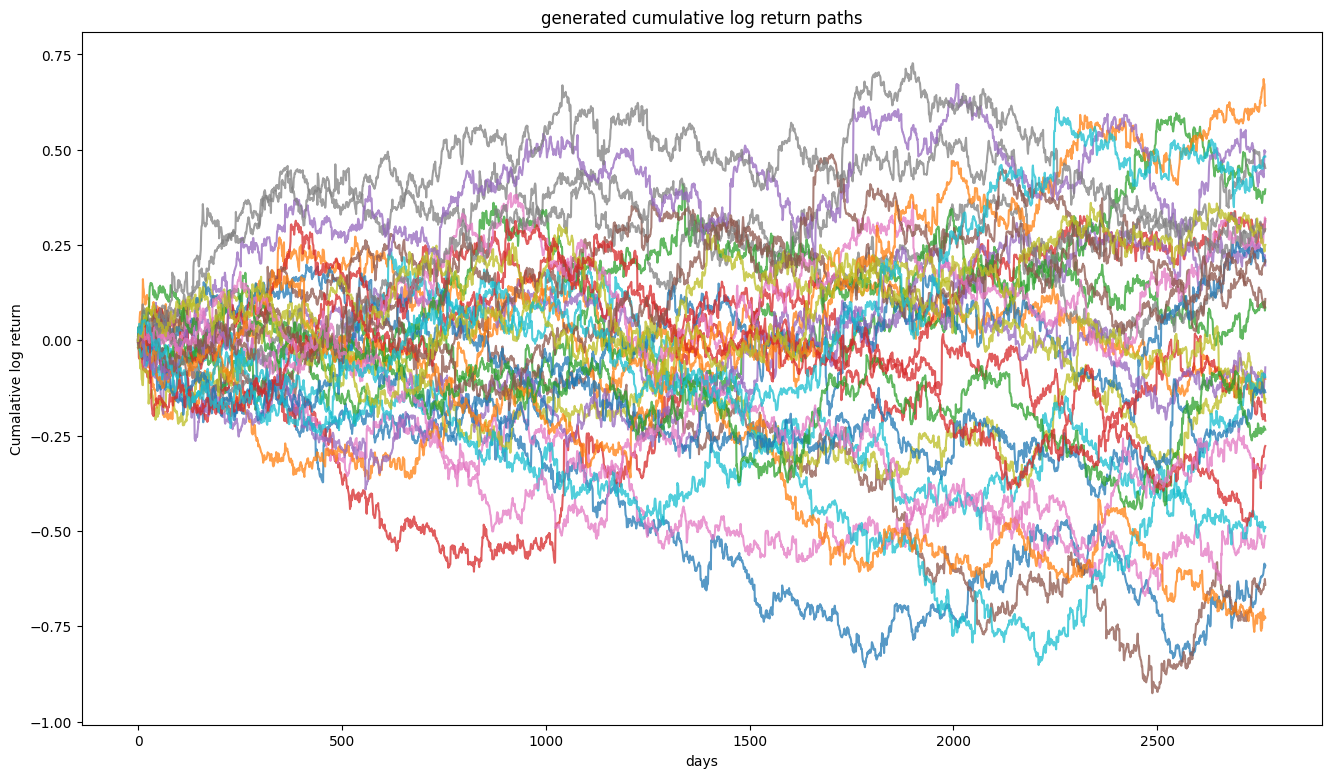

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title(f'generated cumulative log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

### Distributional Metrics

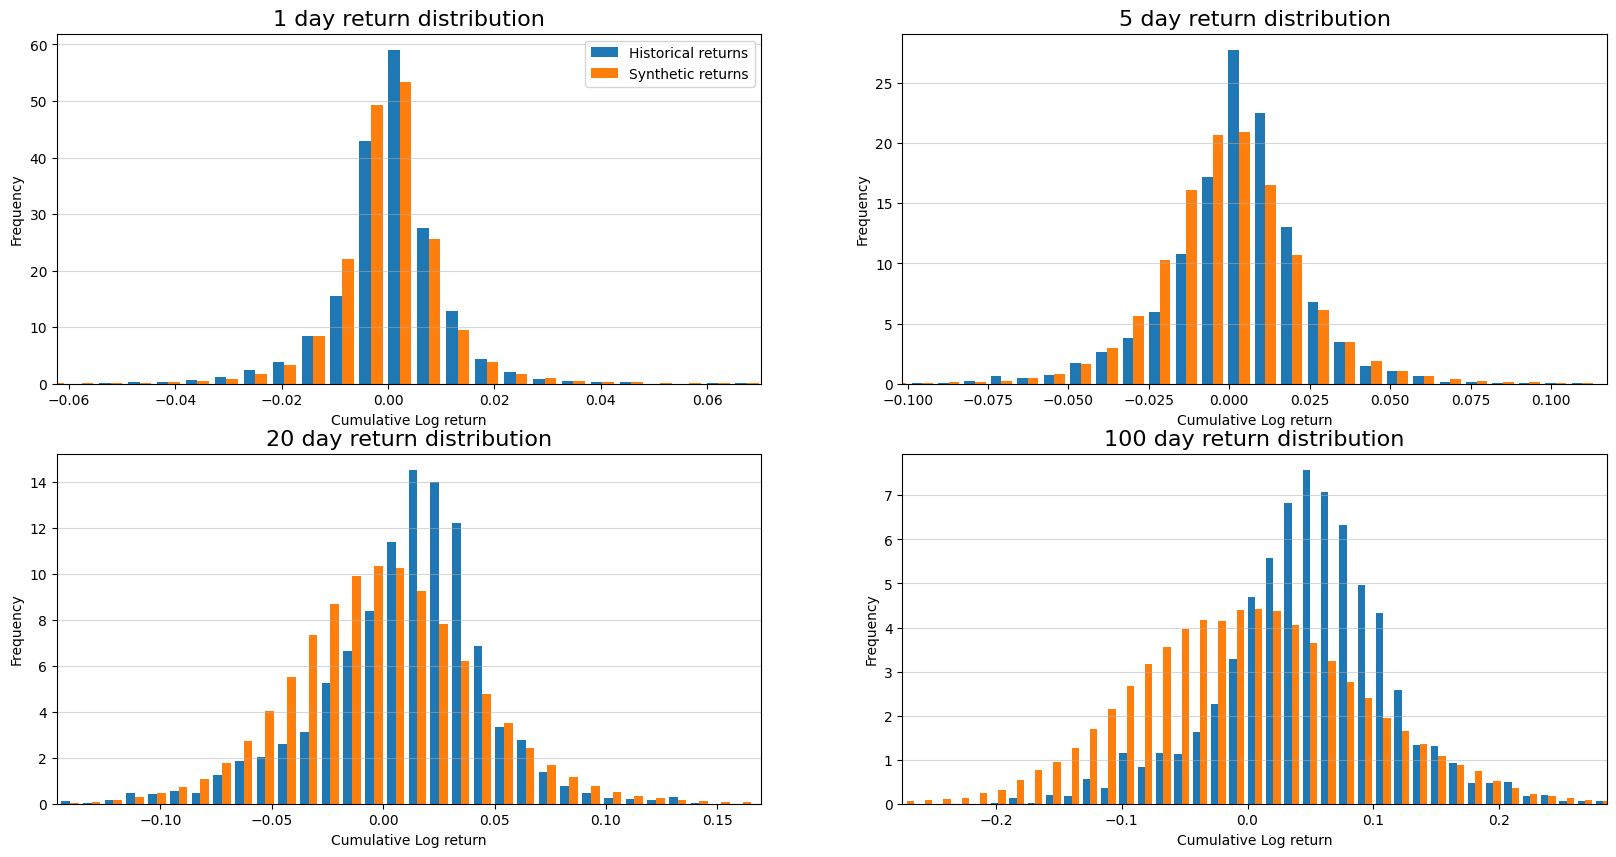

In [ ]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumulative Log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])

In [ ]:
windows = pd.Series([1, 5, 20, 100], name='window size')
EMDscores = np.zeros(len(windows))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()

    EMDscores[i] = wasserstein_distance(real_dist, fake_dist)
    # print(EMDscores[i])

df_EMD = pd.DataFrame({'Earth Mover Distance' : EMDscores}, index=windows)
df_EMD

,Earth Mover Distance
window size,
1,0.001021
5,0.003644
20,0.011809
100,0.048385


In [ ]:
windows = pd.Series([1, 5, 20, 100], name='window size')

# Real
real_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    real_array[i, 0] = skew(real_dist)
    real_array[i, 1] = skewtest(real_dist).pvalue
    real_array[i, 2] = kurtosis(real_dist)
    real_array[i, 3] = kurtosistest(real_dist).pvalue

real_df = pd.DataFrame(np.round(real_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value'], index=windows)


# Synthetic
fake_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_array[i, 0] = skew(fake_dist)
    fake_array[i, 1] = skewtest(fake_dist).pvalue
    fake_array[i, 2] = kurtosis(fake_dist)
    fake_array[i, 3] = kurtosistest(fake_dist).pvalue

fake_df = pd.DataFrame(np.round(fake_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value'], index=windows)

display_side_by_side(real_df,fake_df, titles=['Real','Synthetic'])

,skewness,skewness p-value,kurtosis,kurtosis p-value
window size,,,,
1,-0.350,0.000,5.088,0.0
5,-0.663,0.000,3.829,0.0
20,-0.814,0.000,3.889,0.0
100,-0.014,0.764,1.612,0.0
,skewness,skewness p-value,kurtosis,kurtosis p-value
window size,,,,
1,0.380,0.0,15.183,0.000
5,0.277,0.0,3.613,0.000
20,0.197,0.0,1.103,0.000


### Fat Tails

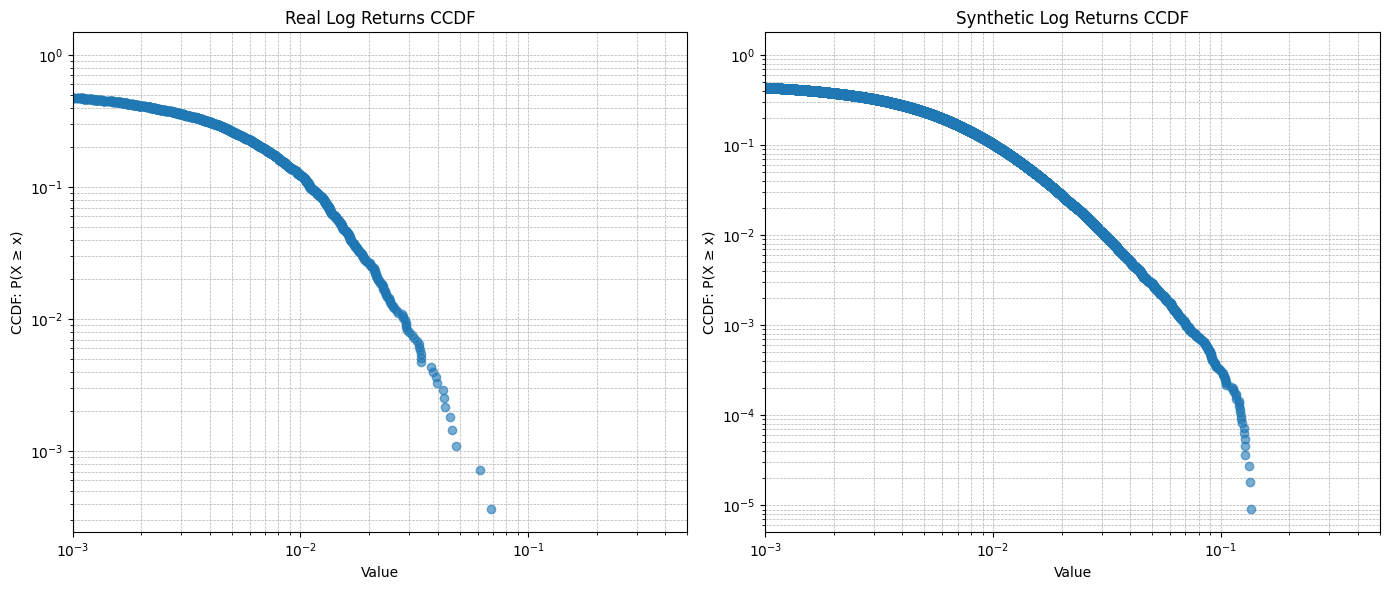

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw as powerlaw

def plot_ccdf(data, ax, title):
    """
    Plots the CCDF (Complementary Cumulative Distribution Function) of the data on a log-log scale.

    Parameters:
        data (array-like): The data to be plotted.
        ax (matplotlib.axes.Axes): The subplot axis to plot on.
        title (str): Title of the subplot.
    """
    # Sort the data in descending order
    sorted_data = np.sort(data)[::-1]
    n = len(sorted_data)
    # Compute the CCDF: rank / total number of points
    ccdf = np.arange(1, n+1) / n

    # Plot using log-log scale
    ax.loglog(sorted_data, ccdf, marker='o', linestyle='none', alpha=0.6)
    ax.set_xlim(0.001, 0.5)
    ax.set_xlabel("Value")
    ax.set_ylabel("CCDF: P(X ≥ x)")
    ax.set_title(title)
    ax.grid(True, which='both',  ls='--', lw=0.5)

# Assume real_log_returns and synthetic_log_returns are your datasets.
# If synthetic_log_returns is 2D (e.g., 80 x 2500), we flatten it.
real_data = log_returns.flatten() if log_returns.ndim > 1 else log_returns
synthetic_data = y.flatten() if y.ndim > 1 else y

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_ccdf(real_data, axes[0], "Real Log Returns CCDF")
plot_ccdf(synthetic_data, axes[1], "Synthetic Log Returns CCDF")

plt.tight_layout()
plt.show()

In [ ]:
# Real data
fit = powerlaw.Fit(log_returns.flatten(), xmin=0.01)
fit.power_law.alpha

Values less than or equal to 0 in data. Throwing out 0 or negative values


np.float64(3.302494130490744)

In [ ]:
# Synthetic/fake data
fit = powerlaw.Fit(y.flatten(), xmin=0.01)
fit.power_law.alpha

np.float64(2.958090747361413)

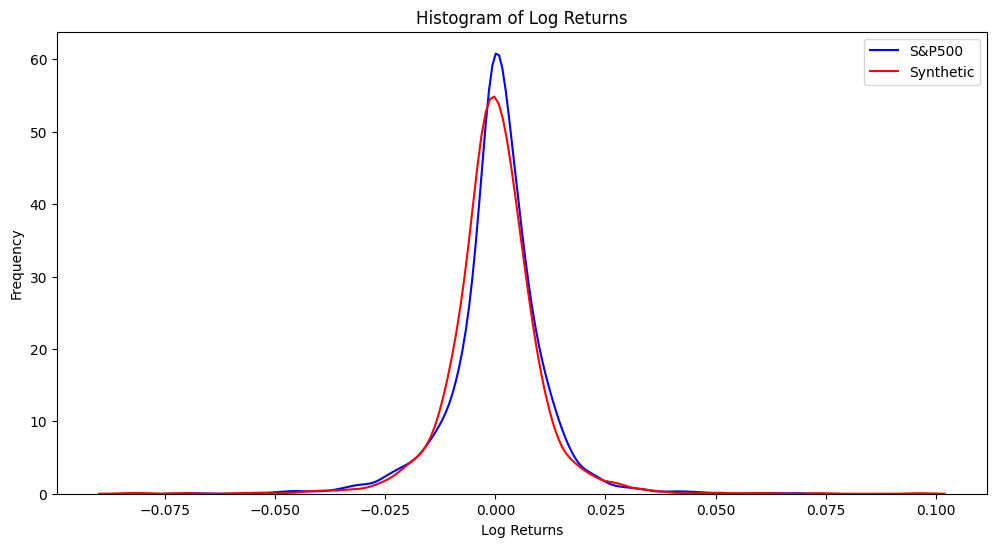

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms
plt.figure(figsize=(12, 6))
sns.kdeplot(log_returns.flatten(), label="S&P500", color="blue")
sns.kdeplot(y[0], label="Synthetic", color="red")

plt.legend()
plt.title("Histogram of Log Returns")
plt.xlabel("Log Returns")
plt.ylabel("Frequency")
plt.show()

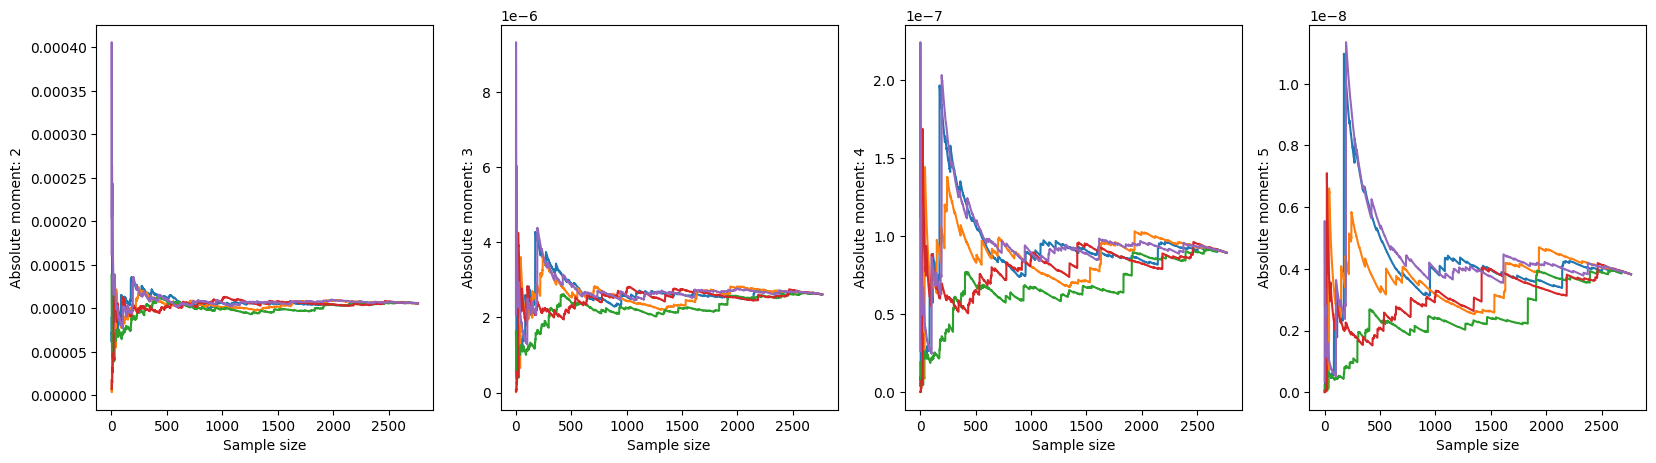

In [ ]:
# Real Data
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(20,5), ncols=4)
x_range = range(1, len(log_returns))

for _ in range(5):
    shuffled_array = np.random.permutation(log_returns)

    for j in range(len(absolute_moments)):
        ax[j].plot(x_range, [np.mean(np.abs(shuffled_array[:i])**absolute_moments[j], axis=0) for i in x_range]);

for i in range(len(absolute_moments)):
    ax[i].set_xlabel('Sample size')
    ax[i].set_ylabel('Absolute moment: {}'.format(absolute_moments[i]))

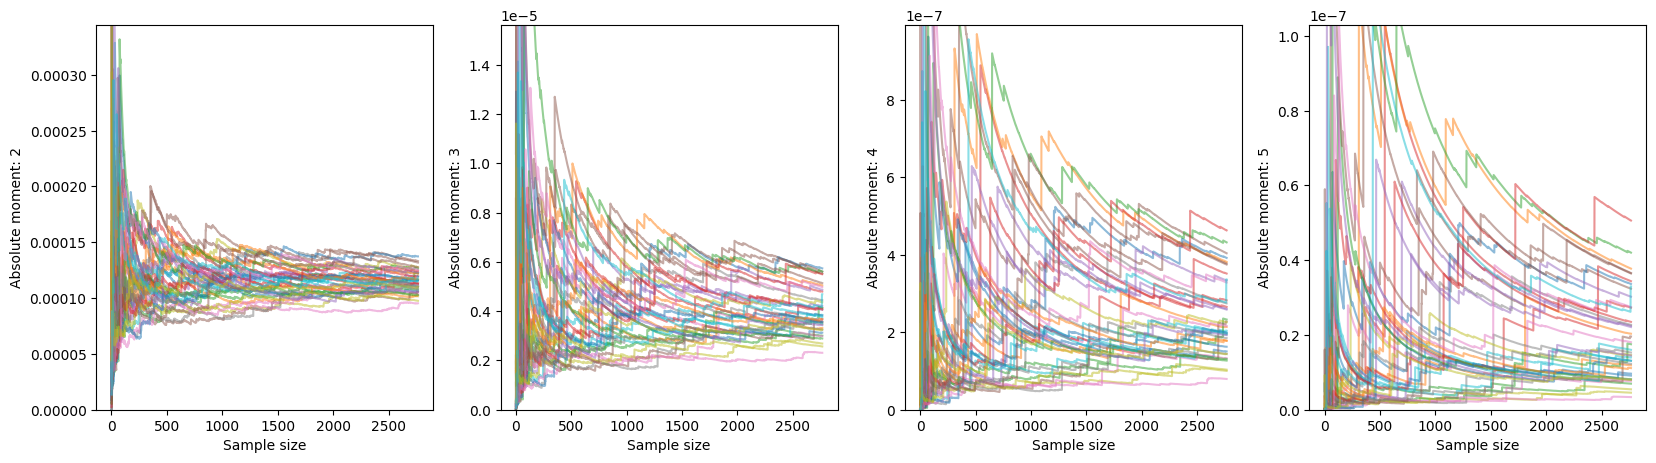

In [ ]:
# Synthetic Data
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(5*len(absolute_moments), 5), ncols=len(absolute_moments))
# x_range = range(1, 251)
x_range = range(1, len(log_returns))

# shuffle along first index, so tranpose
shuffled_array = np.random.permutation(y.T)

for j in range(len(absolute_moments)):
    paths = np.array([np.mean(np.abs(shuffled_array[:i, :50])**absolute_moments[j], axis=0) for i in x_range])
    ax[j].plot(x_range, paths, alpha=0.5)
    # ax[j].set_xlim(0, 250)
    ax[j].set_ylim(0, np.quantile(paths.max(axis=0), .85))
    ax[j].set_xlabel('Sample size')
    ax[j].set_ylabel('Absolute moment: {}'.format(absolute_moments[j]))

In [ ]:
# Hill Estimator
import numpy as np
import matplotlib.pyplot as plt

def hill_estimator(data, k):
    """
    Compute the Hill estimator for the tail index alpha.

    Parameters:
      data: 1D numpy array of strictly positive values (the tail)
      k: Number of top order statistics (largest values) to use.

    Returns:
      tail_index: Estimated tail exponent alpha.
    """
    # Sort data in descending order
    sorted_data = np.sort(data)[::-1]

    # Ensure k is less than the length of data
    if k >= len(sorted_data):
        raise ValueError("k must be smaller than the number of data points")

    # The (k+1)-th largest value is our threshold
    threshold = sorted_data[k]

    # Compute the Hill estimator statistic
    hill_sum = np.sum(np.log(sorted_data[:k] / threshold))
    hill_stat = hill_sum / k

    # The tail exponent (alpha) is the inverse of the Hill statistic
    tail_index = 1.0 / hill_stat
    return tail_index


# Flatten the data for the Hill estimator (since the tail is assumed identical across series)
synthetic_flat = y.flatten()
real_flat = log_returns.flatten()

# Choose k as, for example, the top 10% of observations
k_synthetic = int(0.05 * len(synthetic_flat))
k_real = int(0.05 * len(real_flat))

# Compute the tail index using the Hill estimator
alpha_synthetic = hill_estimator(synthetic_flat, k_synthetic)
alpha_real = hill_estimator(real_flat, k_real)

print("Estimated tail exponent (alpha) for synthetic data: {:.2f}".format(alpha_synthetic))
print("Estimated tail exponent (alpha) for real data: {:.2f}".format(alpha_real))

Estimated tail exponent (alpha) for synthetic data: 2.27
Estimated tail exponent (alpha) for real data: 2.74


### Volatility Clustering, Autocorrelation & Leverage Effect

In [ ]:
df_acf = pd.DataFrame(columns=['2 Day Volatility Score', '5 Day Volatility Score', '20 Day Volatility Score',
                               '100 Day Volatility Score', 'Vanilla ACF Score', 'Squared ACF Score',
                               'Absolute ACF Score', 'Leverage Effect Score', 'Volatility Persistence Score'])

[Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)')]

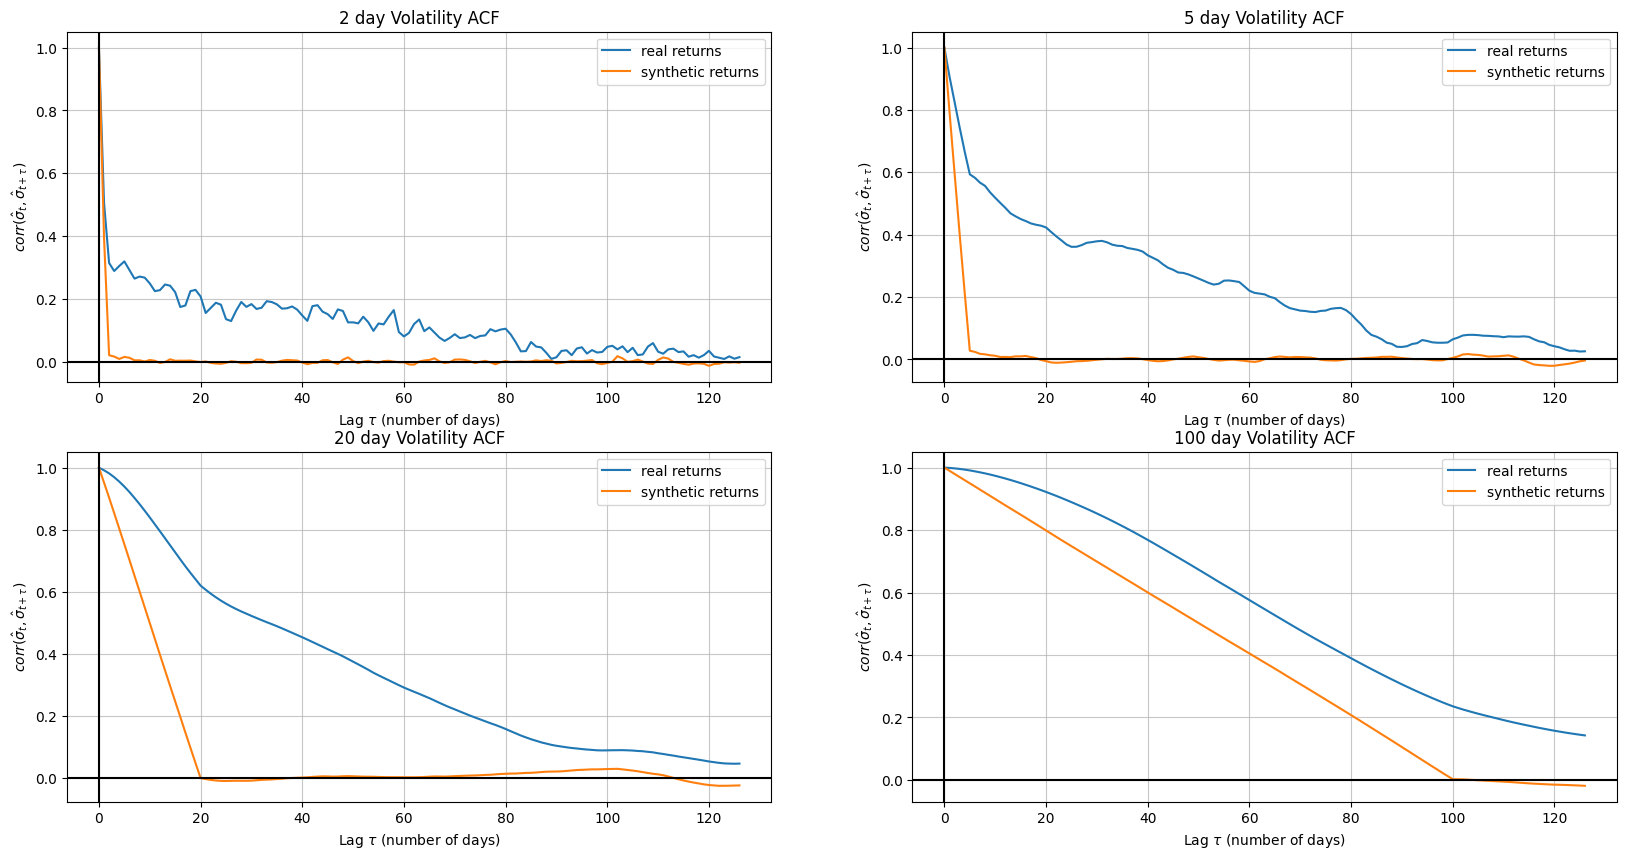

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

T = 127
vol_scores = []

# 1 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 2).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf,1)
real_acf = acf(rolling_window(log_returns, 2).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[0,0].plot(real_acf)
axs[0,0].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[0,0].grid(alpha=0.7)
axs[0,0].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('2 day Volatility ACF')


# 5 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 5).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 5).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[0,1].plot(real_acf)
axs[0,1].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[0,1].grid(alpha=0.7)
axs[0,1].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[0,1].set_title('5 day Volatility ACF')



# 20 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 20).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 20).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[1,0].plot(real_acf)
axs[1,0].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[1,0].grid(alpha=0.7)
axs[1,0].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[1,0].set_title('20 day Volatility ACF')


# 100 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 100).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 100).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[1,1].plot(real_acf)
axs[1,1].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[1,1].grid(alpha=0.7)
axs[1,1].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[1,1].set_title('100 day Volatility ACF')


for ax in axs.flat:
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.legend(['real returns', 'synthetic returns'])
plt.setp(axs, xlabel='Lag $\\tau$ (number of days)')

[Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)')]

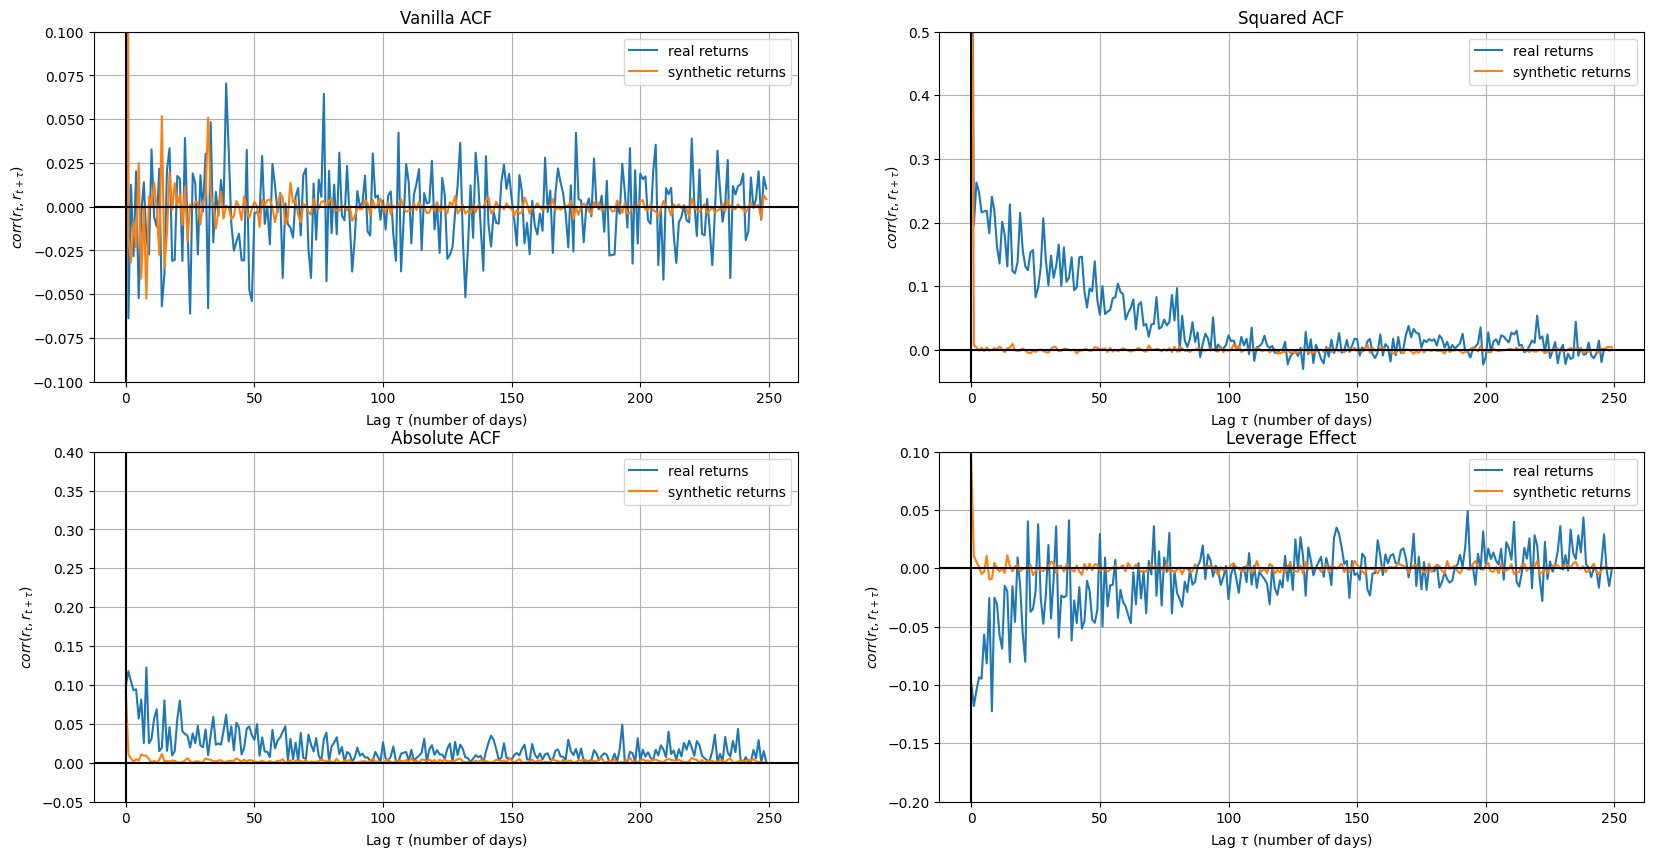

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

lags = 250
acf_scores = []

# Vanilla ACF
real_acf = acf(log_returns, lags)
fake_acf = acf(y.T, lags).mean(axis=1, keepdims=True)
axs[0,0].plot(real_acf)
axs[0,0].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[0,0].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Vanilla ACF')


# Squared  ACF
real_acf = acf(log_returns**2, lags)
fake_acf = acf(y.T**2, lags).mean(axis=1, keepdims=True)
axs[0,1].plot(real_acf)
axs[0,1].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[0,1].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].set_title('Squared ACF')

# Absolute  ACF
real_acf = abs(acf(log_returns, lags, le=True))
fake_acf = abs(acf(y.T, lags, le=True).mean(axis=1, keepdims=True))
axs[1,0].plot(real_acf)
axs[1,0].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[1,0].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute ACF')


# Leverage Effect
real_acf = acf(log_returns, lags, le=True)
fake_acf = acf(y.T, lags, le=True).mean(axis=1, keepdims=True)
axs[1,1].plot(real_acf)
axs[1,1].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[1,1].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage Effect')


for ax in axs.flat:
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.legend(['real returns', 'synthetic returns'])
plt.setp(axs, xlabel='Lag $\\tau$ (number of days)')

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Real Data Parameters:
omega: 2.435204357343744e-06, alpha: 0.10116525895820278, beta: 0.878793080389131, alpha + beta: 0.9799583393473337

Synthetic Data Parameters:
omega: 0.00012420019046292412, alpha: 5.4549985523008035e-06, beta: 4.56330984911588e-06, alpha + beta: 1.0018308401416683e-05



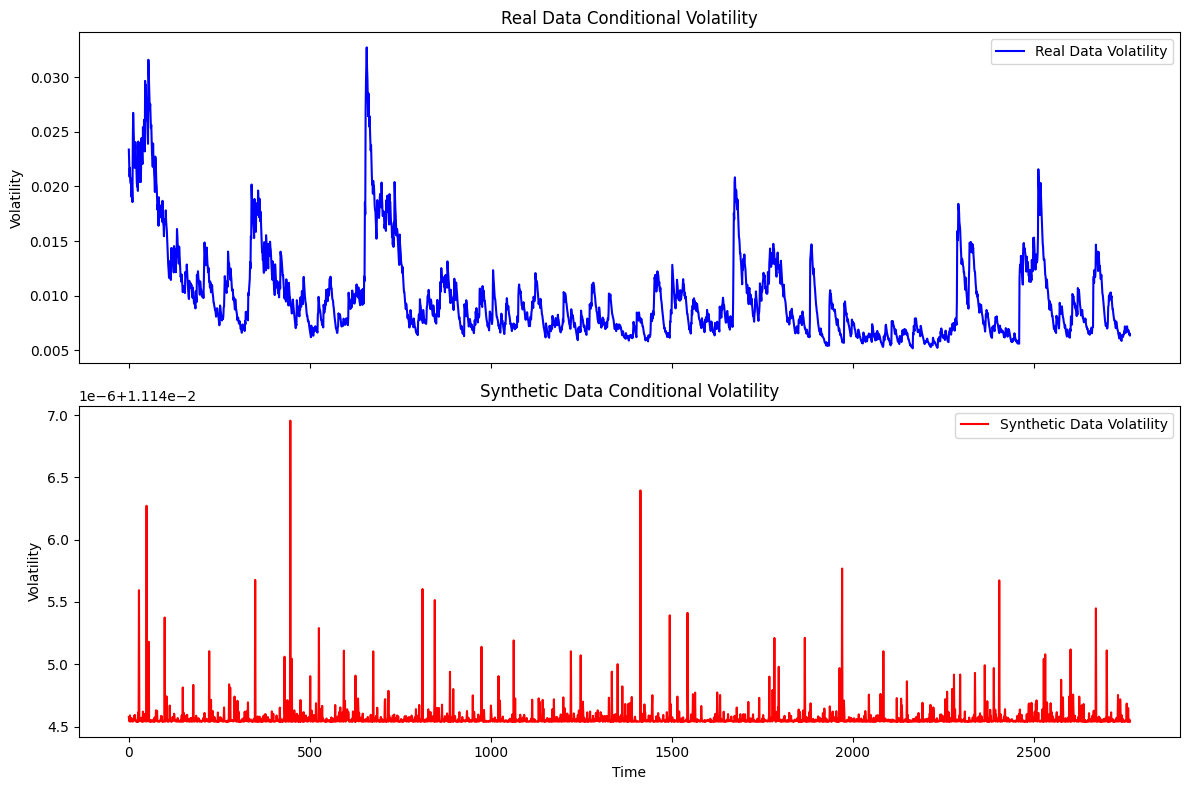

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Assuming 'real_returns' and 'synthetic_returns' are your datasets as pandas Series

# Fit GARCH(1,1) model to real data
garch_real = arch_model(log_returns, vol='Garch', p=1, q=1)
res_real = garch_real.fit(disp='off')
omega_real, alpha_real, beta_real = res_real.params[['omega', 'alpha[1]', 'beta[1]']]

# Fit GARCH(1,1) model to synthetic data
garch_synth = arch_model(y[4], vol='Garch', p=1, q=1)
res_synth = garch_synth.fit(disp='off')
omega_synth, alpha_synth, beta_synth = res_synth.params[['omega', 'alpha[1]', 'beta[1]']]

# Print the estimated parameters
print("Real Data Parameters:")
print(f"omega: {omega_real}, alpha: {alpha_real}, beta: {beta_real}, alpha + beta: {alpha_real + beta_real}\n")

print("Synthetic Data Parameters:")
print(f"omega: {omega_synth}, alpha: {alpha_synth}, beta: {beta_synth}, alpha + beta: {alpha_synth + beta_synth}\n")

# Plotting the conditional volatilities
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Real data volatility
axes[0].plot(res_real.conditional_volatility, color='blue', label='Real Data Volatility')
axes[0].set_title('Real Data Conditional Volatility')
axes[0].set_ylabel('Volatility')
axes[0].legend()

# Synthetic data volatility
axes[1].plot(res_synth.conditional_volatility, color='red', label='Synthetic Data Volatility')
axes[1].set_title('Synthetic Data Conditional Volatility')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Volatility')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# We call alpha + beta the volatility persistence score
alphabeta_sum = 0
for i in range(len(y)):
  garch_synth = arch_model(y[i], vol='Garch', p=1, q=1)
  res_synth = garch_synth.fit(disp='off')
  omega_synth, alpha_synth, beta_synth = res_synth.params[['omega', 'alpha[1]', 'beta[1]']]
  alphabeta_sum += alpha_synth + beta_synth

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001266. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarn

In [ ]:
# # Average volatility persistence score for synthetic data
print(alphabeta_sum/len(y))

0.6303463012554219


In [ ]:
all_scores = []
all_scores.extend(vol_scores)
all_scores.extend(acf_scores)
all_scores.append(alphabeta_sum/len(y))
df_acf.loc[len(df_acf)] = all_scores
df_acf

,2 Day Volatility Score,5 Day Volatility Score,20 Day Volatility Score,100 Day Volatility Score,Vanilla ACF Score,Squared ACF Score,Absolute ACF Score,Leverage Effect Score,Volatility Persistence Score
0,1.543842,3.018213,3.548762,1.892167,0.387808,1.182508,0.414121,0.487877,0.630346


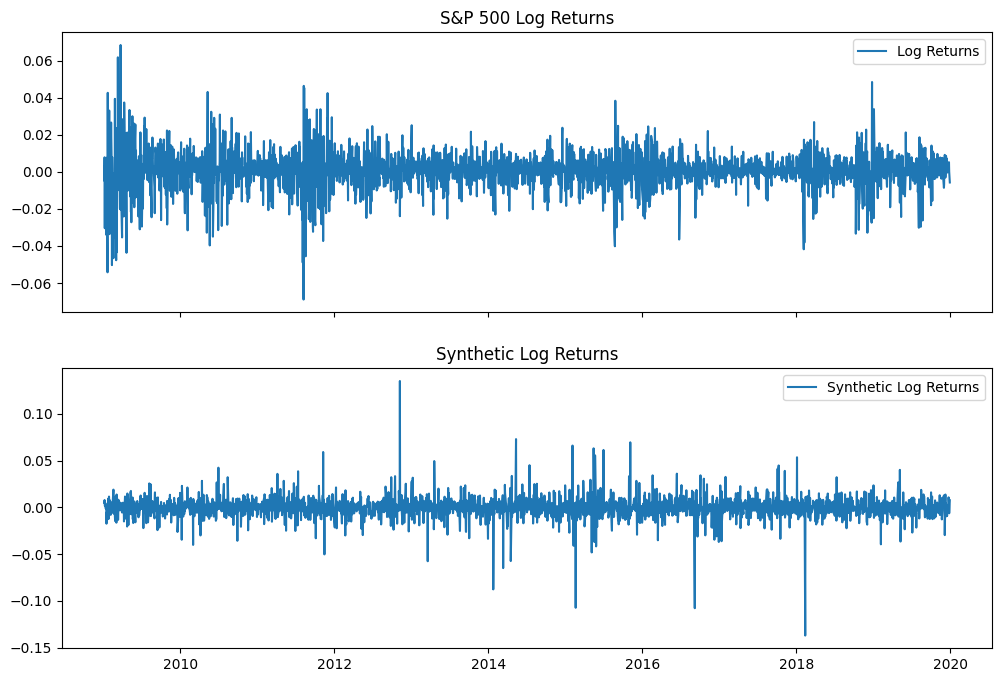

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)


axes[0].plot(data.index[1:], log_returns, label='Log Returns')
axes[0].set_title('S&P 500 Log Returns')
axes[0].legend()
axes[1].plot(data.index[1:], y[0], label='Synthetic Log Returns')
axes[1].set_title('Synthetic Log Returns')
axes[1].legend()